### Import

In [3]:
import pandas as pd
import numpy as np
import torch
import torchvision
import random
import glob
import PIL.Image
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from Preprocessing import dataset_base, img_util
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import time

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

### Results from Deep Font Classifier

In [4]:
res = pd.read_csv('/home/joseph/Dropbox/DeepLearning/These pro/Resultats/results_real.csv')
res.head(5)

,Unnamed: 0,font_1,font_2,font_3,font_4,font_5,p_1,p_2,p_3,p_4,p_5
0,0,1055.0,2185.0,2181.0,884.0,1047.0,1.361250e-37,2.224912e-22,4.130124e-13,7.546972e-02,0.92453
1,1,791.0,2382.0,901.0,884.0,2185.0,0.000000e+00,0.000000e+00,6.558077e-43,6.240193e-33,1.00000
2,2,795.0,796.0,797.0,2382.0,837.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.00000
3,3,2200.0,2186.0,386.0,2117.0,2181.0,2.720750e-16,5.800397e-16,6.691995e-10,4.592448e-09,1.00000
4,4,796.0,797.0,790.0,837.0,887.0,0.000000e+00,0.000000e+00,0.000000e+00,1.632585e-25,1.00000


In [5]:
# let's select the 3 most probable fonts
res_proba = res[['p_1','p_2','p_3','p_4','p_5']]
res_fonts = res[['font_1', 'font_2', 'font_3', 'font_4', 'font_5']]

In [6]:
# Proba font rank apparition
p_r_fonts = [res_proba.iloc[:,i].sum()/ res_proba.shape[0]  for i in range(res_proba.shape[1])]
p_r_fonts

[2.010788929072781e-06,
 2.523743044753453e-05,
 0.0003552975687895007,
 0.012816366263895266,
 0.9858254743029432]

In [7]:
# on va considéré la derniere colonne
res_fonts.font_5.value_counts().iloc[:5]

884.0     691
1744.0    506
837.0     404
2185.0    307
217.0     202
Name: font_5, dtype: int64

In [8]:
# let's display the five most recongnized fonts
with open('/home/joseph/Dropbox/AdobeVFR_release/fontlist.txt') as f: 
    fonts_list = f.read().split('\n')

In [9]:
fonts_list = np.asanyarray(fonts_list)
sel_fonts = [int(i) for i in res_fonts.font_5.value_counts().iloc[:5].index]
selected_font = fonts_list[sel_fonts]
selected_font

array(['GraphiteStd-BoldWide', 'OfficinaSansStd-Book',
       'GillSansStd-Light', 'TradeGothicLTStd-Extended',
       'BenguiatGothicStd-Book'], dtype='<U30')

### Generating Text images with top 5 fonts

#### Generating OCR image without noise

In [6]:
fonts_files = glob.glob(
    '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/Fonts_For_OCR_Domino/*/*.otf', recursive=True)

In [7]:
fonts_files.pop

<function list.pop(index=-1, /)>

In [8]:
len (fonts_files)

7

(393, 166)


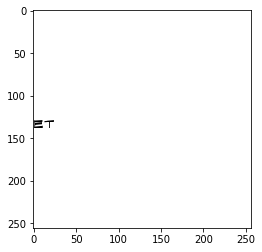

In [13]:
# let's do it in 256*256 as it is the standard size for cycle gan training
base_dimension = (256,256)
text = 'ET'
image = PIL.Image.new("RGB", base_dimension, color = (255, 255, 255))
font = ImageFont.truetype(fonts_files[5], base_dimension[1])
real_pixel_size = font.getsize(text)
print(real_pixel_size)
font = ImageFont.truetype(fonts_files[5], 16)
draw = ImageDraw.Draw(image)
print(draw)
draw.text((0,128), text, 0, font = font)
img = Image.fromarray(np.asarray(image), 'RGB')
img.save('my.png')
plt.imshow(np.asarray(image))

#### Add Position  and size randomness and rotation

[0.85959596 0.4        0.57171717 0.71313131 0.55656566 0.58686869
 0.45555556]


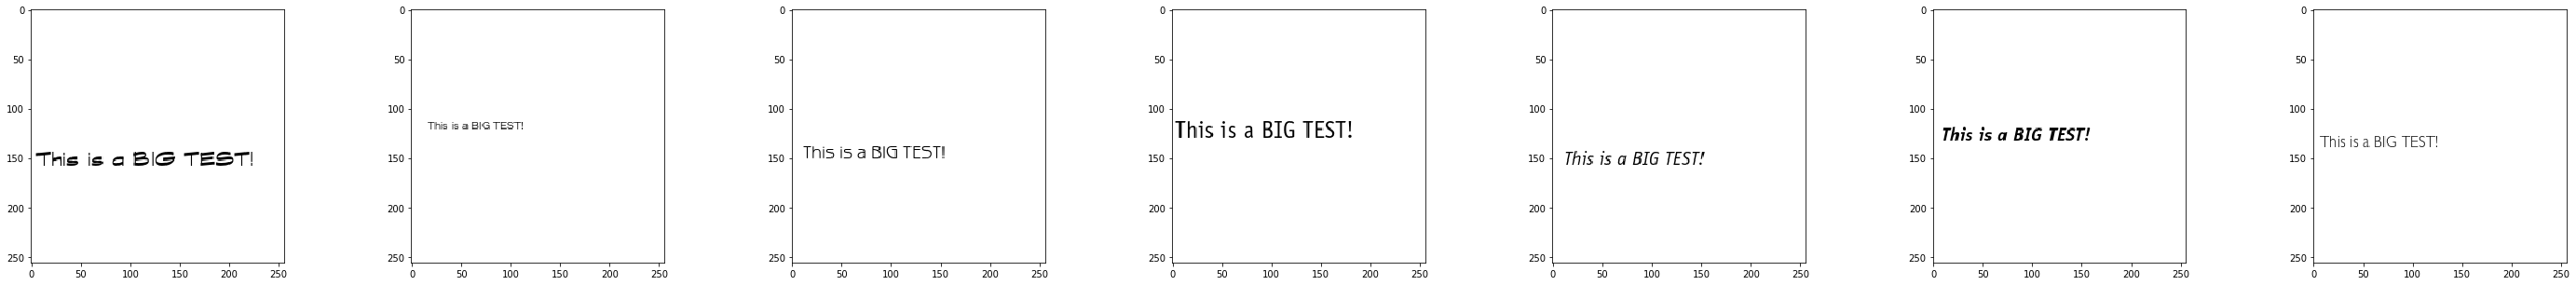

In [9]:
def GenerateImage(base_dim, font_file, text, fraction_w_occupation):
    '''
    Generate text image with random position from front file with a
    a determined occupation farction
    '''
    image = PIL.Image.new("RGB", base_dim, color=(255, 255, 255))
    font = ImageFont.truetype(font=font_file, size=base_dim[0])
    text_w_occup = font.getsize(text)[0] / base_dim[0]
    new_size = max(
        8, int(round(base_dim[0]/text_w_occup*fraction_w_occupation, 0)))
    x = np.random.choice(range(0, 26))
    y = np.random.choice(range(110,160 ))
    pos = (x, y)
    font = ImageFont.truetype(font_file, new_size)
    draw = ImageDraw.Draw(image)
    draw.text(pos, text, 0, font=font)
    img = Image.fromarray(np.asarray(image), 'RGB')
    return image

fig,axes = plt.subplots(1,7, figsize=(50,5))
fraction_w_occupation = np.random.choice(np.linspace(0.4, 0.9, 100), 7)
print(fraction_w_occupation)
test_images = []
for i,font in enumerate(fonts_files):
    test_images.append(GenerateImage(
        (256, 256), fonts_files[i], 'This is a BIG TEST!', fraction_w_occupation[i]))
    axes[i].imshow(np.asarray(test_images[i]))

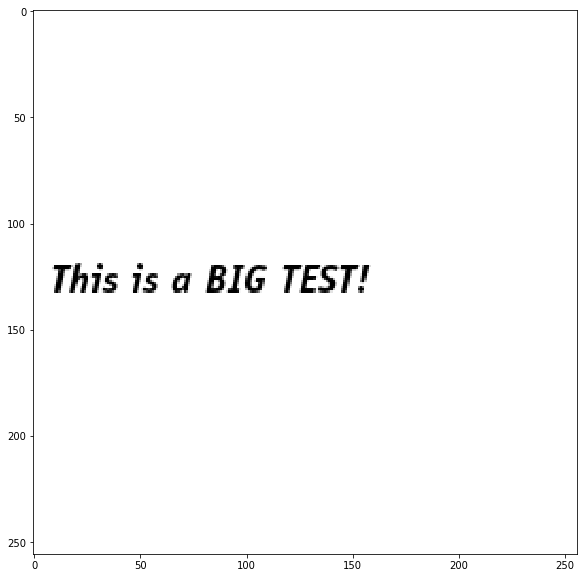

In [10]:
plt.figure(figsize=(15,10))
plt.imshow(np.asarray(test_images[5]))

#### Add random Noise

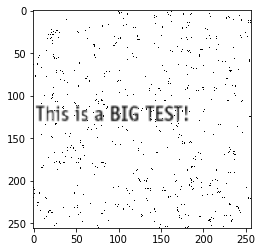

In [11]:
# big perturbation
test_image_perturb = dataset_base.big_perturbation(np.asarray(test_images[3]))
plt.imshow(test_image_perturb)

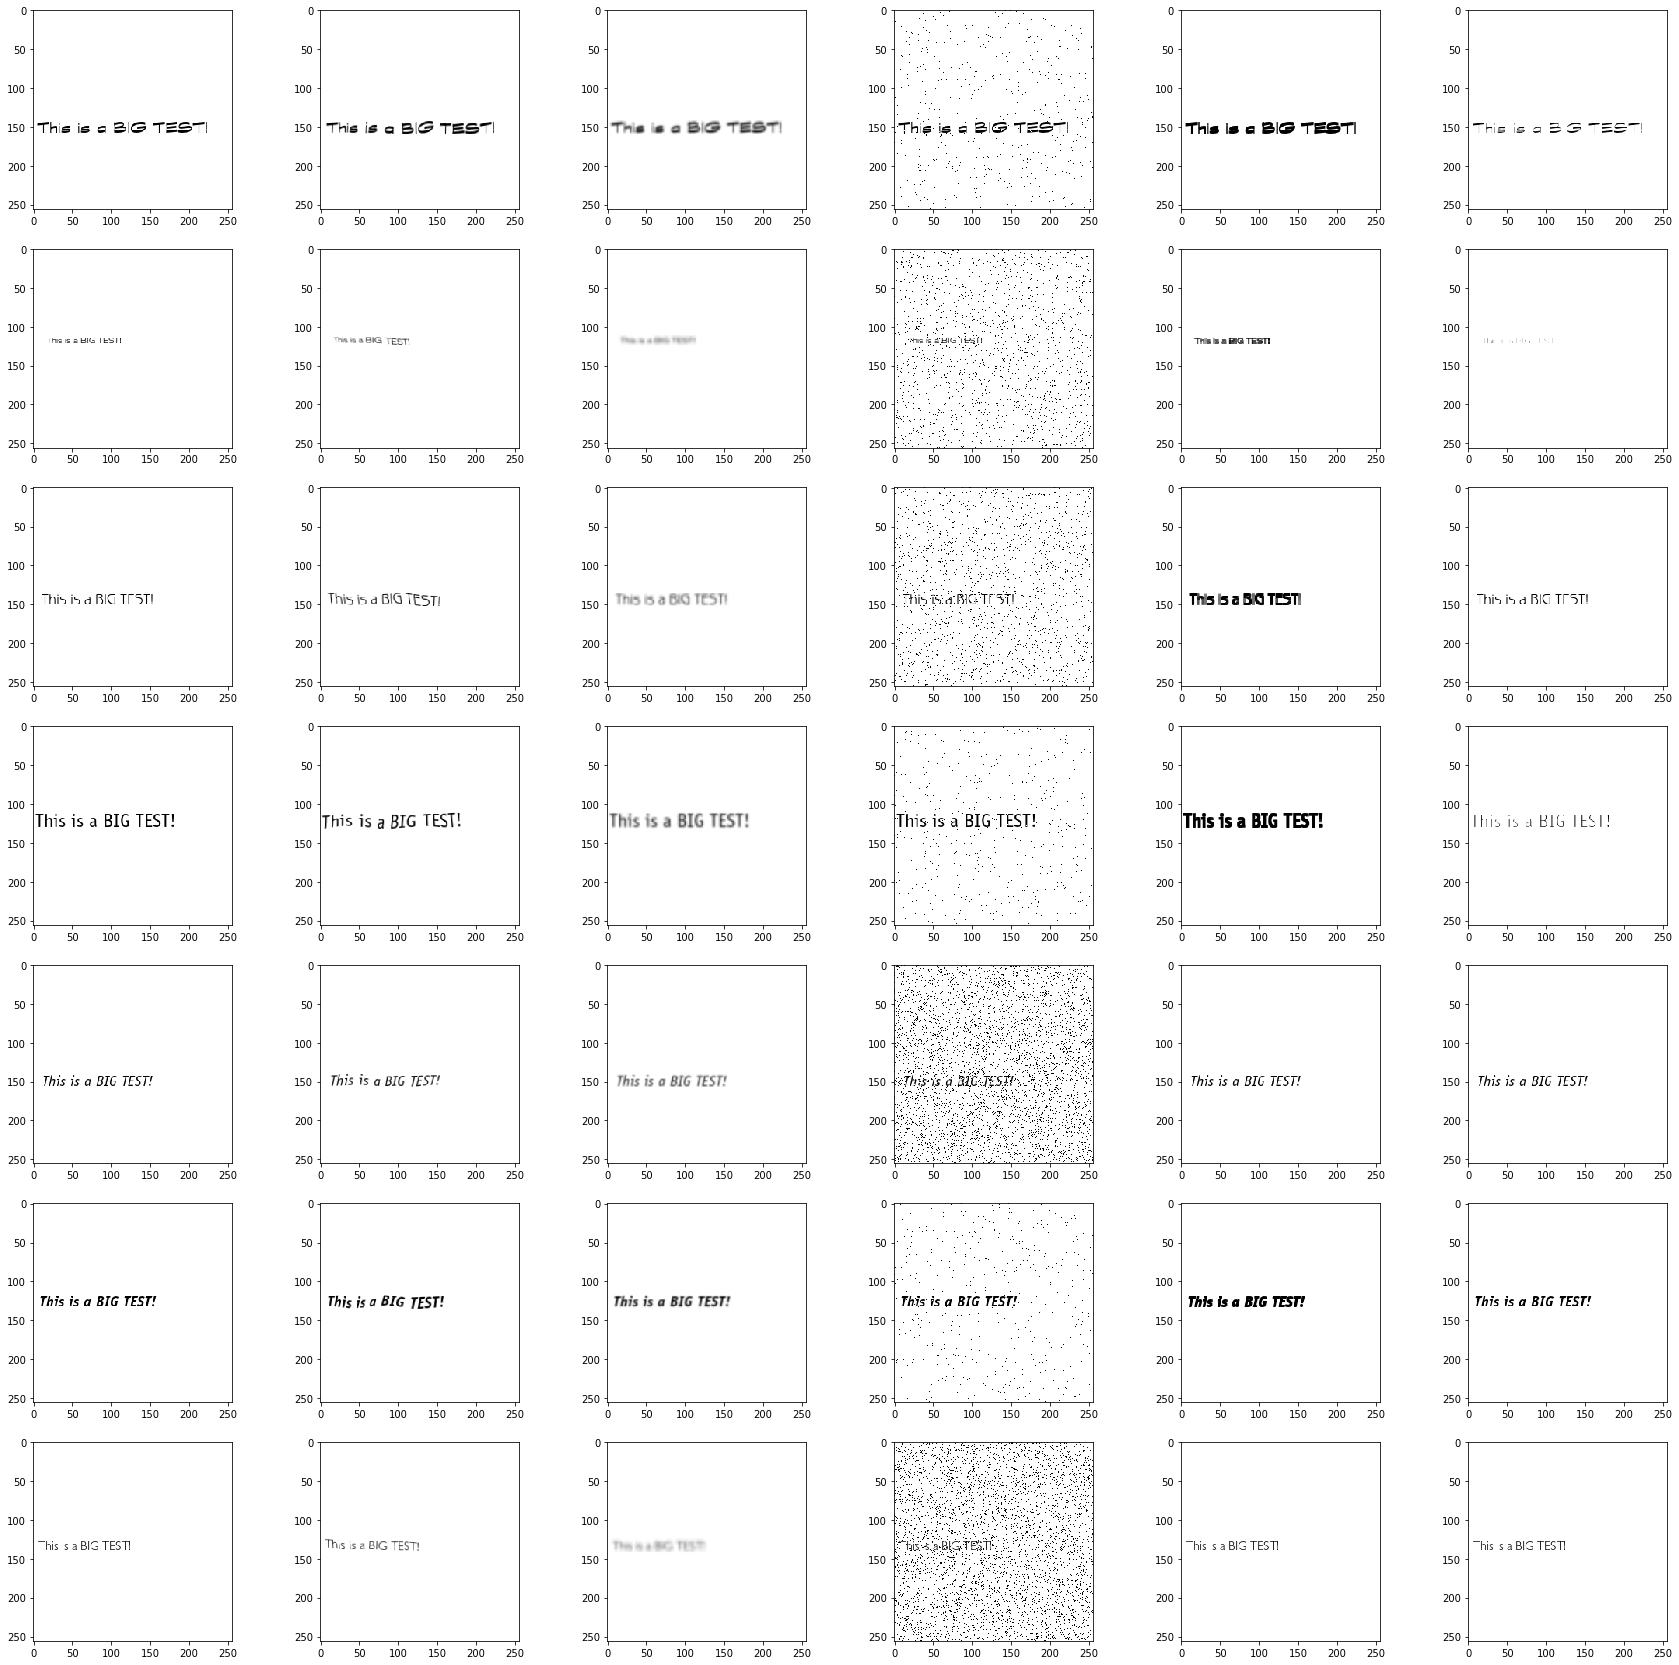

In [12]:
# atomic perturbations
fig, axes = plt.subplots(7, 6, figsize=(30,30))

for i,im in enumerate(test_images):
    im = np.asarray(test_images[i]).copy()
    im_perturb= dataset_base.small_perturbation(np.asarray(test_images[i]).copy())
    im_perturb_r = dataset_base.resize_perturbation(np.asarray(test_images[i]).copy())
    im_perturb_p = dataset_base.permute_perturbation(np.asarray(test_images[i]).copy())
    im_perturb_e = dataset_base.erode_perturbation(np.asarray(test_images[i]).copy())
    im_perturb_d = dataset_base.dilate_perturbation(np.asarray(test_images[i]).copy())
    axes[i,0].imshow(test_images[i])
    axes[i,1].imshow(im_perturb)
    axes[i,2].imshow(im_perturb_r)
    axes[i,3].imshow(im_perturb_p)
    axes[i,4].imshow(im_perturb_e)
    axes[i,5].imshow(im_perturb_d)

### Dataset building

In [18]:
# let's create 4 folders
# trainA : clean dataset # 12000
# trainB : noisy dataset # 12000
# testA : clean test dataset # 1000
# testB : noisy test dataset # 1000
func = [dataset_base.small_perturbation, dataset_base.resize_perturbation, 
            dataset_base.permute_perturbation, dataset_base.erode_perturbation,
           dataset_base.dilate_perturbation]
def ALL_generate_random_text():
    charsets = ["abcdefghijklmnopqrstuvwxyz     -/.'@!?+-_{}()[]",
                "0123456789-/",
                "abcdefghijklmnopqrstuvwxyz     -/.'@!?+-_{}()[]",
                "ABCDEFGHIJKLMNOPQRSTUVWXYZ     -/.'@!?+-_{}()[]",
                "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ          -/.'@!?+-_{}()[]",
                "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ          -/.'@!?+-_{}()[]",

                ]
    charset = random.choice(charsets)
    length = random.randint(10, 26)
    string = "".join([random.choice(charset) for _ in range(length)])
    return string    

In [60]:
# let's built it
# we will have a proportion of symetric images of 15%
np.random.RandomState(26)
prop_sym_im = 0.2
nb_train_images = 12000
nb_test_images = 1000
base_dim = (256, 256)
meta = {'A': {}, 'B': {}}
#fig, axes = plt.subplots(3, 2, figsize=(20,20))
start = time.time()
for i in range(nb_train_images+nb_test_images): 
    meta['B'][i] = {}
    meta['A'][i] = {}
    meta['B'][i] = {}
    text = ALL_generate_random_text()
    fonts = np.random.choice(fonts_files, 2)
    frac = np.random.choice(np.linspace(0.4, 0.9, 100), 2)
    perturbations = np.random.choice(func, 3)
    image_A = GenerateImage(base_dim, fonts[0], text, frac[0])
    meta['A'][i]['text'] = text
    meta['A'][i]['font'] = font[0]
    meta['A'][i]['frac'] = frac[0]
    meta['B'][i]['perturb'] = [p.__name__ for p in perturbations]
    if np.random.uniform() > prop_sym_im:
        text_B = ALL_generate_random_text()
        image_B = GenerateImage(
            base_dim, fonts[1], text_B, frac[1])
        meta['B'][i]['text'] = text_B
        meta['B'][i]['font'] = fonts[1]
        meta['B'][i]['frac'] = frac[1]
    else:
        image_B = image_A.copy()
        meta['B'][i]['text'] = text
        meta['B'][i]['font'] = fonts[0]
        meta['B'][i]['frac'] = frac[0]
    for noise in perturbations:
        image_B = noise(np.asarray(image_B).copy())
    image_B = Image.fromarray(image_B.astype('uint8'), 'RGB')
    #axes[i,0].imshow(np.asarray(image_A))
    #axes[i,1].imshow(np.asarray(image_B))
    
    if i < nb_train_images:
        image_A.save(
            '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data/trainA/img_A_'+str(i)+'.png')
        image_B.save(
            '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data/trainB/img_B_'+str(i)+'.png')
    else:
        image_A.save(
            '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data/testA/img_A_'+str(i)+'.png')
        image_B.save(
            '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data/testB/img_B_'+str(i)+'.png')
    if i%1000 == 0 :
        print('{} images created from the begining in {} seconds'.format(i*2,time.time()-start))

0 images created from the begining in 0.014318466186523438 seconds
2000 images created from the begining in 54.54343938827515 seconds
4000 images created from the begining in 109.53661274909973 seconds
6000 images created from the begining in 164.09485960006714 seconds
8000 images created from the begining in 219.0796468257904 seconds
10000 images created from the begining in 277.0515420436859 seconds
12000 images created from the begining in 332.4882581233978 seconds
14000 images created from the begining in 396.71862387657166 seconds
16000 images created from the begining in 456.8279011249542 seconds
18000 images created from the begining in 521.4975988864899 seconds
20000 images created from the begining in 580.3727147579193 seconds
22000 images created from the begining in 641.6198587417603 seconds
24000 images created from the begining in 702.0909450054169 seconds


In [62]:
import pickle
with open('/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data/metadata.pkl', 'wb') as f:
        pickle.dump(meta, f, pickle.HIGHEST_PROTOCOL)

In [70]:
same={}
for id in meta['A']:
    if meta['A'][id]['text'] == meta['B'][id]['text']: 
        same[id] =meta['B'][id]['text']
len(same.keys())--loadSize

2564

### Cycle Gan Training

In [ ]:
! python pytorch-CycleGAN-and-pix2pix/train.py --dataroot ./data/ --batch_size 1 --loadSize 256

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                 dataroot: ./data/                       	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
              

(epoch: 1, iters: 3000, time: 0.369, data: 0.001) D_A: 0.264 G_A: 0.530 cycle_A: 0.139 idt_A: 0.106 D_B: 0.246 G_B: 0.657 cycle_B: 0.200 idt_B: 0.080 
(epoch: 1, iters: 3100, time: 0.371, data: 0.002) D_A: 0.080 G_A: 0.566 cycle_A: 0.102 idt_A: 0.801 D_B: 0.145 G_B: 0.405 cycle_B: 1.919 idt_B: 0.054 
(epoch: 1, iters: 3200, time: 0.458, data: 0.001) D_A: 0.269 G_A: 0.271 cycle_A: 0.088 idt_A: 0.101 D_B: 0.246 G_B: 0.152 cycle_B: 0.235 idt_B: 0.049 
(epoch: 1, iters: 3300, time: 0.370, data: 0.001) D_A: 0.078 G_A: 0.367 cycle_A: 0.111 idt_A: 0.368 D_B: 0.254 G_B: 0.395 cycle_B: 0.750 idt_B: 0.069 
(epoch: 1, iters: 3400, time: 0.370, data: 0.002) D_A: 0.133 G_A: 0.467 cycle_A: 0.191 idt_A: 0.141 D_B: 0.438 G_B: 0.163 cycle_B: 0.321 idt_B: 0.095 
(epoch: 1, iters: 3500, time: 0.371, data: 0.001) D_A: 0.258 G_A: 0.274 cycle_A: 0.148 idt_A: 0.034 D_B: 0.233 G_B: 0.114 cycle_B: 0.068 idt_B: 0.074 
(epoch: 1, iters: 3600, time: 0.459, data: 0.002) D_A: 0.194 G_A: 0.574 cycle_A: 0.126 idt_A: 

(epoch: 1, iters: 8400, time: 0.483, data: 0.001) D_A: 0.072 G_A: 0.438 cycle_A: 0.083 idt_A: 0.608 D_B: 0.101 G_B: 0.951 cycle_B: 1.737 idt_B: 0.047 
(epoch: 1, iters: 8500, time: 0.370, data: 0.001) D_A: 0.291 G_A: 0.525 cycle_A: 0.151 idt_A: 0.044 D_B: 0.065 G_B: 0.608 cycle_B: 0.108 idt_B: 0.078 
(epoch: 1, iters: 8600, time: 0.369, data: 0.001) D_A: 0.078 G_A: 0.520 cycle_A: 0.084 idt_A: 0.137 D_B: 0.125 G_B: 0.328 cycle_B: 0.263 idt_B: 0.041 
(epoch: 1, iters: 8700, time: 0.370, data: 0.001) D_A: 0.272 G_A: 0.328 cycle_A: 0.121 idt_A: 0.020 D_B: 0.117 G_B: 0.025 cycle_B: 0.053 idt_B: 0.066 
(epoch: 1, iters: 8800, time: 0.478, data: 0.001) D_A: 0.066 G_A: 0.418 cycle_A: 0.074 idt_A: 0.194 D_B: 0.115 G_B: 0.358 cycle_B: 0.774 idt_B: 0.040 
(epoch: 1, iters: 8900, time: 0.369, data: 0.001) D_A: 0.073 G_A: 0.421 cycle_A: 0.098 idt_A: 0.088 D_B: 0.121 G_B: 0.089 cycle_B: 0.249 idt_B: 0.049 
(epoch: 1, iters: 9000, time: 0.370, data: 0.001) D_A: 0.122 G_A: 0.282 cycle_A: 0.092 idt_A: 

(epoch: 2, iters: 1800, time: 0.368, data: 0.001) D_A: 0.234 G_A: 0.314 cycle_A: 0.050 idt_A: 0.081 D_B: 0.134 G_B: 0.022 cycle_B: 0.177 idt_B: 0.033 
(epoch: 2, iters: 1900, time: 0.369, data: 0.001) D_A: 0.271 G_A: 0.308 cycle_A: 0.064 idt_A: 0.012 D_B: 0.138 G_B: 0.057 cycle_B: 0.062 idt_B: 0.029 
(epoch: 2, iters: 2000, time: 0.480, data: 0.002) D_A: 0.031 G_A: 0.675 cycle_A: 0.063 idt_A: 0.022 D_B: 0.151 G_B: 0.248 cycle_B: 0.748 idt_B: 0.037 
(epoch: 2, iters: 2100, time: 0.370, data: 0.001) D_A: 0.250 G_A: 0.354 cycle_A: 0.067 idt_A: 0.063 D_B: 0.038 G_B: 0.188 cycle_B: 0.109 idt_B: 0.027 
(epoch: 2, iters: 2200, time: 0.371, data: 0.001) D_A: 0.028 G_A: 0.652 cycle_A: 0.109 idt_A: 0.903 D_B: 0.114 G_B: 0.779 cycle_B: 5.130 idt_B: 0.067 
(epoch: 2, iters: 2300, time: 0.369, data: 0.001) D_A: 0.106 G_A: 0.317 cycle_A: 0.048 idt_A: 0.093 D_B: 0.259 G_B: 0.256 cycle_B: 0.942 idt_B: 0.029 
(epoch: 2, iters: 2400, time: 0.456, data: 0.001) D_A: 0.277 G_A: 0.452 cycle_A: 0.067 idt_A: 

(epoch: 2, iters: 7200, time: 0.455, data: 0.002) D_A: 0.248 G_A: 0.287 cycle_A: 0.054 idt_A: 0.075 D_B: 0.198 G_B: 0.700 cycle_B: 0.098 idt_B: 0.028 
(epoch: 2, iters: 7300, time: 0.368, data: 0.001) D_A: 0.249 G_A: 0.378 cycle_A: 0.046 idt_A: 0.041 D_B: 0.222 G_B: 0.164 cycle_B: 0.072 idt_B: 0.027 
(epoch: 2, iters: 7400, time: 0.369, data: 0.001) D_A: 0.066 G_A: 0.551 cycle_A: 0.058 idt_A: 0.052 D_B: 0.206 G_B: 0.369 cycle_B: 1.702 idt_B: 0.028 
(epoch: 2, iters: 7500, time: 0.369, data: 0.001) D_A: 0.262 G_A: 0.337 cycle_A: 0.129 idt_A: 0.045 D_B: 0.246 G_B: 0.275 cycle_B: 0.089 idt_B: 0.095 
(epoch: 2, iters: 7600, time: 0.483, data: 0.001) D_A: 0.104 G_A: 0.309 cycle_A: 0.039 idt_A: 0.058 D_B: 0.257 G_B: 0.251 cycle_B: 0.253 idt_B: 0.022 
(epoch: 2, iters: 7700, time: 0.370, data: 0.001) D_A: 0.032 G_A: 0.654 cycle_A: 0.057 idt_A: 0.032 D_B: 0.137 G_B: 0.895 cycle_B: 1.474 idt_B: 0.044 
(epoch: 2, iters: 7800, time: 0.370, data: 0.001) D_A: 0.308 G_A: 0.551 cycle_A: 0.067 idt_A: 

(epoch: 3, iters: 600, time: 0.369, data: 0.001) D_A: 0.272 G_A: 0.309 cycle_A: 0.092 idt_A: 0.031 D_B: 0.239 G_B: 0.867 cycle_B: 0.132 idt_B: 0.059 
(epoch: 3, iters: 700, time: 0.369, data: 0.002) D_A: 0.076 G_A: 0.436 cycle_A: 0.086 idt_A: 0.024 D_B: 0.089 G_B: 0.522 cycle_B: 0.710 idt_B: 0.029 
(epoch: 3, iters: 800, time: 0.471, data: 0.001) D_A: 0.280 G_A: 0.371 cycle_A: 0.071 idt_A: 0.050 D_B: 0.405 G_B: 0.142 cycle_B: 0.091 idt_B: 0.039 
(epoch: 3, iters: 900, time: 0.371, data: 0.001) D_A: 0.273 G_A: 0.404 cycle_A: 0.042 idt_A: 0.032 D_B: 0.011 G_B: 0.769 cycle_B: 0.061 idt_B: 0.023 
(epoch: 3, iters: 1000, time: 0.370, data: 0.001) D_A: 0.027 G_A: 0.622 cycle_A: 0.053 idt_A: 0.006 D_B: 0.117 G_B: 0.454 cycle_B: 0.217 idt_B: 0.039 
saving the latest model (epoch 3, total_steps 25000)
(epoch: 3, iters: 1100, time: 0.370, data: 0.001) D_A: 0.066 G_A: 0.444 cycle_A: 0.033 idt_A: 0.427 D_B: 0.667 G_B: 1.460 cycle_B: 1.663 idt_B: 0.021 
(epoch: 3, iters: 1200, time: 0.466, data: 0.

(epoch: 3, iters: 6000, time: 0.474, data: 0.001) D_A: 0.078 G_A: 0.449 cycle_A: 0.085 idt_A: 0.025 D_B: 0.102 G_B: 0.566 cycle_B: 0.338 idt_B: 0.027 
saving the latest model (epoch 3, total_steps 30000)
(epoch: 3, iters: 6100, time: 0.369, data: 0.001) D_A: 0.048 G_A: 0.499 cycle_A: 0.061 idt_A: 0.464 D_B: 0.046 G_B: 0.649 cycle_B: 1.683 idt_B: 0.036 
(epoch: 3, iters: 6200, time: 0.369, data: 0.001) D_A: 0.296 G_A: 0.505 cycle_A: 0.055 idt_A: 0.033 D_B: 0.139 G_B: 0.410 cycle_B: 0.159 idt_B: 0.053 
(epoch: 3, iters: 6300, time: 0.368, data: 0.002) D_A: 0.114 G_A: 0.188 cycle_A: 0.073 idt_A: 0.107 D_B: 0.083 G_B: 0.209 cycle_B: 0.141 idt_B: 0.039 
(epoch: 3, iters: 6400, time: 0.538, data: 0.001) D_A: 0.075 G_A: 0.422 cycle_A: 0.039 idt_A: 0.068 D_B: 0.177 G_B: 0.995 cycle_B: 1.209 idt_B: 0.033 
(epoch: 3, iters: 6500, time: 0.370, data: 0.001) D_A: 0.059 G_A: 0.471 cycle_A: 0.044 idt_A: 0.093 D_B: 0.050 G_B: 0.924 cycle_B: 1.199 idt_B: 0.026 
(epoch: 3, iters: 6600, time: 0.369, data

(epoch: 3, iters: 11400, time: 0.370, data: 0.002) D_A: 0.283 G_A: 0.464 cycle_A: 0.052 idt_A: 0.020 D_B: 0.033 G_B: 0.192 cycle_B: 0.045 idt_B: 0.028 
(epoch: 3, iters: 11500, time: 0.370, data: 0.001) D_A: 0.277 G_A: 0.453 cycle_A: 0.055 idt_A: 0.077 D_B: 0.296 G_B: 0.145 cycle_B: 0.145 idt_B: 0.028 
(epoch: 3, iters: 11600, time: 0.494, data: 0.001) D_A: 0.082 G_A: 0.401 cycle_A: 0.119 idt_A: 0.028 D_B: 0.061 G_B: 0.853 cycle_B: 0.820 idt_B: 0.033 
(epoch: 3, iters: 11700, time: 0.369, data: 0.001) D_A: 0.090 G_A: 0.404 cycle_A: 0.071 idt_A: 0.038 D_B: 0.117 G_B: 0.336 cycle_B: 1.258 idt_B: 0.035 
(epoch: 3, iters: 11800, time: 0.370, data: 0.001) D_A: 0.045 G_A: 0.512 cycle_A: 0.053 idt_A: 0.143 D_B: 0.049 G_B: 0.729 cycle_B: 0.746 idt_B: 0.024 
(epoch: 3, iters: 11900, time: 0.369, data: 0.001) D_A: 0.282 G_A: 0.501 cycle_A: 0.054 idt_A: 0.021 D_B: 0.052 G_B: 1.286 cycle_B: 0.067 idt_B: 0.027 
(epoch: 3, iters: 12000, time: 0.466, data: 0.001) D_A: 0.071 G_A: 0.430 cycle_A: 0.037 

(epoch: 4, iters: 4800, time: 0.466, data: 0.001) D_A: 0.279 G_A: 0.456 cycle_A: 0.042 idt_A: 0.059 D_B: 0.140 G_B: 0.667 cycle_B: 0.159 idt_B: 0.046 
(epoch: 4, iters: 4900, time: 0.370, data: 0.001) D_A: 0.056 G_A: 0.557 cycle_A: 0.062 idt_A: 0.099 D_B: 0.048 G_B: 0.588 cycle_B: 0.804 idt_B: 0.035 
(epoch: 4, iters: 5000, time: 0.370, data: 0.001) D_A: 0.075 G_A: 0.403 cycle_A: 0.044 idt_A: 0.040 D_B: 0.051 G_B: 0.900 cycle_B: 1.168 idt_B: 0.020 
(epoch: 4, iters: 5100, time: 0.370, data: 0.002) D_A: 0.080 G_A: 0.374 cycle_A: 0.062 idt_A: 0.019 D_B: 0.014 G_B: 1.502 cycle_B: 0.513 idt_B: 0.034 
(epoch: 4, iters: 5200, time: 0.477, data: 0.001) D_A: 0.308 G_A: 0.328 cycle_A: 0.077 idt_A: 0.011 D_B: 0.012 G_B: 1.152 cycle_B: 0.024 idt_B: 0.042 
(epoch: 4, iters: 5300, time: 0.368, data: 0.001) D_A: 0.258 G_A: 0.361 cycle_A: 0.041 idt_A: 0.065 D_B: 0.305 G_B: 0.054 cycle_B: 0.105 idt_B: 0.019 
(epoch: 4, iters: 5400, time: 0.371, data: 0.002) D_A: 0.078 G_A: 0.396 cycle_A: 0.043 idt_A: 

(epoch: 4, iters: 10200, time: 0.369, data: 0.001) D_A: 0.281 G_A: 0.403 cycle_A: 0.060 idt_A: 0.041 D_B: 0.010 G_B: 0.852 cycle_B: 0.096 idt_B: 0.042 
(epoch: 4, iters: 10300, time: 0.369, data: 0.001) D_A: 0.284 G_A: 0.469 cycle_A: 0.072 idt_A: 0.026 D_B: 0.085 G_B: 0.524 cycle_B: 0.091 idt_B: 0.033 
(epoch: 4, iters: 10400, time: 0.531, data: 0.002) D_A: 0.102 G_A: 0.363 cycle_A: 0.035 idt_A: 0.087 D_B: 0.026 G_B: 0.871 cycle_B: 1.278 idt_B: 0.017 
(epoch: 4, iters: 10500, time: 0.370, data: 0.001) D_A: 0.119 G_A: 0.308 cycle_A: 0.046 idt_A: 0.048 D_B: 0.091 G_B: 1.234 cycle_B: 0.556 idt_B: 0.020 
(epoch: 4, iters: 10600, time: 0.370, data: 0.001) D_A: 0.288 G_A: 0.429 cycle_A: 0.034 idt_A: 0.020 D_B: 0.182 G_B: 0.019 cycle_B: 0.050 idt_B: 0.023 
(epoch: 4, iters: 10700, time: 0.370, data: 0.001) D_A: 0.065 G_A: 0.451 cycle_A: 0.046 idt_A: 0.032 D_B: 0.008 G_B: 1.046 cycle_B: 0.372 idt_B: 0.033 
(epoch: 4, iters: 10800, time: 0.486, data: 0.001) D_A: 0.287 G_A: 0.490 cycle_A: 0.054 

(epoch: 5, iters: 3600, time: 0.523, data: 0.002) D_A: 0.103 G_A: 0.330 cycle_A: 0.068 idt_A: 0.013 D_B: 0.057 G_B: 0.929 cycle_B: 0.103 idt_B: 0.046 
(epoch: 5, iters: 3700, time: 0.369, data: 0.002) D_A: 0.282 G_A: 0.529 cycle_A: 0.044 idt_A: 0.066 D_B: 0.259 G_B: 0.789 cycle_B: 0.213 idt_B: 0.024 
(epoch: 5, iters: 3800, time: 0.370, data: 0.001) D_A: 0.071 G_A: 0.399 cycle_A: 0.042 idt_A: 0.017 D_B: 0.025 G_B: 0.760 cycle_B: 0.119 idt_B: 0.034 
(epoch: 5, iters: 3900, time: 0.369, data: 0.002) D_A: 0.126 G_A: 0.260 cycle_A: 0.048 idt_A: 1.063 D_B: 0.266 G_B: 1.009 cycle_B: 1.990 idt_B: 0.023 
(epoch: 5, iters: 4000, time: 0.540, data: 0.001) D_A: 0.042 G_A: 0.576 cycle_A: 0.036 idt_A: 0.026 D_B: 0.245 G_B: 1.487 cycle_B: 0.275 idt_B: 0.023 
(epoch: 5, iters: 4100, time: 0.370, data: 0.001) D_A: 0.317 G_A: 0.465 cycle_A: 0.067 idt_A: 0.020 D_B: 0.096 G_B: 1.079 cycle_B: 0.078 idt_B: 0.049 
(epoch: 5, iters: 4200, time: 0.369, data: 0.001) D_A: 0.267 G_A: 0.651 cycle_A: 0.053 idt_A: 

(epoch: 5, iters: 9000, time: 0.369, data: 0.002) D_A: 0.116 G_A: 0.288 cycle_A: 0.039 idt_A: 0.069 D_B: 0.022 G_B: 0.773 cycle_B: 0.156 idt_B: 0.015 
(epoch: 5, iters: 9100, time: 0.370, data: 0.001) D_A: 0.071 G_A: 0.460 cycle_A: 0.049 idt_A: 0.042 D_B: 0.018 G_B: 0.857 cycle_B: 0.152 idt_B: 0.030 
(epoch: 5, iters: 9200, time: 0.481, data: 0.001) D_A: 0.285 G_A: 0.359 cycle_A: 0.057 idt_A: 0.020 D_B: 0.001 G_B: 0.970 cycle_B: 0.026 idt_B: 0.041 
(epoch: 5, iters: 9300, time: 0.370, data: 0.001) D_A: 0.071 G_A: 0.438 cycle_A: 0.035 idt_A: 0.019 D_B: 0.011 G_B: 0.868 cycle_B: 0.117 idt_B: 0.012 
(epoch: 5, iters: 9400, time: 0.370, data: 0.001) D_A: 0.099 G_A: 0.373 cycle_A: 0.039 idt_A: 0.381 D_B: 0.004 G_B: 0.958 cycle_B: 1.079 idt_B: 0.020 
(epoch: 5, iters: 9500, time: 0.370, data: 0.002) D_A: 0.061 G_A: 0.530 cycle_A: 0.044 idt_A: 0.038 D_B: 0.005 G_B: 0.952 cycle_B: 0.094 idt_B: 0.016 
(epoch: 5, iters: 9600, time: 0.551, data: 0.001) D_A: 0.088 G_A: 0.312 cycle_A: 0.279 idt_A: 

(epoch: 6, iters: 2400, time: 0.480, data: 0.001) D_A: 0.273 G_A: 0.352 cycle_A: 0.033 idt_A: 0.014 D_B: 0.001 G_B: 0.999 cycle_B: 0.047 idt_B: 0.016 
(epoch: 6, iters: 2500, time: 0.369, data: 0.002) D_A: 0.287 G_A: 0.408 cycle_A: 0.038 idt_A: 0.028 D_B: 0.002 G_B: 0.986 cycle_B: 0.061 idt_B: 0.014 
(epoch: 6, iters: 2600, time: 0.370, data: 0.001) D_A: 0.070 G_A: 0.417 cycle_A: 0.057 idt_A: 0.199 D_B: 0.001 G_B: 0.964 cycle_B: 0.514 idt_B: 0.027 
(epoch: 6, iters: 2700, time: 0.369, data: 0.001) D_A: 0.264 G_A: 0.338 cycle_A: 0.033 idt_A: 0.035 D_B: 0.003 G_B: 1.024 cycle_B: 0.077 idt_B: 0.011 
(epoch: 6, iters: 2800, time: 0.484, data: 0.002) D_A: 0.289 G_A: 0.396 cycle_A: 0.030 idt_A: 0.007 D_B: 0.002 G_B: 1.086 cycle_B: 0.018 idt_B: 0.012 
(epoch: 6, iters: 2900, time: 0.369, data: 0.001) D_A: 0.335 G_A: 0.545 cycle_A: 0.024 idt_A: 0.072 D_B: 0.002 G_B: 1.002 cycle_B: 0.201 idt_B: 0.011 
(epoch: 6, iters: 3000, time: 0.369, data: 0.001) D_A: 0.270 G_A: 0.370 cycle_A: 0.037 idt_A: 

(epoch: 6, iters: 7800, time: 0.370, data: 0.001) D_A: 0.224 G_A: 0.294 cycle_A: 0.060 idt_A: 0.050 D_B: 0.014 G_B: 0.914 cycle_B: 0.101 idt_B: 0.024 
(epoch: 6, iters: 7900, time: 0.369, data: 0.001) D_A: 0.045 G_A: 0.497 cycle_A: 0.023 idt_A: 0.026 D_B: 0.005 G_B: 0.935 cycle_B: 0.400 idt_B: 0.009 
(epoch: 6, iters: 8000, time: 0.486, data: 0.001) D_A: 0.279 G_A: 0.483 cycle_A: 0.038 idt_A: 0.011 D_B: 0.003 G_B: 1.026 cycle_B: 0.120 idt_B: 0.012 
(epoch: 6, iters: 8100, time: 0.369, data: 0.001) D_A: 0.267 G_A: 0.316 cycle_A: 0.035 idt_A: 0.042 D_B: 0.001 G_B: 0.993 cycle_B: 0.123 idt_B: 0.020 
(epoch: 6, iters: 8200, time: 0.369, data: 0.001) D_A: 0.336 G_A: 0.517 cycle_A: 0.037 idt_A: 0.002 D_B: 0.002 G_B: 1.071 cycle_B: 0.007 idt_B: 0.021 
(epoch: 6, iters: 8300, time: 0.369, data: 0.001) D_A: 0.112 G_A: 0.297 cycle_A: 0.030 idt_A: 0.018 D_B: 0.000 G_B: 0.997 cycle_B: 0.148 idt_B: 0.017 
(epoch: 6, iters: 8400, time: 0.485, data: 0.001) D_A: 0.249 G_A: 0.257 cycle_A: 0.025 idt_A: 

(epoch: 7, iters: 1200, time: 0.495, data: 0.002) D_A: 0.293 G_A: 0.466 cycle_A: 0.059 idt_A: 0.059 D_B: 0.001 G_B: 0.957 cycle_B: 0.085 idt_B: 0.031 
(epoch: 7, iters: 1300, time: 0.369, data: 0.001) D_A: 0.290 G_A: 0.579 cycle_A: 0.100 idt_A: 0.023 D_B: 0.000 G_B: 1.004 cycle_B: 0.047 idt_B: 0.028 
(epoch: 7, iters: 1400, time: 0.370, data: 0.002) D_A: 0.267 G_A: 0.377 cycle_A: 0.023 idt_A: 0.008 D_B: 0.001 G_B: 1.010 cycle_B: 0.016 idt_B: 0.011 
(epoch: 7, iters: 1500, time: 0.369, data: 0.002) D_A: 0.224 G_A: 0.311 cycle_A: 0.021 idt_A: 0.024 D_B: 0.001 G_B: 1.019 cycle_B: 0.124 idt_B: 0.012 
(epoch: 7, iters: 1600, time: 0.538, data: 0.002) D_A: 0.049 G_A: 0.501 cycle_A: 0.050 idt_A: 0.011 D_B: 0.001 G_B: 1.012 cycle_B: 0.072 idt_B: 0.022 
(epoch: 7, iters: 1700, time: 0.370, data: 0.001) D_A: 0.029 G_A: 0.370 cycle_A: 0.040 idt_A: 0.134 D_B: 0.000 G_B: 0.998 cycle_B: 0.358 idt_B: 0.017 
(epoch: 7, iters: 1800, time: 0.369, data: 0.001) D_A: 0.260 G_A: 0.367 cycle_A: 0.046 idt_A: 

(epoch: 7, iters: 6600, time: 0.368, data: 0.002) D_A: 0.067 G_A: 0.432 cycle_A: 0.033 idt_A: 0.179 D_B: 0.058 G_B: 0.524 cycle_B: 0.461 idt_B: 0.024 
(epoch: 7, iters: 6700, time: 0.370, data: 0.002) D_A: 0.093 G_A: 0.369 cycle_A: 0.024 idt_A: 0.036 D_B: 0.002 G_B: 1.037 cycle_B: 0.138 idt_B: 0.014 
(epoch: 7, iters: 6800, time: 0.525, data: 0.001) D_A: 0.054 G_A: 0.510 cycle_A: 0.036 idt_A: 0.015 D_B: 0.002 G_B: 0.945 cycle_B: 0.047 idt_B: 0.018 
(epoch: 7, iters: 6900, time: 0.369, data: 0.001) D_A: 0.287 G_A: 0.303 cycle_A: 0.057 idt_A: 0.028 D_B: 0.015 G_B: 1.009 cycle_B: 0.052 idt_B: 0.028 
(epoch: 7, iters: 7000, time: 0.370, data: 0.001) D_A: 0.115 G_A: 0.276 cycle_A: 0.047 idt_A: 0.224 D_B: 0.008 G_B: 1.083 cycle_B: 0.494 idt_B: 0.021 
(epoch: 7, iters: 7100, time: 0.368, data: 0.001) D_A: 0.257 G_A: 0.321 cycle_A: 0.024 idt_A: 0.021 D_B: 0.035 G_B: 1.186 cycle_B: 0.027 idt_B: 0.010 
(epoch: 7, iters: 7200, time: 0.526, data: 0.001) D_A: 0.099 G_A: 0.318 cycle_A: 0.020 idt_A: 

(epoch: 7, iters: 12000, time: 0.558, data: 0.001) D_A: 0.098 G_A: 0.343 cycle_A: 0.023 idt_A: 0.112 D_B: 0.000 G_B: 1.032 cycle_B: 0.284 idt_B: 0.009 
End of epoch 7 / 200 	 Time Taken: 4418 sec
learning rate = 0.0002000
(epoch: 8, iters: 100, time: 0.370, data: 0.110) D_A: 0.317 G_A: 0.561 cycle_A: 0.037 idt_A: 0.032 D_B: 0.001 G_B: 1.009 cycle_B: 0.058 idt_B: 0.018 
(epoch: 8, iters: 200, time: 0.370, data: 0.002) D_A: 0.065 G_A: 0.425 cycle_A: 0.026 idt_A: 0.018 D_B: 0.001 G_B: 0.930 cycle_B: 0.085 idt_B: 0.011 
(epoch: 8, iters: 300, time: 0.369, data: 0.002) D_A: 0.262 G_A: 0.399 cycle_A: 0.026 idt_A: 0.010 D_B: 0.002 G_B: 0.928 cycle_B: 0.016 idt_B: 0.012 
(epoch: 8, iters: 400, time: 0.573, data: 0.002) D_A: 0.076 G_A: 0.357 cycle_A: 0.038 idt_A: 0.198 D_B: 0.001 G_B: 1.052 cycle_B: 0.653 idt_B: 0.011 
(epoch: 8, iters: 500, time: 0.370, data: 0.001) D_A: 0.129 G_A: 0.301 cycle_A: 0.026 idt_A: 0.076 D_B: 0.000 G_B: 0.966 cycle_B: 0.378 idt_B: 0.012 
(epoch: 8, iters: 600, time:

(epoch: 8, iters: 5400, time: 0.370, data: 0.001) D_A: 0.046 G_A: 0.546 cycle_A: 0.041 idt_A: 0.022 D_B: 0.002 G_B: 0.946 cycle_B: 0.134 idt_B: 0.017 
(epoch: 8, iters: 5500, time: 0.369, data: 0.001) D_A: 0.254 G_A: 0.316 cycle_A: 0.030 idt_A: 0.022 D_B: 0.001 G_B: 1.021 cycle_B: 0.065 idt_B: 0.013 
(epoch: 8, iters: 5600, time: 0.555, data: 0.001) D_A: 0.044 G_A: 0.547 cycle_A: 0.018 idt_A: 0.031 D_B: 0.000 G_B: 1.002 cycle_B: 0.175 idt_B: 0.008 
(epoch: 8, iters: 5700, time: 0.370, data: 0.001) D_A: 0.241 G_A: 0.331 cycle_A: 0.027 idt_A: 0.005 D_B: 0.001 G_B: 1.033 cycle_B: 0.016 idt_B: 0.013 
(epoch: 8, iters: 5800, time: 0.369, data: 0.001) D_A: 0.079 G_A: 0.487 cycle_A: 0.030 idt_A: 0.062 D_B: 0.005 G_B: 0.972 cycle_B: 0.193 idt_B: 0.014 
(epoch: 8, iters: 5900, time: 0.369, data: 0.001) D_A: 0.253 G_A: 0.433 cycle_A: 0.028 idt_A: 0.013 D_B: 0.002 G_B: 0.981 cycle_B: 0.036 idt_B: 0.014 
(epoch: 8, iters: 6000, time: 0.535, data: 0.002) D_A: 0.095 G_A: 0.363 cycle_A: 0.040 idt_A: 

(epoch: 8, iters: 10800, time: 0.511, data: 0.002) D_A: 0.259 G_A: 0.447 cycle_A: 0.043 idt_A: 0.021 D_B: 0.008 G_B: 0.948 cycle_B: 0.054 idt_B: 0.023 
(epoch: 8, iters: 10900, time: 0.370, data: 0.001) D_A: 0.249 G_A: 0.380 cycle_A: 0.037 idt_A: 0.003 D_B: 0.001 G_B: 0.968 cycle_B: 0.007 idt_B: 0.016 
(epoch: 8, iters: 11000, time: 0.369, data: 0.001) D_A: 0.291 G_A: 0.538 cycle_A: 0.028 idt_A: 0.028 D_B: 0.001 G_B: 0.978 cycle_B: 0.098 idt_B: 0.014 
saving the latest model (epoch 8, total_steps 95000)
(epoch: 8, iters: 11100, time: 0.368, data: 0.001) D_A: 0.257 G_A: 0.271 cycle_A: 0.028 idt_A: 0.025 D_B: 0.000 G_B: 0.974 cycle_B: 0.070 idt_B: 0.012 
(epoch: 8, iters: 11200, time: 0.517, data: 0.001) D_A: 0.184 G_A: 0.550 cycle_A: 0.043 idt_A: 0.023 D_B: 0.000 G_B: 0.996 cycle_B: 0.049 idt_B: 0.017 
(epoch: 8, iters: 11300, time: 0.370, data: 0.001) D_A: 0.054 G_A: 0.472 cycle_A: 0.032 idt_A: 0.114 D_B: 0.000 G_B: 1.013 cycle_B: 0.317 idt_B: 0.013 
(epoch: 8, iters: 11400, time: 0.36

(epoch: 9, iters: 4200, time: 0.369, data: 0.001) D_A: 0.065 G_A: 0.420 cycle_A: 0.042 idt_A: 0.014 D_B: 0.001 G_B: 0.971 cycle_B: 0.038 idt_B: 0.018 
(epoch: 9, iters: 4300, time: 0.369, data: 0.002) D_A: 0.273 G_A: 0.444 cycle_A: 0.038 idt_A: 0.014 D_B: 0.000 G_B: 0.996 cycle_B: 0.107 idt_B: 0.016 
(epoch: 9, iters: 4400, time: 0.561, data: 0.001) D_A: 0.093 G_A: 0.359 cycle_A: 0.035 idt_A: 0.162 D_B: 0.003 G_B: 0.957 cycle_B: 0.445 idt_B: 0.012 
(epoch: 9, iters: 4500, time: 0.368, data: 0.001) D_A: 0.262 G_A: 0.403 cycle_A: 0.038 idt_A: 0.016 D_B: 0.000 G_B: 0.968 cycle_B: 0.038 idt_B: 0.017 
(epoch: 9, iters: 4600, time: 0.369, data: 0.001) D_A: 0.288 G_A: 0.404 cycle_A: 0.040 idt_A: 0.032 D_B: 0.001 G_B: 0.975 cycle_B: 0.060 idt_B: 0.019 
(epoch: 9, iters: 4700, time: 0.368, data: 0.001) D_A: 0.254 G_A: 0.315 cycle_A: 0.032 idt_A: 0.013 D_B: 0.001 G_B: 0.989 cycle_B: 0.041 idt_B: 0.016 
(epoch: 9, iters: 4800, time: 0.564, data: 0.002) D_A: 0.110 G_A: 0.365 cycle_A: 0.029 idt_A: 

(epoch: 9, iters: 9600, time: 0.497, data: 0.002) D_A: 0.264 G_A: 0.433 cycle_A: 0.034 idt_A: 0.004 D_B: 0.001 G_B: 0.990 cycle_B: 0.018 idt_B: 0.015 
(epoch: 9, iters: 9700, time: 0.370, data: 0.001) D_A: 0.072 G_A: 0.406 cycle_A: 0.027 idt_A: 0.022 D_B: 0.000 G_B: 0.996 cycle_B: 0.108 idt_B: 0.013 
(epoch: 9, iters: 9800, time: 0.368, data: 0.001) D_A: 0.265 G_A: 0.356 cycle_A: 0.025 idt_A: 0.018 D_B: 0.000 G_B: 1.006 cycle_B: 0.029 idt_B: 0.008 
(epoch: 9, iters: 9900, time: 0.370, data: 0.001) D_A: 0.040 G_A: 0.542 cycle_A: 0.037 idt_A: 0.012 D_B: 0.001 G_B: 0.984 cycle_B: 0.055 idt_B: 0.019 
(epoch: 9, iters: 10000, time: 0.514, data: 0.001) D_A: 0.253 G_A: 0.294 cycle_A: 0.098 idt_A: 0.008 D_B: 0.710 G_B: 0.035 cycle_B: 0.018 idt_B: 0.049 
(epoch: 9, iters: 10100, time: 0.369, data: 0.001) D_A: 0.306 G_A: 0.483 cycle_A: 0.029 idt_A: 0.006 D_B: 0.189 G_B: 0.211 cycle_B: 0.025 idt_B: 0.014 
(epoch: 9, iters: 10200, time: 0.370, data: 0.001) D_A: 0.089 G_A: 0.284 cycle_A: 0.038 idt_

(epoch: 10, iters: 3000, time: 0.368, data: 0.001) D_A: 0.116 G_A: 0.268 cycle_A: 0.037 idt_A: 0.024 D_B: 0.001 G_B: 1.003 cycle_B: 0.175 idt_B: 0.008 
(epoch: 10, iters: 3100, time: 0.370, data: 0.002) D_A: 0.062 G_A: 0.430 cycle_A: 0.020 idt_A: 0.017 D_B: 0.002 G_B: 1.029 cycle_B: 0.191 idt_B: 0.009 
(epoch: 10, iters: 3200, time: 0.504, data: 0.001) D_A: 0.248 G_A: 0.270 cycle_A: 0.051 idt_A: 0.006 D_B: 0.003 G_B: 0.974 cycle_B: 0.022 idt_B: 0.015 
(epoch: 10, iters: 3300, time: 0.369, data: 0.001) D_A: 0.045 G_A: 0.511 cycle_A: 0.037 idt_A: 0.016 D_B: 0.001 G_B: 0.957 cycle_B: 0.097 idt_B: 0.015 
(epoch: 10, iters: 3400, time: 0.369, data: 0.001) D_A: 0.294 G_A: 0.414 cycle_A: 0.022 idt_A: 0.041 D_B: 0.001 G_B: 0.973 cycle_B: 0.126 idt_B: 0.010 
(epoch: 10, iters: 3500, time: 0.370, data: 0.002) D_A: 0.065 G_A: 0.456 cycle_A: 0.039 idt_A: 0.011 D_B: 0.001 G_B: 1.032 cycle_B: 0.171 idt_B: 0.010 
(epoch: 10, iters: 3600, time: 0.547, data: 0.001) D_A: 0.087 G_A: 0.410 cycle_A: 0.035 

(epoch: 10, iters: 8400, time: 0.512, data: 0.002) D_A: 0.287 G_A: 0.476 cycle_A: 0.041 idt_A: 0.006 D_B: 0.000 G_B: 1.015 cycle_B: 0.019 idt_B: 0.034 
(epoch: 10, iters: 8500, time: 0.369, data: 0.001) D_A: 0.059 G_A: 0.474 cycle_A: 0.021 idt_A: 0.019 D_B: 0.002 G_B: 0.997 cycle_B: 0.081 idt_B: 0.010 
(epoch: 10, iters: 8600, time: 0.369, data: 0.001) D_A: 0.270 G_A: 0.405 cycle_A: 0.041 idt_A: 0.102 D_B: 0.001 G_B: 0.983 cycle_B: 0.050 idt_B: 0.016 
(epoch: 10, iters: 8700, time: 0.369, data: 0.001) D_A: 0.255 G_A: 0.369 cycle_A: 0.039 idt_A: 0.010 D_B: 0.000 G_B: 0.992 cycle_B: 0.025 idt_B: 0.030 
(epoch: 10, iters: 8800, time: 0.565, data: 0.001) D_A: 0.082 G_A: 0.381 cycle_A: 0.046 idt_A: 0.136 D_B: 0.076 G_B: 0.536 cycle_B: 0.241 idt_B: 0.028 
(epoch: 10, iters: 8900, time: 0.369, data: 0.001) D_A: 0.229 G_A: 0.336 cycle_A: 0.028 idt_A: 0.007 D_B: 0.001 G_B: 1.010 cycle_B: 0.013 idt_B: 0.012 
(epoch: 10, iters: 9000, time: 0.370, data: 0.001) D_A: 0.258 G_A: 0.526 cycle_A: 0.038 

(epoch: 11, iters: 1700, time: 0.370, data: 0.001) D_A: 0.039 G_A: 0.584 cycle_A: 0.029 idt_A: 0.062 D_B: 0.002 G_B: 0.987 cycle_B: 0.178 idt_B: 0.015 
(epoch: 11, iters: 1800, time: 0.373, data: 0.001) D_A: 0.061 G_A: 0.475 cycle_A: 0.024 idt_A: 0.127 D_B: 0.001 G_B: 0.976 cycle_B: 0.347 idt_B: 0.009 
(epoch: 11, iters: 1900, time: 0.371, data: 0.002) D_A: 0.089 G_A: 0.383 cycle_A: 0.020 idt_A: 0.009 D_B: 0.417 G_B: 2.270 cycle_B: 0.029 idt_B: 0.012 
(epoch: 11, iters: 2000, time: 0.519, data: 0.002) D_A: 0.295 G_A: 0.494 cycle_A: 0.024 idt_A: 0.044 D_B: 0.001 G_B: 1.007 cycle_B: 0.097 idt_B: 0.012 
(epoch: 11, iters: 2100, time: 0.369, data: 0.001) D_A: 0.265 G_A: 0.450 cycle_A: 0.034 idt_A: 0.013 D_B: 0.000 G_B: 0.997 cycle_B: 0.066 idt_B: 0.013 
(epoch: 11, iters: 2200, time: 0.372, data: 0.001) D_A: 0.133 G_A: 0.271 cycle_A: 0.026 idt_A: 0.027 D_B: 0.000 G_B: 0.994 cycle_B: 0.080 idt_B: 0.010 
(epoch: 11, iters: 2300, time: 0.372, data: 0.002) D_A: 0.070 G_A: 0.415 cycle_A: 0.030 

(epoch: 11, iters: 7100, time: 0.372, data: 0.001) D_A: 0.063 G_A: 0.411 cycle_A: 0.042 idt_A: 0.033 D_B: 0.000 G_B: 0.988 cycle_B: 0.096 idt_B: 0.009 
(epoch: 11, iters: 7200, time: 0.520, data: 0.001) D_A: 0.259 G_A: 0.355 cycle_A: 0.049 idt_A: 0.010 D_B: 0.000 G_B: 1.007 cycle_B: 0.037 idt_B: 0.013 
(epoch: 11, iters: 7300, time: 0.371, data: 0.001) D_A: 0.086 G_A: 0.365 cycle_A: 0.027 idt_A: 0.020 D_B: 0.001 G_B: 0.993 cycle_B: 0.094 idt_B: 0.011 
(epoch: 11, iters: 7400, time: 0.372, data: 0.001) D_A: 0.068 G_A: 0.423 cycle_A: 0.035 idt_A: 0.007 D_B: 0.000 G_B: 0.990 cycle_B: 0.039 idt_B: 0.016 
(epoch: 11, iters: 7500, time: 0.371, data: 0.002) D_A: 0.076 G_A: 0.414 cycle_A: 0.035 idt_A: 0.105 D_B: 0.535 G_B: 2.101 cycle_B: 0.234 idt_B: 0.016 
(epoch: 11, iters: 7600, time: 0.560, data: 0.001) D_A: 0.120 G_A: 0.291 cycle_A: 0.066 idt_A: 0.015 D_B: 0.001 G_B: 0.959 cycle_B: 0.044 idt_B: 0.015 
(epoch: 11, iters: 7700, time: 0.370, data: 0.001) D_A: 0.286 G_A: 0.360 cycle_A: 0.044 

(epoch: 12, iters: 400, time: 0.570, data: 0.001) D_A: 0.075 G_A: 0.471 cycle_A: 0.021 idt_A: 0.010 D_B: 0.000 G_B: 0.983 cycle_B: 0.032 idt_B: 0.011 
(epoch: 12, iters: 500, time: 0.368, data: 0.001) D_A: 0.298 G_A: 0.433 cycle_A: 0.026 idt_A: 0.048 D_B: 0.000 G_B: 1.001 cycle_B: 0.039 idt_B: 0.014 
(epoch: 12, iters: 600, time: 0.369, data: 0.002) D_A: 0.083 G_A: 0.355 cycle_A: 0.026 idt_A: 0.009 D_B: 0.000 G_B: 0.987 cycle_B: 0.067 idt_B: 0.009 
(epoch: 12, iters: 700, time: 0.369, data: 0.002) D_A: 0.264 G_A: 0.406 cycle_A: 0.030 idt_A: 0.019 D_B: 0.000 G_B: 1.000 cycle_B: 0.037 idt_B: 0.012 
(epoch: 12, iters: 800, time: 0.518, data: 0.001) D_A: 0.265 G_A: 0.299 cycle_A: 0.035 idt_A: 0.022 D_B: 0.000 G_B: 1.007 cycle_B: 0.116 idt_B: 0.017 
(epoch: 12, iters: 900, time: 0.371, data: 0.001) D_A: 0.090 G_A: 0.386 cycle_A: 0.050 idt_A: 0.016 D_B: 0.000 G_B: 0.975 cycle_B: 0.084 idt_B: 0.012 
(epoch: 12, iters: 1000, time: 0.371, data: 0.001) D_A: 0.057 G_A: 0.425 cycle_A: 0.027 idt_A:

(epoch: 12, iters: 5800, time: 0.369, data: 0.001) D_A: 0.274 G_A: 0.341 cycle_A: 0.026 idt_A: 0.068 D_B: 0.017 G_B: 0.256 cycle_B: 0.061 idt_B: 0.012 
(epoch: 12, iters: 5900, time: 0.371, data: 0.001) D_A: 0.057 G_A: 0.505 cycle_A: 0.019 idt_A: 0.011 D_B: 0.001 G_B: 0.966 cycle_B: 0.031 idt_B: 0.008 
(epoch: 12, iters: 6000, time: 0.586, data: 0.001) D_A: 0.053 G_A: 0.569 cycle_A: 0.021 idt_A: 0.175 D_B: 0.008 G_B: 1.102 cycle_B: 0.788 idt_B: 0.012 
(epoch: 12, iters: 6100, time: 0.370, data: 0.001) D_A: 0.088 G_A: 0.343 cycle_A: 0.020 idt_A: 0.045 D_B: 0.001 G_B: 0.964 cycle_B: 0.117 idt_B: 0.009 
(epoch: 12, iters: 6200, time: 0.369, data: 0.001) D_A: 0.276 G_A: 0.397 cycle_A: 0.028 idt_A: 0.009 D_B: 0.000 G_B: 0.983 cycle_B: 0.036 idt_B: 0.015 
(epoch: 12, iters: 6300, time: 0.369, data: 0.002) D_A: 0.260 G_A: 0.368 cycle_A: 0.016 idt_A: 0.013 D_B: 0.001 G_B: 0.984 cycle_B: 0.041 idt_B: 0.008 
(epoch: 12, iters: 6400, time: 0.574, data: 0.002) D_A: 0.045 G_A: 0.483 cycle_A: 0.035 

(epoch: 12, iters: 11200, time: 0.620, data: 0.001) D_A: 0.050 G_A: 0.512 cycle_A: 0.024 idt_A: 0.054 D_B: 0.001 G_B: 1.006 cycle_B: 0.138 idt_B: 0.015 
(epoch: 12, iters: 11300, time: 0.369, data: 0.002) D_A: 0.339 G_A: 0.553 cycle_A: 0.025 idt_A: 0.003 D_B: 0.000 G_B: 1.001 cycle_B: 0.010 idt_B: 0.013 
(epoch: 12, iters: 11400, time: 0.369, data: 0.002) D_A: 0.253 G_A: 0.294 cycle_A: 0.034 idt_A: 0.036 D_B: 0.005 G_B: 0.965 cycle_B: 0.057 idt_B: 0.015 
(epoch: 12, iters: 11500, time: 0.369, data: 0.002) D_A: 0.293 G_A: 0.357 cycle_A: 0.029 idt_A: 0.043 D_B: 0.002 G_B: 1.020 cycle_B: 0.066 idt_B: 0.017 
(epoch: 12, iters: 11600, time: 0.506, data: 0.001) D_A: 0.268 G_A: 0.404 cycle_A: 0.022 idt_A: 0.010 D_B: 0.001 G_B: 0.998 cycle_B: 0.035 idt_B: 0.010 
(epoch: 12, iters: 11700, time: 0.371, data: 0.001) D_A: 0.042 G_A: 0.530 cycle_A: 0.016 idt_A: 0.002 D_B: 0.000 G_B: 1.003 cycle_B: 0.045 idt_B: 0.012 
(epoch: 12, iters: 11800, time: 0.371, data: 0.001) D_A: 0.103 G_A: 0.306 cycle_A:

(epoch: 13, iters: 4600, time: 0.369, data: 0.001) D_A: 0.351 G_A: 0.351 cycle_A: 0.053 idt_A: 0.058 D_B: 0.000 G_B: 0.976 cycle_B: 0.052 idt_B: 0.024 
(epoch: 13, iters: 4700, time: 0.371, data: 0.001) D_A: 0.046 G_A: 0.575 cycle_A: 0.027 idt_A: 0.011 D_B: 0.003 G_B: 1.002 cycle_B: 0.043 idt_B: 0.015 
(epoch: 13, iters: 4800, time: 0.520, data: 0.002) D_A: 0.248 G_A: 0.449 cycle_A: 0.018 idt_A: 0.006 D_B: 0.000 G_B: 1.015 cycle_B: 0.018 idt_B: 0.010 
(epoch: 13, iters: 4900, time: 0.370, data: 0.001) D_A: 0.069 G_A: 0.473 cycle_A: 0.016 idt_A: 0.013 D_B: 0.001 G_B: 1.029 cycle_B: 0.030 idt_B: 0.009 
(epoch: 13, iters: 5000, time: 0.370, data: 0.001) D_A: 0.092 G_A: 0.343 cycle_A: 0.025 idt_A: 0.094 D_B: 0.003 G_B: 0.893 cycle_B: 0.225 idt_B: 0.009 
(epoch: 13, iters: 5100, time: 0.370, data: 0.001) D_A: 0.269 G_A: 0.419 cycle_A: 0.018 idt_A: 0.011 D_B: 0.001 G_B: 1.048 cycle_B: 0.041 idt_B: 0.007 
(epoch: 13, iters: 5200, time: 0.616, data: 0.001) D_A: 0.075 G_A: 0.420 cycle_A: 0.030 

(epoch: 13, iters: 10000, time: 0.536, data: 0.001) D_A: 0.377 G_A: 0.259 cycle_A: 0.063 idt_A: 0.026 D_B: 0.001 G_B: 1.010 cycle_B: 0.206 idt_B: 0.015 
(epoch: 13, iters: 10100, time: 0.372, data: 0.001) D_A: 0.039 G_A: 0.580 cycle_A: 0.014 idt_A: 0.017 D_B: 0.000 G_B: 1.028 cycle_B: 0.230 idt_B: 0.007 
(epoch: 13, iters: 10200, time: 0.373, data: 0.001) D_A: 0.133 G_A: 0.269 cycle_A: 0.030 idt_A: 0.122 D_B: 0.002 G_B: 0.930 cycle_B: 0.292 idt_B: 0.014 
(epoch: 13, iters: 10300, time: 0.371, data: 0.001) D_A: 0.048 G_A: 0.554 cycle_A: 0.031 idt_A: 0.015 D_B: 0.000 G_B: 0.999 cycle_B: 0.174 idt_B: 0.015 
(epoch: 13, iters: 10400, time: 0.618, data: 0.002) D_A: 0.084 G_A: 0.314 cycle_A: 0.028 idt_A: 0.155 D_B: 0.001 G_B: 0.998 cycle_B: 0.405 idt_B: 0.013 
(epoch: 13, iters: 10500, time: 0.371, data: 0.001) D_A: 0.284 G_A: 0.204 cycle_A: 0.040 idt_A: 0.018 D_B: 0.000 G_B: 1.014 cycle_B: 0.043 idt_B: 0.009 
(epoch: 13, iters: 10600, time: 0.371, data: 0.001) D_A: 0.116 G_A: 0.296 cycle_A:

(epoch: 14, iters: 3300, time: 0.371, data: 0.001) D_A: 0.082 G_A: 0.362 cycle_A: 0.020 idt_A: 0.010 D_B: 0.001 G_B: 0.964 cycle_B: 0.042 idt_B: 0.007 
(epoch: 14, iters: 3400, time: 0.368, data: 0.001) D_A: 0.271 G_A: 0.315 cycle_A: 0.024 idt_A: 0.031 D_B: 0.000 G_B: 0.985 cycle_B: 0.038 idt_B: 0.015 
(epoch: 14, iters: 3500, time: 0.369, data: 0.001) D_A: 0.268 G_A: 0.428 cycle_A: 0.047 idt_A: 0.029 D_B: 0.001 G_B: 1.021 cycle_B: 0.046 idt_B: 0.018 
(epoch: 14, iters: 3600, time: 0.533, data: 0.002) D_A: 0.242 G_A: 0.528 cycle_A: 0.029 idt_A: 0.001 D_B: 0.001 G_B: 1.001 cycle_B: 0.003 idt_B: 0.014 
(epoch: 14, iters: 3700, time: 0.371, data: 0.001) D_A: 0.330 G_A: 0.558 cycle_A: 0.035 idt_A: 0.062 D_B: 0.001 G_B: 0.925 cycle_B: 0.082 idt_B: 0.010 
(epoch: 14, iters: 3800, time: 0.369, data: 0.001) D_A: 0.307 G_A: 0.522 cycle_A: 0.017 idt_A: 0.014 D_B: 0.003 G_B: 0.981 cycle_B: 0.015 idt_B: 0.007 
(epoch: 14, iters: 3900, time: 0.372, data: 0.001) D_A: 0.068 G_A: 0.421 cycle_A: 0.035 

(epoch: 14, iters: 8700, time: 0.371, data: 0.001) D_A: 0.071 G_A: 0.399 cycle_A: 0.032 idt_A: 0.008 D_B: 0.001 G_B: 0.965 cycle_B: 0.068 idt_B: 0.015 
(epoch: 14, iters: 8800, time: 0.621, data: 0.001) D_A: 0.063 G_A: 0.428 cycle_A: 0.030 idt_A: 0.079 D_B: 0.000 G_B: 0.992 cycle_B: 0.206 idt_B: 0.011 
(epoch: 14, iters: 8900, time: 0.371, data: 0.001) D_A: 0.091 G_A: 0.366 cycle_A: 0.028 idt_A: 0.018 D_B: 0.001 G_B: 0.978 cycle_B: 0.079 idt_B: 0.017 
(epoch: 14, iters: 9000, time: 0.371, data: 0.001) D_A: 0.064 G_A: 0.475 cycle_A: 0.045 idt_A: 0.015 D_B: 0.024 G_B: 0.845 cycle_B: 0.134 idt_B: 0.022 
saving the latest model (epoch 14, total_steps 165000)
(epoch: 14, iters: 9100, time: 0.369, data: 0.002) D_A: 0.129 G_A: 0.282 cycle_A: 0.022 idt_A: 0.051 D_B: 0.001 G_B: 0.996 cycle_B: 0.142 idt_B: 0.009 
(epoch: 14, iters: 9200, time: 0.530, data: 0.001) D_A: 0.300 G_A: 0.492 cycle_A: 0.036 idt_A: 0.036 D_B: 0.003 G_B: 0.937 cycle_B: 0.045 idt_B: 0.023 
(epoch: 14, iters: 9300, time: 0.

(epoch: 15, iters: 2000, time: 0.542, data: 0.001) D_A: 0.228 G_A: 0.441 cycle_A: 0.021 idt_A: 0.013 D_B: 0.000 G_B: 0.992 cycle_B: 0.018 idt_B: 0.010 
saving the latest model (epoch 15, total_steps 170000)
(epoch: 15, iters: 2100, time: 0.369, data: 0.002) D_A: 0.308 G_A: 0.573 cycle_A: 0.017 idt_A: 0.021 D_B: 0.001 G_B: 1.043 cycle_B: 0.028 idt_B: 0.007 
(epoch: 15, iters: 2200, time: 0.370, data: 0.002) D_A: 0.258 G_A: 0.375 cycle_A: 0.031 idt_A: 0.004 D_B: 0.003 G_B: 0.996 cycle_B: 0.006 idt_B: 0.016 
(epoch: 15, iters: 2300, time: 0.370, data: 0.001) D_A: 0.077 G_A: 0.492 cycle_A: 0.028 idt_A: 0.023 D_B: 0.001 G_B: 1.027 cycle_B: 0.086 idt_B: 0.018 
(epoch: 15, iters: 2400, time: 0.534, data: 0.002) D_A: 0.243 G_A: 0.368 cycle_A: 0.018 idt_A: 0.040 D_B: 0.000 G_B: 0.973 cycle_B: 0.123 idt_B: 0.009 
(epoch: 15, iters: 2500, time: 0.370, data: 0.001) D_A: 0.260 G_A: 0.303 cycle_A: 0.023 idt_A: 0.007 D_B: 0.000 G_B: 0.996 cycle_B: 0.015 idt_B: 0.010 
(epoch: 15, iters: 2600, time: 0.

(epoch: 15, iters: 7400, time: 0.371, data: 0.002) D_A: 0.106 G_A: 0.339 cycle_A: 0.028 idt_A: 0.042 D_B: 0.005 G_B: 0.887 cycle_B: 0.108 idt_B: 0.013 
(epoch: 15, iters: 7500, time: 0.370, data: 0.001) D_A: 0.295 G_A: 0.516 cycle_A: 0.026 idt_A: 0.008 D_B: 0.000 G_B: 0.977 cycle_B: 0.015 idt_B: 0.015 
(epoch: 15, iters: 7600, time: 0.534, data: 0.001) D_A: 0.264 G_A: 0.306 cycle_A: 0.031 idt_A: 0.022 D_B: 0.006 G_B: 0.844 cycle_B: 0.057 idt_B: 0.009 
(epoch: 15, iters: 7700, time: 0.369, data: 0.001) D_A: 0.271 G_A: 0.460 cycle_A: 0.034 idt_A: 0.007 D_B: 0.109 G_B: 1.434 cycle_B: 0.021 idt_B: 0.016 
(epoch: 15, iters: 7800, time: 0.371, data: 0.002) D_A: 0.068 G_A: 0.422 cycle_A: 0.033 idt_A: 0.125 D_B: 0.012 G_B: 0.793 cycle_B: 0.275 idt_B: 0.016 
(epoch: 15, iters: 7900, time: 0.374, data: 0.001) D_A: 0.107 G_A: 0.320 cycle_A: 0.021 idt_A: 0.115 D_B: 0.001 G_B: 0.957 cycle_B: 0.241 idt_B: 0.014 
(epoch: 15, iters: 8000, time: 0.610, data: 0.001) D_A: 0.103 G_A: 0.309 cycle_A: 0.031 

(epoch: 16, iters: 700, time: 0.370, data: 0.002) D_A: 0.073 G_A: 0.456 cycle_A: 0.025 idt_A: 0.202 D_B: 0.000 G_B: 1.011 cycle_B: 0.787 idt_B: 0.010 
(epoch: 16, iters: 800, time: 0.535, data: 0.001) D_A: 0.237 G_A: 0.278 cycle_A: 0.024 idt_A: 0.010 D_B: 0.001 G_B: 0.956 cycle_B: 0.046 idt_B: 0.010 
(epoch: 16, iters: 900, time: 0.368, data: 0.001) D_A: 0.326 G_A: 0.553 cycle_A: 0.039 idt_A: 0.023 D_B: 0.000 G_B: 0.987 cycle_B: 0.069 idt_B: 0.014 
(epoch: 16, iters: 1000, time: 0.369, data: 0.001) D_A: 0.246 G_A: 0.347 cycle_A: 0.018 idt_A: 0.013 D_B: 0.000 G_B: 1.027 cycle_B: 0.019 idt_B: 0.008 
(epoch: 16, iters: 1100, time: 0.369, data: 0.001) D_A: 0.042 G_A: 0.559 cycle_A: 0.022 idt_A: 0.012 D_B: 0.000 G_B: 0.983 cycle_B: 0.070 idt_B: 0.008 
(epoch: 16, iters: 1200, time: 0.599, data: 0.001) D_A: 0.064 G_A: 0.372 cycle_A: 0.034 idt_A: 0.017 D_B: 0.001 G_B: 0.999 cycle_B: 0.048 idt_B: 0.017 
(epoch: 16, iters: 1300, time: 0.369, data: 0.001) D_A: 0.094 G_A: 0.327 cycle_A: 0.024 idt

(epoch: 16, iters: 6100, time: 0.369, data: 0.001) D_A: 0.248 G_A: 0.278 cycle_A: 0.022 idt_A: 0.024 D_B: 0.000 G_B: 1.013 cycle_B: 0.093 idt_B: 0.007 
(epoch: 16, iters: 6200, time: 0.369, data: 0.001) D_A: 0.272 G_A: 0.362 cycle_A: 0.027 idt_A: 0.009 D_B: 0.004 G_B: 1.055 cycle_B: 0.056 idt_B: 0.023 
(epoch: 16, iters: 6300, time: 0.368, data: 0.001) D_A: 0.322 G_A: 0.567 cycle_A: 0.029 idt_A: 0.083 D_B: 0.001 G_B: 1.001 cycle_B: 0.083 idt_B: 0.019 
(epoch: 16, iters: 6400, time: 0.531, data: 0.001) D_A: 0.246 G_A: 0.359 cycle_A: 0.021 idt_A: 0.008 D_B: 0.018 G_B: 1.213 cycle_B: 0.033 idt_B: 0.012 
(epoch: 16, iters: 6500, time: 0.368, data: 0.001) D_A: 0.255 G_A: 0.398 cycle_A: 0.033 idt_A: 0.008 D_B: 0.045 G_B: 0.999 cycle_B: 0.022 idt_B: 0.023 
(epoch: 16, iters: 6600, time: 0.370, data: 0.001) D_A: 0.087 G_A: 0.374 cycle_A: 0.029 idt_A: 0.073 D_B: 0.002 G_B: 1.030 cycle_B: 0.123 idt_B: 0.018 
(epoch: 16, iters: 6700, time: 0.369, data: 0.001) D_A: 0.245 G_A: 0.335 cycle_A: 0.020 

(epoch: 16, iters: 11500, time: 0.370, data: 0.001) D_A: 0.289 G_A: 0.491 cycle_A: 0.025 idt_A: 0.008 D_B: 0.002 G_B: 0.822 cycle_B: 0.017 idt_B: 0.010 
(epoch: 16, iters: 11600, time: 0.560, data: 0.002) D_A: 0.231 G_A: 0.332 cycle_A: 0.039 idt_A: 0.010 D_B: 0.369 G_B: 0.029 cycle_B: 0.044 idt_B: 0.015 
(epoch: 16, iters: 11700, time: 0.369, data: 0.002) D_A: 0.073 G_A: 0.441 cycle_A: 0.036 idt_A: 0.013 D_B: 0.001 G_B: 1.005 cycle_B: 0.050 idt_B: 0.023 
(epoch: 16, iters: 11800, time: 0.370, data: 0.001) D_A: 0.236 G_A: 0.449 cycle_A: 0.026 idt_A: 0.028 D_B: 0.001 G_B: 0.997 cycle_B: 0.109 idt_B: 0.009 
(epoch: 16, iters: 11900, time: 0.370, data: 0.001) D_A: 0.145 G_A: 0.258 cycle_A: 0.038 idt_A: 0.015 D_B: 0.000 G_B: 1.004 cycle_B: 0.085 idt_B: 0.012 
(epoch: 16, iters: 12000, time: 0.546, data: 0.001) D_A: 0.270 G_A: 0.360 cycle_A: 0.031 idt_A: 0.024 D_B: 0.001 G_B: 1.062 cycle_B: 0.040 idt_B: 0.016 
End of epoch 16 / 200 	 Time Taken: 4429 sec
learning rate = 0.0002000
(epoch: 17,

(epoch: 17, iters: 4900, time: 0.369, data: 0.001) D_A: 0.049 G_A: 0.454 cycle_A: 0.038 idt_A: 0.008 D_B: 0.002 G_B: 1.013 cycle_B: 0.061 idt_B: 0.019 
(epoch: 17, iters: 5000, time: 0.369, data: 0.001) D_A: 0.268 G_A: 0.479 cycle_A: 0.023 idt_A: 0.017 D_B: 0.001 G_B: 1.002 cycle_B: 0.052 idt_B: 0.009 
(epoch: 17, iters: 5100, time: 0.370, data: 0.001) D_A: 0.290 G_A: 0.376 cycle_A: 0.021 idt_A: 0.030 D_B: 0.000 G_B: 1.003 cycle_B: 0.020 idt_B: 0.009 
(epoch: 17, iters: 5200, time: 0.538, data: 0.001) D_A: 0.338 G_A: 0.436 cycle_A: 0.017 idt_A: 0.015 D_B: 0.001 G_B: 1.002 cycle_B: 0.034 idt_B: 0.005 
(epoch: 17, iters: 5300, time: 0.370, data: 0.001) D_A: 0.074 G_A: 0.423 cycle_A: 0.024 idt_A: 0.015 D_B: 0.000 G_B: 0.998 cycle_B: 0.084 idt_B: 0.011 
(epoch: 17, iters: 5400, time: 0.369, data: 0.001) D_A: 0.336 G_A: 0.496 cycle_A: 0.028 idt_A: 0.074 D_B: 0.000 G_B: 0.984 cycle_B: 0.103 idt_B: 0.009 
(epoch: 17, iters: 5500, time: 0.369, data: 0.002) D_A: 0.107 G_A: 0.338 cycle_A: 0.042 

(epoch: 17, iters: 10300, time: 0.369, data: 0.001) D_A: 0.034 G_A: 0.632 cycle_A: 0.029 idt_A: 0.009 D_B: 0.001 G_B: 0.980 cycle_B: 0.049 idt_B: 0.014 
(epoch: 17, iters: 10400, time: 0.545, data: 0.001) D_A: 0.280 G_A: 0.232 cycle_A: 0.042 idt_A: 0.033 D_B: 0.000 G_B: 0.978 cycle_B: 0.028 idt_B: 0.014 
(epoch: 17, iters: 10500, time: 0.370, data: 0.001) D_A: 0.290 G_A: 0.503 cycle_A: 0.028 idt_A: 0.015 D_B: 0.001 G_B: 1.025 cycle_B: 0.047 idt_B: 0.009 
(epoch: 17, iters: 10600, time: 0.370, data: 0.001) D_A: 0.076 G_A: 0.462 cycle_A: 0.027 idt_A: 0.092 D_B: 0.001 G_B: 0.953 cycle_B: 0.240 idt_B: 0.011 
(epoch: 17, iters: 10700, time: 0.369, data: 0.001) D_A: 0.263 G_A: 0.306 cycle_A: 0.033 idt_A: 0.021 D_B: 0.001 G_B: 0.976 cycle_B: 0.026 idt_B: 0.012 
(epoch: 17, iters: 10800, time: 0.559, data: 0.002) D_A: 0.295 G_A: 0.368 cycle_A: 0.023 idt_A: 0.013 D_B: 0.001 G_B: 0.984 cycle_B: 0.030 idt_B: 0.017 
(epoch: 17, iters: 10900, time: 0.370, data: 0.001) D_A: 0.168 G_A: 0.596 cycle_A:

(epoch: 18, iters: 3700, time: 0.368, data: 0.001) D_A: 0.106 G_A: 0.316 cycle_A: 0.019 idt_A: 0.012 D_B: 0.065 G_B: 0.895 cycle_B: 0.030 idt_B: 0.008 
(epoch: 18, iters: 3800, time: 0.369, data: 0.001) D_A: 0.237 G_A: 0.531 cycle_A: 0.039 idt_A: 0.038 D_B: 0.005 G_B: 0.921 cycle_B: 0.053 idt_B: 0.014 
(epoch: 18, iters: 3900, time: 0.369, data: 0.001) D_A: 0.113 G_A: 0.357 cycle_A: 0.021 idt_A: 0.012 D_B: 0.001 G_B: 0.998 cycle_B: 0.056 idt_B: 0.008 
(epoch: 18, iters: 4000, time: 0.613, data: 0.002) D_A: 0.087 G_A: 0.352 cycle_A: 0.028 idt_A: 0.013 D_B: 0.001 G_B: 1.025 cycle_B: 0.064 idt_B: 0.015 
(epoch: 18, iters: 4100, time: 0.368, data: 0.001) D_A: 0.262 G_A: 0.572 cycle_A: 0.034 idt_A: 0.049 D_B: 0.000 G_B: 0.989 cycle_B: 0.127 idt_B: 0.022 
(epoch: 18, iters: 4200, time: 0.369, data: 0.001) D_A: 0.107 G_A: 0.334 cycle_A: 0.024 idt_A: 0.015 D_B: 0.000 G_B: 0.979 cycle_B: 0.212 idt_B: 0.012 
(epoch: 18, iters: 4300, time: 0.369, data: 0.001) D_A: 0.267 G_A: 0.384 cycle_A: 0.020 

(epoch: 18, iters: 9100, time: 0.402, data: 0.001) D_A: 0.073 G_A: 0.405 cycle_A: 0.031 idt_A: 0.006 D_B: 0.002 G_B: 0.992 cycle_B: 0.062 idt_B: 0.012 
(epoch: 18, iters: 9200, time: 0.675, data: 0.001) D_A: 0.093 G_A: 0.339 cycle_A: 0.027 idt_A: 0.012 D_B: 0.007 G_B: 1.145 cycle_B: 0.061 idt_B: 0.013 
(epoch: 18, iters: 9300, time: 0.386, data: 0.001) D_A: 0.257 G_A: 0.355 cycle_A: 0.027 idt_A: 0.013 D_B: 0.001 G_B: 1.013 cycle_B: 0.014 idt_B: 0.011 
(epoch: 18, iters: 9400, time: 0.370, data: 0.001) D_A: 0.108 G_A: 0.327 cycle_A: 0.017 idt_A: 0.013 D_B: 0.001 G_B: 0.998 cycle_B: 0.200 idt_B: 0.010 
(epoch: 18, iters: 9500, time: 0.369, data: 0.001) D_A: 0.075 G_A: 0.380 cycle_A: 0.019 idt_A: 0.075 D_B: 0.000 G_B: 0.980 cycle_B: 0.198 idt_B: 0.008 
(epoch: 18, iters: 9600, time: 0.616, data: 0.001) D_A: 0.072 G_A: 0.488 cycle_A: 0.034 idt_A: 0.013 D_B: 0.001 G_B: 0.985 cycle_B: 0.069 idt_B: 0.006 
(epoch: 18, iters: 9700, time: 0.401, data: 0.001) D_A: 0.109 G_A: 0.301 cycle_A: 0.020 

(epoch: 19, iters: 2400, time: 0.583, data: 0.001) D_A: 0.278 G_A: 0.453 cycle_A: 0.031 idt_A: 0.005 D_B: 0.001 G_B: 0.965 cycle_B: 0.010 idt_B: 0.010 
(epoch: 19, iters: 2500, time: 0.380, data: 0.001) D_A: 0.056 G_A: 0.411 cycle_A: 0.019 idt_A: 0.040 D_B: 0.003 G_B: 0.949 cycle_B: 0.361 idt_B: 0.009 
(epoch: 19, iters: 2600, time: 0.377, data: 0.001) D_A: 0.108 G_A: 0.309 cycle_A: 0.018 idt_A: 0.010 D_B: 0.001 G_B: 0.961 cycle_B: 0.028 idt_B: 0.008 
(epoch: 19, iters: 2700, time: 0.379, data: 0.001) D_A: 0.045 G_A: 0.543 cycle_A: 0.023 idt_A: 0.009 D_B: 0.050 G_B: 0.759 cycle_B: 0.095 idt_B: 0.012 
(epoch: 19, iters: 2800, time: 0.572, data: 0.002) D_A: 0.243 G_A: 0.348 cycle_A: 0.027 idt_A: 0.023 D_B: 0.004 G_B: 1.005 cycle_B: 0.116 idt_B: 0.018 
(epoch: 19, iters: 2900, time: 0.377, data: 0.001) D_A: 0.304 G_A: 0.430 cycle_A: 0.026 idt_A: 0.010 D_B: 0.000 G_B: 1.005 cycle_B: 0.038 idt_B: 0.009 
(epoch: 19, iters: 3000, time: 0.376, data: 0.002) D_A: 0.279 G_A: 0.454 cycle_A: 0.027 

(epoch: 19, iters: 7800, time: 0.376, data: 0.002) D_A: 0.263 G_A: 0.282 cycle_A: 0.016 idt_A: 0.026 D_B: 0.077 G_B: 1.379 cycle_B: 0.044 idt_B: 0.008 
(epoch: 19, iters: 7900, time: 0.368, data: 0.001) D_A: 0.065 G_A: 0.465 cycle_A: 0.021 idt_A: 0.212 D_B: 0.003 G_B: 0.948 cycle_B: 0.374 idt_B: 0.012 
(epoch: 19, iters: 8000, time: 0.618, data: 0.001) D_A: 0.074 G_A: 0.408 cycle_A: 0.053 idt_A: 0.004 D_B: 0.001 G_B: 0.995 cycle_B: 0.013 idt_B: 0.022 
(epoch: 19, iters: 8100, time: 0.376, data: 0.001) D_A: 0.354 G_A: 0.528 cycle_A: 0.035 idt_A: 0.022 D_B: 0.001 G_B: 1.019 cycle_B: 0.060 idt_B: 0.023 
(epoch: 19, iters: 8200, time: 0.375, data: 0.001) D_A: 0.258 G_A: 0.407 cycle_A: 0.028 idt_A: 0.012 D_B: 0.000 G_B: 0.988 cycle_B: 0.021 idt_B: 0.015 
(epoch: 19, iters: 8300, time: 0.374, data: 0.002) D_A: 0.300 G_A: 0.523 cycle_A: 0.037 idt_A: 0.008 D_B: 0.000 G_B: 1.014 cycle_B: 0.046 idt_B: 0.010 
(epoch: 19, iters: 8400, time: 0.562, data: 0.001) D_A: 0.295 G_A: 0.375 cycle_A: 0.055 

(epoch: 20, iters: 1100, time: 0.379, data: 0.001) D_A: 0.121 G_A: 0.287 cycle_A: 0.016 idt_A: 0.008 D_B: 0.000 G_B: 0.979 cycle_B: 0.038 idt_B: 0.009 
(epoch: 20, iters: 1200, time: 0.610, data: 0.001) D_A: 0.261 G_A: 0.424 cycle_A: 0.021 idt_A: 0.052 D_B: 0.005 G_B: 1.041 cycle_B: 0.041 idt_B: 0.012 
(epoch: 20, iters: 1300, time: 0.379, data: 0.002) D_A: 0.049 G_A: 0.567 cycle_A: 0.038 idt_A: 0.016 D_B: 0.000 G_B: 0.996 cycle_B: 0.117 idt_B: 0.019 
(epoch: 20, iters: 1400, time: 0.378, data: 0.002) D_A: 0.095 G_A: 0.389 cycle_A: 0.022 idt_A: 0.014 D_B: 0.001 G_B: 0.969 cycle_B: 0.048 idt_B: 0.012 
(epoch: 20, iters: 1500, time: 0.379, data: 0.001) D_A: 0.094 G_A: 0.344 cycle_A: 0.018 idt_A: 0.012 D_B: 0.000 G_B: 0.993 cycle_B: 0.087 idt_B: 0.010 
(epoch: 20, iters: 1600, time: 0.594, data: 0.001) D_A: 0.287 G_A: 0.459 cycle_A: 0.033 idt_A: 0.009 D_B: 0.000 G_B: 0.988 cycle_B: 0.041 idt_B: 0.015 
(epoch: 20, iters: 1700, time: 0.377, data: 0.002) D_A: 0.282 G_A: 0.440 cycle_A: 0.025 

(epoch: 20, iters: 6500, time: 0.380, data: 0.002) D_A: 0.277 G_A: 0.465 cycle_A: 0.053 idt_A: 0.008 D_B: 0.000 G_B: 1.000 cycle_B: 0.015 idt_B: 0.010 
(epoch: 20, iters: 6600, time: 0.378, data: 0.001) D_A: 0.274 G_A: 0.397 cycle_A: 0.021 idt_A: 0.019 D_B: 0.000 G_B: 0.989 cycle_B: 0.045 idt_B: 0.006 
(epoch: 20, iters: 6700, time: 0.376, data: 0.001) D_A: 0.290 G_A: 0.447 cycle_A: 0.013 idt_A: 0.023 D_B: 0.000 G_B: 0.993 cycle_B: 0.051 idt_B: 0.006 
(epoch: 20, iters: 6800, time: 0.591, data: 0.002) D_A: 0.272 G_A: 0.400 cycle_A: 0.028 idt_A: 0.081 D_B: 0.000 G_B: 1.001 cycle_B: 0.181 idt_B: 0.012 
(epoch: 20, iters: 6900, time: 0.378, data: 0.002) D_A: 0.079 G_A: 0.420 cycle_A: 0.019 idt_A: 0.012 D_B: 0.000 G_B: 1.001 cycle_B: 0.043 idt_B: 0.009 
(epoch: 20, iters: 7000, time: 0.381, data: 0.001) D_A: 0.259 G_A: 0.462 cycle_A: 0.030 idt_A: 0.030 D_B: 0.001 G_B: 1.006 cycle_B: 0.097 idt_B: 0.015 
saving the latest model (epoch 20, total_steps 235000)
(epoch: 20, iters: 7100, time: 0.

(epoch: 20, iters: 11900, time: 0.370, data: 0.002) D_A: 0.264 G_A: 0.388 cycle_A: 0.032 idt_A: 0.023 D_B: 0.024 G_B: 1.012 cycle_B: 0.048 idt_B: 0.009 
(epoch: 20, iters: 12000, time: 0.722, data: 0.001) D_A: 0.050 G_A: 0.482 cycle_A: 0.026 idt_A: 0.089 D_B: 0.001 G_B: 0.981 cycle_B: 0.225 idt_B: 0.014 
saving the latest model (epoch 20, total_steps 240000)
saving the model at the end of epoch 20, iters 240000
End of epoch 20 / 200 	 Time Taken: 4564 sec
learning rate = 0.0002000
(epoch: 21, iters: 100, time: 0.370, data: 0.096) D_A: 0.278 G_A: 0.283 cycle_A: 0.032 idt_A: 0.002 D_B: 0.000 G_B: 0.988 cycle_B: 0.007 idt_B: 0.007 
(epoch: 21, iters: 200, time: 0.371, data: 0.002) D_A: 0.043 G_A: 0.434 cycle_A: 0.039 idt_A: 0.021 D_B: 0.000 G_B: 1.003 cycle_B: 0.078 idt_B: 0.012 
(epoch: 21, iters: 300, time: 0.370, data: 0.001) D_A: 0.264 G_A: 0.365 cycle_A: 0.026 idt_A: 0.010 D_B: 0.000 G_B: 1.002 cycle_B: 0.029 idt_B: 0.012 
(epoch: 21, iters: 400, time: 0.570, data: 0.001) D_A: 0.344 

(epoch: 21, iters: 5200, time: 0.609, data: 0.002) D_A: 0.071 G_A: 0.408 cycle_A: 0.020 idt_A: 0.012 D_B: 0.002 G_B: 1.005 cycle_B: 0.087 idt_B: 0.009 
(epoch: 21, iters: 5300, time: 0.379, data: 0.001) D_A: 0.071 G_A: 0.405 cycle_A: 0.018 idt_A: 0.228 D_B: 0.000 G_B: 1.018 cycle_B: 0.553 idt_B: 0.008 
(epoch: 21, iters: 5400, time: 0.379, data: 0.001) D_A: 0.200 G_A: 0.469 cycle_A: 0.056 idt_A: 0.463 D_B: 0.000 G_B: 0.996 cycle_B: 0.061 idt_B: 0.013 
(epoch: 21, iters: 5500, time: 0.376, data: 0.001) D_A: 0.286 G_A: 0.413 cycle_A: 0.018 idt_A: 0.017 D_B: 0.001 G_B: 0.975 cycle_B: 0.039 idt_B: 0.010 
(epoch: 21, iters: 5600, time: 0.593, data: 0.001) D_A: 0.288 G_A: 0.442 cycle_A: 0.022 idt_A: 0.039 D_B: 0.001 G_B: 0.998 cycle_B: 0.082 idt_B: 0.010 
(epoch: 21, iters: 5700, time: 0.377, data: 0.001) D_A: 0.256 G_A: 0.347 cycle_A: 0.025 idt_A: 0.018 D_B: 0.002 G_B: 1.031 cycle_B: 0.018 idt_B: 0.009 
(epoch: 21, iters: 5800, time: 0.379, data: 0.001) D_A: 0.261 G_A: 0.400 cycle_A: 0.029 

(epoch: 21, iters: 10600, time: 0.376, data: 0.001) D_A: 0.064 G_A: 0.439 cycle_A: 0.028 idt_A: 0.026 D_B: 0.005 G_B: 0.879 cycle_B: 0.080 idt_B: 0.012 
(epoch: 21, iters: 10700, time: 0.375, data: 0.001) D_A: 0.322 G_A: 0.549 cycle_A: 0.051 idt_A: 0.031 D_B: 0.000 G_B: 0.998 cycle_B: 0.041 idt_B: 0.012 
(epoch: 21, iters: 10800, time: 0.589, data: 0.002) D_A: 0.313 G_A: 0.495 cycle_A: 0.031 idt_A: 0.012 D_B: 0.000 G_B: 1.021 cycle_B: 0.047 idt_B: 0.012 
(epoch: 21, iters: 10900, time: 0.377, data: 0.002) D_A: 0.054 G_A: 0.510 cycle_A: 0.023 idt_A: 0.007 D_B: 0.001 G_B: 1.024 cycle_B: 0.058 idt_B: 0.009 
(epoch: 21, iters: 11000, time: 0.374, data: 0.002) D_A: 0.252 G_A: 0.356 cycle_A: 0.014 idt_A: 0.012 D_B: 0.001 G_B: 1.025 cycle_B: 0.037 idt_B: 0.007 
(epoch: 21, iters: 11100, time: 0.377, data: 0.001) D_A: 0.052 G_A: 0.488 cycle_A: 0.021 idt_A: 0.019 D_B: 0.002 G_B: 0.963 cycle_B: 0.027 idt_B: 0.008 
(epoch: 21, iters: 11200, time: 0.649, data: 0.001) D_A: 0.053 G_A: 0.423 cycle_A:

(epoch: 22, iters: 4000, time: 0.584, data: 0.001) D_A: 0.277 G_A: 0.377 cycle_A: 0.026 idt_A: 0.008 D_B: 0.000 G_B: 1.001 cycle_B: 0.013 idt_B: 0.011 
(epoch: 22, iters: 4100, time: 0.375, data: 0.001) D_A: 0.287 G_A: 0.395 cycle_A: 0.038 idt_A: 0.017 D_B: 0.000 G_B: 0.997 cycle_B: 0.030 idt_B: 0.017 
(epoch: 22, iters: 4200, time: 0.376, data: 0.002) D_A: 0.295 G_A: 0.484 cycle_A: 0.026 idt_A: 0.023 D_B: 0.000 G_B: 0.992 cycle_B: 0.034 idt_B: 0.006 
(epoch: 22, iters: 4300, time: 0.378, data: 0.001) D_A: 0.152 G_A: 0.225 cycle_A: 0.045 idt_A: 0.009 D_B: 0.001 G_B: 0.986 cycle_B: 0.025 idt_B: 0.015 
(epoch: 22, iters: 4400, time: 0.583, data: 0.001) D_A: 0.297 G_A: 0.445 cycle_A: 0.033 idt_A: 0.012 D_B: 0.000 G_B: 1.018 cycle_B: 0.018 idt_B: 0.013 
(epoch: 22, iters: 4500, time: 0.379, data: 0.001) D_A: 0.044 G_A: 0.524 cycle_A: 0.027 idt_A: 0.014 D_B: 0.000 G_B: 0.976 cycle_B: 0.051 idt_B: 0.011 
(epoch: 22, iters: 4600, time: 0.378, data: 0.001) D_A: 0.062 G_A: 0.460 cycle_A: 0.024 

(epoch: 22, iters: 9400, time: 0.379, data: 0.002) D_A: 0.288 G_A: 0.452 cycle_A: 0.022 idt_A: 0.031 D_B: 0.000 G_B: 1.014 cycle_B: 0.030 idt_B: 0.009 
(epoch: 22, iters: 9500, time: 0.379, data: 0.001) D_A: 0.266 G_A: 0.386 cycle_A: 0.023 idt_A: 0.018 D_B: 0.000 G_B: 0.976 cycle_B: 0.056 idt_B: 0.010 
(epoch: 22, iters: 9600, time: 0.585, data: 0.002) D_A: 0.260 G_A: 0.367 cycle_A: 0.017 idt_A: 0.019 D_B: 0.001 G_B: 1.028 cycle_B: 0.037 idt_B: 0.006 
(epoch: 22, iters: 9700, time: 0.379, data: 0.001) D_A: 0.089 G_A: 0.387 cycle_A: 0.024 idt_A: 0.040 D_B: 0.000 G_B: 1.001 cycle_B: 0.122 idt_B: 0.011 
(epoch: 22, iters: 9800, time: 0.379, data: 0.001) D_A: 0.271 G_A: 0.424 cycle_A: 0.016 idt_A: 0.017 D_B: 0.000 G_B: 0.997 cycle_B: 0.017 idt_B: 0.006 
(epoch: 22, iters: 9900, time: 0.379, data: 0.002) D_A: 0.063 G_A: 0.448 cycle_A: 0.021 idt_A: 0.008 D_B: 0.000 G_B: 0.997 cycle_B: 0.024 idt_B: 0.009 
(epoch: 22, iters: 10000, time: 0.583, data: 0.001) D_A: 0.355 G_A: 0.633 cycle_A: 0.025

(epoch: 23, iters: 2700, time: 0.375, data: 0.002) D_A: 0.229 G_A: 0.483 cycle_A: 0.016 idt_A: 0.032 D_B: 0.000 G_B: 1.000 cycle_B: 0.024 idt_B: 0.006 
(epoch: 23, iters: 2800, time: 0.585, data: 0.001) D_A: 0.312 G_A: 0.524 cycle_A: 0.025 idt_A: 0.001 D_B: 0.000 G_B: 0.977 cycle_B: 0.002 idt_B: 0.013 
(epoch: 23, iters: 2900, time: 0.386, data: 0.001) D_A: 0.297 G_A: 0.534 cycle_A: 0.020 idt_A: 0.012 D_B: 0.000 G_B: 1.007 cycle_B: 0.039 idt_B: 0.009 
(epoch: 23, iters: 3000, time: 0.389, data: 0.001) D_A: 0.118 G_A: 0.306 cycle_A: 0.016 idt_A: 0.055 D_B: 0.000 G_B: 1.004 cycle_B: 0.158 idt_B: 0.005 
(epoch: 23, iters: 3100, time: 0.371, data: 0.002) D_A: 0.347 G_A: 0.631 cycle_A: 0.029 idt_A: 0.015 D_B: 0.000 G_B: 0.986 cycle_B: 0.060 idt_B: 0.009 
(epoch: 23, iters: 3200, time: 0.672, data: 0.002) D_A: 0.062 G_A: 0.415 cycle_A: 0.018 idt_A: 0.049 D_B: 0.000 G_B: 0.999 cycle_B: 0.161 idt_B: 0.006 
(epoch: 23, iters: 3300, time: 0.401, data: 0.002) D_A: 0.088 G_A: 0.258 cycle_A: 0.037 

(epoch: 23, iters: 8100, time: 0.375, data: 0.001) D_A: 0.302 G_A: 0.333 cycle_A: 0.030 idt_A: 0.010 D_B: 0.000 G_B: 0.984 cycle_B: 0.031 idt_B: 0.011 
(epoch: 23, iters: 8200, time: 0.384, data: 0.002) D_A: 0.074 G_A: 0.396 cycle_A: 0.034 idt_A: 0.002 D_B: 0.003 G_B: 0.880 cycle_B: 0.011 idt_B: 0.011 
(epoch: 23, iters: 8300, time: 0.376, data: 0.001) D_A: 0.083 G_A: 0.406 cycle_A: 0.023 idt_A: 0.053 D_B: 0.000 G_B: 0.991 cycle_B: 0.159 idt_B: 0.007 
(epoch: 23, iters: 8400, time: 0.656, data: 0.002) D_A: 0.079 G_A: 0.434 cycle_A: 0.016 idt_A: 0.006 D_B: 0.000 G_B: 0.991 cycle_B: 0.065 idt_B: 0.008 
(epoch: 23, iters: 8500, time: 0.375, data: 0.002) D_A: 0.263 G_A: 0.391 cycle_A: 0.021 idt_A: 0.025 D_B: 0.000 G_B: 0.998 cycle_B: 0.043 idt_B: 0.008 
(epoch: 23, iters: 8600, time: 0.375, data: 0.002) D_A: 0.302 G_A: 0.431 cycle_A: 0.013 idt_A: 0.012 D_B: 0.000 G_B: 1.008 cycle_B: 0.018 idt_B: 0.006 
(epoch: 23, iters: 8700, time: 0.376, data: 0.001) D_A: 0.295 G_A: 0.419 cycle_A: 0.016 

(epoch: 24, iters: 1400, time: 0.400, data: 0.001) D_A: 0.054 G_A: 0.501 cycle_A: 0.023 idt_A: 0.010 D_B: 0.000 G_B: 1.006 cycle_B: 0.032 idt_B: 0.011 
(epoch: 24, iters: 1500, time: 0.369, data: 0.002) D_A: 0.305 G_A: 0.442 cycle_A: 0.023 idt_A: 0.017 D_B: 0.001 G_B: 0.927 cycle_B: 0.024 idt_B: 0.009 
(epoch: 24, iters: 1600, time: 0.666, data: 0.001) D_A: 0.060 G_A: 0.476 cycle_A: 0.045 idt_A: 0.019 D_B: 0.000 G_B: 0.987 cycle_B: 0.170 idt_B: 0.009 
(epoch: 24, iters: 1700, time: 0.381, data: 0.001) D_A: 0.110 G_A: 0.310 cycle_A: 0.040 idt_A: 0.007 D_B: 0.000 G_B: 0.983 cycle_B: 0.075 idt_B: 0.009 
(epoch: 24, iters: 1800, time: 0.381, data: 0.002) D_A: 0.266 G_A: 0.449 cycle_A: 0.023 idt_A: 0.023 D_B: 0.000 G_B: 1.012 cycle_B: 0.016 idt_B: 0.008 
(epoch: 24, iters: 1900, time: 0.393, data: 0.002) D_A: 0.076 G_A: 0.333 cycle_A: 0.030 idt_A: 0.096 D_B: 0.000 G_B: 1.004 cycle_B: 0.215 idt_B: 0.011 
(epoch: 24, iters: 2000, time: 0.697, data: 0.001) D_A: 0.050 G_A: 0.509 cycle_A: 0.019 

(epoch: 24, iters: 6800, time: 0.654, data: 0.001) D_A: 0.078 G_A: 0.376 cycle_A: 0.023 idt_A: 0.009 D_B: 0.003 G_B: 0.890 cycle_B: 0.027 idt_B: 0.009 
(epoch: 24, iters: 6900, time: 0.377, data: 0.001) D_A: 0.245 G_A: 0.381 cycle_A: 0.018 idt_A: 0.019 D_B: 0.037 G_B: 0.674 cycle_B: 0.040 idt_B: 0.009 
(epoch: 24, iters: 7000, time: 0.377, data: 0.001) D_A: 0.302 G_A: 0.414 cycle_A: 0.023 idt_A: 0.005 D_B: 0.001 G_B: 0.983 cycle_B: 0.011 idt_B: 0.010 
(epoch: 24, iters: 7100, time: 0.377, data: 0.002) D_A: 0.063 G_A: 0.438 cycle_A: 0.036 idt_A: 0.027 D_B: 0.001 G_B: 1.001 cycle_B: 0.094 idt_B: 0.020 
(epoch: 24, iters: 7200, time: 0.606, data: 0.001) D_A: 0.327 G_A: 0.565 cycle_A: 0.032 idt_A: 0.008 D_B: 0.000 G_B: 1.037 cycle_B: 0.029 idt_B: 0.018 
(epoch: 24, iters: 7300, time: 0.377, data: 0.002) D_A: 0.058 G_A: 0.490 cycle_A: 0.040 idt_A: 0.041 D_B: 0.012 G_B: 1.186 cycle_B: 0.112 idt_B: 0.017 
(epoch: 24, iters: 7400, time: 0.377, data: 0.002) D_A: 0.321 G_A: 0.581 cycle_A: 0.029 

(epoch: 25, iters: 100, time: 0.381, data: 0.093) D_A: 0.234 G_A: 0.429 cycle_A: 0.032 idt_A: 0.019 D_B: 0.340 G_B: 0.624 cycle_B: 0.079 idt_B: 0.018 
(epoch: 25, iters: 200, time: 0.384, data: 0.001) D_A: 0.111 G_A: 0.284 cycle_A: 0.152 idt_A: 0.009 D_B: 0.003 G_B: 1.115 cycle_B: 0.223 idt_B: 0.029 
(epoch: 25, iters: 300, time: 0.383, data: 0.002) D_A: 0.242 G_A: 0.338 cycle_A: 0.030 idt_A: 0.008 D_B: 0.000 G_B: 1.004 cycle_B: 0.032 idt_B: 0.015 
(epoch: 25, iters: 400, time: 0.661, data: 0.001) D_A: 0.085 G_A: 0.394 cycle_A: 0.049 idt_A: 0.019 D_B: 0.000 G_B: 0.999 cycle_B: 0.084 idt_B: 0.013 
(epoch: 25, iters: 500, time: 0.386, data: 0.001) D_A: 0.082 G_A: 0.401 cycle_A: 0.026 idt_A: 0.005 D_B: 0.000 G_B: 0.997 cycle_B: 0.037 idt_B: 0.012 
(epoch: 25, iters: 600, time: 0.383, data: 0.002) D_A: 0.115 G_A: 0.296 cycle_A: 0.031 idt_A: 0.073 D_B: 0.000 G_B: 1.000 cycle_B: 0.201 idt_B: 0.009 
(epoch: 25, iters: 700, time: 0.385, data: 0.002) D_A: 0.295 G_A: 0.485 cycle_A: 0.029 idt_A: 

(epoch: 25, iters: 5500, time: 0.371, data: 0.001) D_A: 0.090 G_A: 0.350 cycle_A: 0.017 idt_A: 0.010 D_B: 0.001 G_B: 1.018 cycle_B: 0.068 idt_B: 0.008 
(epoch: 25, iters: 5600, time: 0.589, data: 0.001) D_A: 0.292 G_A: 0.572 cycle_A: 0.019 idt_A: 0.014 D_B: 0.000 G_B: 1.017 cycle_B: 0.019 idt_B: 0.007 
(epoch: 25, iters: 5700, time: 0.371, data: 0.001) D_A: 0.289 G_A: 0.394 cycle_A: 0.020 idt_A: 0.014 D_B: 0.000 G_B: 1.015 cycle_B: 0.039 idt_B: 0.022 
(epoch: 25, iters: 5800, time: 0.372, data: 0.002) D_A: 0.334 G_A: 0.479 cycle_A: 0.018 idt_A: 0.032 D_B: 0.001 G_B: 1.015 cycle_B: 0.050 idt_B: 0.009 
(epoch: 25, iters: 5900, time: 0.370, data: 0.001) D_A: 0.037 G_A: 0.407 cycle_A: 0.019 idt_A: 0.015 D_B: 0.000 G_B: 0.976 cycle_B: 0.060 idt_B: 0.011 
(epoch: 25, iters: 6000, time: 0.668, data: 0.002) D_A: 0.097 G_A: 0.345 cycle_A: 0.040 idt_A: 0.041 D_B: 0.000 G_B: 1.003 cycle_B: 0.074 idt_B: 0.014 
(epoch: 25, iters: 6100, time: 0.371, data: 0.001) D_A: 0.313 G_A: 0.498 cycle_A: 0.028 

(epoch: 25, iters: 10900, time: 0.373, data: 0.002) D_A: 0.244 G_A: 0.309 cycle_A: 0.025 idt_A: 0.013 D_B: 0.000 G_B: 1.006 cycle_B: 0.041 idt_B: 0.013 
(epoch: 25, iters: 11000, time: 0.371, data: 0.001) D_A: 0.242 G_A: 0.229 cycle_A: 0.031 idt_A: 0.011 D_B: 0.000 G_B: 1.000 cycle_B: 0.026 idt_B: 0.010 
(epoch: 25, iters: 11100, time: 0.371, data: 0.002) D_A: 0.061 G_A: 0.541 cycle_A: 0.027 idt_A: 0.007 D_B: 0.001 G_B: 1.038 cycle_B: 0.049 idt_B: 0.014 
(epoch: 25, iters: 11200, time: 0.662, data: 0.001) D_A: 0.079 G_A: 0.385 cycle_A: 0.042 idt_A: 0.008 D_B: 0.001 G_B: 1.010 cycle_B: 0.049 idt_B: 0.010 
(epoch: 25, iters: 11300, time: 0.371, data: 0.001) D_A: 0.211 G_A: 0.316 cycle_A: 0.023 idt_A: 0.047 D_B: 0.000 G_B: 1.058 cycle_B: 0.143 idt_B: 0.009 
(epoch: 25, iters: 11400, time: 0.371, data: 0.002) D_A: 0.315 G_A: 0.606 cycle_A: 0.017 idt_A: 0.024 D_B: 0.000 G_B: 1.030 cycle_B: 0.138 idt_B: 0.007 
(epoch: 25, iters: 11500, time: 0.371, data: 0.001) D_A: 0.281 G_A: 0.533 cycle_A:

(epoch: 26, iters: 4200, time: 0.371, data: 0.001) D_A: 0.054 G_A: 0.564 cycle_A: 0.025 idt_A: 0.102 D_B: 0.000 G_B: 0.995 cycle_B: 0.213 idt_B: 0.007 
(epoch: 26, iters: 4300, time: 0.371, data: 0.001) D_A: 0.072 G_A: 0.412 cycle_A: 0.039 idt_A: 0.010 D_B: 0.000 G_B: 1.013 cycle_B: 0.052 idt_B: 0.010 
(epoch: 26, iters: 4400, time: 0.662, data: 0.001) D_A: 0.090 G_A: 0.465 cycle_A: 0.038 idt_A: 0.018 D_B: 0.001 G_B: 0.994 cycle_B: 0.050 idt_B: 0.021 
(epoch: 26, iters: 4500, time: 0.372, data: 0.002) D_A: 0.044 G_A: 0.536 cycle_A: 0.041 idt_A: 0.008 D_B: 0.000 G_B: 1.008 cycle_B: 0.033 idt_B: 0.010 
(epoch: 26, iters: 4600, time: 0.371, data: 0.002) D_A: 0.098 G_A: 0.389 cycle_A: 0.028 idt_A: 0.219 D_B: 0.001 G_B: 1.005 cycle_B: 0.478 idt_B: 0.009 
(epoch: 26, iters: 4700, time: 0.371, data: 0.002) D_A: 0.279 G_A: 0.357 cycle_A: 0.024 idt_A: 0.012 D_B: 0.000 G_B: 0.981 cycle_B: 0.025 idt_B: 0.007 
(epoch: 26, iters: 4800, time: 0.625, data: 0.001) D_A: 0.063 G_A: 0.512 cycle_A: 0.032 

(epoch: 26, iters: 9600, time: 0.598, data: 0.001) D_A: 0.286 G_A: 0.532 cycle_A: 0.017 idt_A: 0.013 D_B: 0.001 G_B: 1.065 cycle_B: 0.027 idt_B: 0.008 
(epoch: 26, iters: 9700, time: 0.371, data: 0.001) D_A: 0.127 G_A: 0.445 cycle_A: 0.021 idt_A: 0.010 D_B: 0.001 G_B: 1.008 cycle_B: 0.027 idt_B: 0.017 
(epoch: 26, iters: 9800, time: 0.371, data: 0.001) D_A: 0.400 G_A: 0.588 cycle_A: 0.027 idt_A: 0.010 D_B: 0.001 G_B: 1.026 cycle_B: 0.017 idt_B: 0.018 
(epoch: 26, iters: 9900, time: 0.372, data: 0.001) D_A: 0.349 G_A: 0.612 cycle_A: 0.021 idt_A: 0.032 D_B: 0.000 G_B: 1.005 cycle_B: 0.032 idt_B: 0.009 
(epoch: 26, iters: 10000, time: 0.607, data: 0.002) D_A: 0.273 G_A: 0.434 cycle_A: 0.034 idt_A: 0.014 D_B: 0.000 G_B: 0.973 cycle_B: 0.026 idt_B: 0.005 
saving the latest model (epoch 26, total_steps 310000)
(epoch: 26, iters: 10100, time: 0.371, data: 0.005) D_A: 0.254 G_A: 0.343 cycle_A: 0.019 idt_A: 0.022 D_B: 0.000 G_B: 1.010 cycle_B: 0.042 idt_B: 0.007 
(epoch: 26, iters: 10200, time:

(epoch: 27, iters: 2900, time: 0.372, data: 0.001) D_A: 0.254 G_A: 0.324 cycle_A: 0.028 idt_A: 0.007 D_B: 0.000 G_B: 1.014 cycle_B: 0.017 idt_B: 0.013 
(epoch: 27, iters: 3000, time: 0.371, data: 0.002) D_A: 0.065 G_A: 0.426 cycle_A: 0.016 idt_A: 0.011 D_B: 0.000 G_B: 1.002 cycle_B: 0.076 idt_B: 0.006 
saving the latest model (epoch 27, total_steps 315000)
(epoch: 27, iters: 3100, time: 0.372, data: 0.001) D_A: 0.077 G_A: 0.397 cycle_A: 0.032 idt_A: 0.010 D_B: 0.001 G_B: 1.043 cycle_B: 0.022 idt_B: 0.013 
(epoch: 27, iters: 3200, time: 0.688, data: 0.001) D_A: 0.102 G_A: 0.338 cycle_A: 0.023 idt_A: 0.125 D_B: 0.000 G_B: 0.987 cycle_B: 0.337 idt_B: 0.010 
(epoch: 27, iters: 3300, time: 0.372, data: 0.001) D_A: 0.260 G_A: 0.298 cycle_A: 0.029 idt_A: 0.018 D_B: 0.001 G_B: 1.014 cycle_B: 0.032 idt_B: 0.012 
(epoch: 27, iters: 3400, time: 0.373, data: 0.001) D_A: 0.277 G_A: 0.396 cycle_A: 0.019 idt_A: 0.008 D_B: 0.000 G_B: 1.013 cycle_B: 0.030 idt_B: 0.007 
(epoch: 27, iters: 3500, time: 0.

(epoch: 27, iters: 8300, time: 0.371, data: 0.001) D_A: 0.294 G_A: 0.527 cycle_A: 0.026 idt_A: 0.012 D_B: 0.000 G_B: 0.996 cycle_B: 0.028 idt_B: 0.012 
(epoch: 27, iters: 8400, time: 0.719, data: 0.001) D_A: 0.082 G_A: 0.382 cycle_A: 0.029 idt_A: 0.222 D_B: 0.001 G_B: 0.997 cycle_B: 0.228 idt_B: 0.015 
(epoch: 27, iters: 8500, time: 0.371, data: 0.001) D_A: 0.288 G_A: 0.518 cycle_A: 0.027 idt_A: 0.012 D_B: 0.001 G_B: 1.029 cycle_B: 0.027 idt_B: 0.011 
(epoch: 27, iters: 8600, time: 0.371, data: 0.001) D_A: 0.147 G_A: 0.229 cycle_A: 0.064 idt_A: 0.078 D_B: 0.003 G_B: 1.086 cycle_B: 0.132 idt_B: 0.010 
(epoch: 27, iters: 8700, time: 0.371, data: 0.001) D_A: 0.046 G_A: 0.644 cycle_A: 0.013 idt_A: 0.119 D_B: 0.000 G_B: 1.002 cycle_B: 0.219 idt_B: 0.005 
(epoch: 27, iters: 8800, time: 0.712, data: 0.001) D_A: 0.108 G_A: 0.363 cycle_A: 0.016 idt_A: 0.093 D_B: 0.000 G_B: 0.979 cycle_B: 0.251 idt_B: 0.006 
(epoch: 27, iters: 8900, time: 0.371, data: 0.001) D_A: 0.082 G_A: 0.378 cycle_A: 0.029 

(epoch: 28, iters: 1600, time: 0.623, data: 0.001) D_A: 0.224 G_A: 0.321 cycle_A: 0.026 idt_A: 0.007 D_B: 0.000 G_B: 1.014 cycle_B: 0.015 idt_B: 0.011 
(epoch: 28, iters: 1700, time: 0.371, data: 0.002) D_A: 0.284 G_A: 0.356 cycle_A: 0.021 idt_A: 0.019 D_B: 0.010 G_B: 0.842 cycle_B: 0.088 idt_B: 0.014 
(epoch: 28, iters: 1800, time: 0.372, data: 0.001) D_A: 0.327 G_A: 0.256 cycle_A: 0.049 idt_A: 0.019 D_B: 0.160 G_B: 0.205 cycle_B: 0.058 idt_B: 0.011 
(epoch: 28, iters: 1900, time: 0.372, data: 0.001) D_A: 0.301 G_A: 0.515 cycle_A: 0.022 idt_A: 0.010 D_B: 0.001 G_B: 1.020 cycle_B: 0.023 idt_B: 0.008 
(epoch: 28, iters: 2000, time: 0.709, data: 0.001) D_A: 0.064 G_A: 0.448 cycle_A: 0.025 idt_A: 0.007 D_B: 0.000 G_B: 0.972 cycle_B: 0.018 idt_B: 0.010 
(epoch: 28, iters: 2100, time: 0.372, data: 0.002) D_A: 0.079 G_A: 0.448 cycle_A: 0.018 idt_A: 0.013 D_B: 0.000 G_B: 0.988 cycle_B: 0.043 idt_B: 0.006 
(epoch: 28, iters: 2200, time: 0.372, data: 0.002) D_A: 0.280 G_A: 0.507 cycle_A: 0.024 

(epoch: 28, iters: 7000, time: 0.371, data: 0.002) D_A: 0.071 G_A: 0.292 cycle_A: 0.028 idt_A: 0.090 D_B: 0.001 G_B: 1.008 cycle_B: 0.187 idt_B: 0.010 
(epoch: 28, iters: 7100, time: 0.371, data: 0.001) D_A: 0.126 G_A: 0.271 cycle_A: 0.033 idt_A: 0.103 D_B: 0.000 G_B: 1.014 cycle_B: 0.300 idt_B: 0.008 
(epoch: 28, iters: 7200, time: 0.604, data: 0.002) D_A: 0.256 G_A: 0.437 cycle_A: 0.026 idt_A: 0.021 D_B: 0.001 G_B: 1.041 cycle_B: 0.040 idt_B: 0.007 
(epoch: 28, iters: 7300, time: 0.371, data: 0.002) D_A: 0.032 G_A: 0.380 cycle_A: 0.052 idt_A: 0.123 D_B: 0.001 G_B: 0.964 cycle_B: 0.216 idt_B: 0.014 
(epoch: 28, iters: 7400, time: 0.371, data: 0.002) D_A: 0.309 G_A: 0.552 cycle_A: 0.038 idt_A: 0.009 D_B: 0.001 G_B: 1.000 cycle_B: 0.019 idt_B: 0.009 
(epoch: 28, iters: 7500, time: 0.371, data: 0.002) D_A: 0.053 G_A: 0.460 cycle_A: 0.059 idt_A: 0.008 D_B: 0.002 G_B: 1.034 cycle_B: 0.058 idt_B: 0.026 
(epoch: 28, iters: 7600, time: 0.599, data: 0.002) D_A: 0.285 G_A: 0.391 cycle_A: 0.034 

(epoch: 29, iters: 300, time: 0.372, data: 0.001) D_A: 0.080 G_A: 0.371 cycle_A: 0.031 idt_A: 0.009 D_B: 0.000 G_B: 0.997 cycle_B: 0.019 idt_B: 0.011 
(epoch: 29, iters: 400, time: 0.636, data: 0.002) D_A: 0.254 G_A: 0.421 cycle_A: 0.016 idt_A: 0.016 D_B: 0.000 G_B: 1.024 cycle_B: 0.036 idt_B: 0.005 
(epoch: 29, iters: 500, time: 0.372, data: 0.001) D_A: 0.300 G_A: 0.429 cycle_A: 0.013 idt_A: 0.027 D_B: 0.001 G_B: 1.035 cycle_B: 0.029 idt_B: 0.004 
(epoch: 29, iters: 600, time: 0.372, data: 0.001) D_A: 0.292 G_A: 0.444 cycle_A: 0.020 idt_A: 0.018 D_B: 0.001 G_B: 0.966 cycle_B: 0.029 idt_B: 0.008 
(epoch: 29, iters: 700, time: 0.372, data: 0.002) D_A: 0.053 G_A: 0.488 cycle_A: 0.020 idt_A: 0.149 D_B: 0.001 G_B: 0.959 cycle_B: 0.352 idt_B: 0.007 
(epoch: 29, iters: 800, time: 0.616, data: 0.002) D_A: 0.241 G_A: 0.350 cycle_A: 0.019 idt_A: 0.009 D_B: 0.001 G_B: 1.026 cycle_B: 0.033 idt_B: 0.006 
(epoch: 29, iters: 900, time: 0.372, data: 0.002) D_A: 0.212 G_A: 0.400 cycle_A: 0.033 idt_A: 

(epoch: 29, iters: 5700, time: 0.372, data: 0.001) D_A: 0.061 G_A: 0.483 cycle_A: 0.030 idt_A: 0.018 D_B: 0.001 G_B: 0.986 cycle_B: 0.039 idt_B: 0.010 
(epoch: 29, iters: 5800, time: 0.373, data: 0.001) D_A: 0.090 G_A: 0.387 cycle_A: 0.016 idt_A: 0.007 D_B: 0.000 G_B: 0.964 cycle_B: 0.044 idt_B: 0.005 
(epoch: 29, iters: 5900, time: 0.371, data: 0.001) D_A: 0.332 G_A: 0.241 cycle_A: 0.028 idt_A: 0.014 D_B: 0.000 G_B: 1.021 cycle_B: 0.043 idt_B: 0.012 
(epoch: 29, iters: 6000, time: 0.681, data: 0.001) D_A: 0.092 G_A: 0.376 cycle_A: 0.077 idt_A: 0.145 D_B: 0.000 G_B: 1.013 cycle_B: 0.270 idt_B: 0.009 
(epoch: 29, iters: 6100, time: 0.372, data: 0.002) D_A: 0.099 G_A: 0.326 cycle_A: 0.020 idt_A: 0.010 D_B: 0.000 G_B: 1.006 cycle_B: 0.049 idt_B: 0.006 
(epoch: 29, iters: 6200, time: 0.372, data: 0.002) D_A: 0.266 G_A: 0.339 cycle_A: 0.025 idt_A: 0.009 D_B: 0.002 G_B: 1.073 cycle_B: 0.024 idt_B: 0.008 
(epoch: 29, iters: 6300, time: 0.372, data: 0.001) D_A: 0.223 G_A: 0.331 cycle_A: 0.022 

(epoch: 29, iters: 11100, time: 0.372, data: 0.002) D_A: 0.051 G_A: 0.492 cycle_A: 0.027 idt_A: 0.007 D_B: 0.002 G_B: 1.056 cycle_B: 0.052 idt_B: 0.009 
(epoch: 29, iters: 11200, time: 0.617, data: 0.001) D_A: 0.304 G_A: 0.357 cycle_A: 0.020 idt_A: 0.004 D_B: 0.001 G_B: 1.024 cycle_B: 0.010 idt_B: 0.007 
(epoch: 29, iters: 11300, time: 0.371, data: 0.001) D_A: 0.060 G_A: 0.525 cycle_A: 0.018 idt_A: 0.028 D_B: 0.001 G_B: 1.056 cycle_B: 0.062 idt_B: 0.008 
(epoch: 29, iters: 11400, time: 0.372, data: 0.002) D_A: 0.349 G_A: 0.601 cycle_A: 0.030 idt_A: 0.022 D_B: 0.001 G_B: 0.970 cycle_B: 0.040 idt_B: 0.009 
(epoch: 29, iters: 11500, time: 0.372, data: 0.002) D_A: 0.053 G_A: 0.329 cycle_A: 0.022 idt_A: 0.010 D_B: 0.001 G_B: 0.958 cycle_B: 0.109 idt_B: 0.008 
(epoch: 29, iters: 11600, time: 0.617, data: 0.001) D_A: 0.250 G_A: 0.471 cycle_A: 0.020 idt_A: 0.002 D_B: 0.001 G_B: 1.005 cycle_B: 0.005 idt_B: 0.008 
(epoch: 29, iters: 11700, time: 0.372, data: 0.002) D_A: 0.062 G_A: 0.530 cycle_A:

(epoch: 30, iters: 4500, time: 0.371, data: 0.001) D_A: 0.205 G_A: 0.390 cycle_A: 0.038 idt_A: 0.051 D_B: 0.000 G_B: 0.966 cycle_B: 0.112 idt_B: 0.015 
(epoch: 30, iters: 4600, time: 0.372, data: 0.001) D_A: 0.340 G_A: 0.515 cycle_A: 0.021 idt_A: 0.001 D_B: 0.000 G_B: 1.023 cycle_B: 0.006 idt_B: 0.007 
(epoch: 30, iters: 4700, time: 0.372, data: 0.001) D_A: 0.080 G_A: 0.396 cycle_A: 0.022 idt_A: 0.007 D_B: 0.000 G_B: 1.012 cycle_B: 0.053 idt_B: 0.009 
(epoch: 30, iters: 4800, time: 0.605, data: 0.002) D_A: 0.307 G_A: 0.348 cycle_A: 0.023 idt_A: 0.014 D_B: 0.000 G_B: 0.985 cycle_B: 0.031 idt_B: 0.005 
(epoch: 30, iters: 4900, time: 0.372, data: 0.001) D_A: 0.280 G_A: 0.325 cycle_A: 0.048 idt_A: 0.024 D_B: 0.000 G_B: 1.015 cycle_B: 0.030 idt_B: 0.007 
(epoch: 30, iters: 5000, time: 0.372, data: 0.001) D_A: 0.107 G_A: 0.299 cycle_A: 0.035 idt_A: 0.011 D_B: 0.000 G_B: 1.015 cycle_B: 0.052 idt_B: 0.013 
(epoch: 30, iters: 5100, time: 0.372, data: 0.001) D_A: 0.096 G_A: 0.330 cycle_A: 0.017 

(epoch: 30, iters: 9900, time: 0.372, data: 0.001) D_A: 0.290 G_A: 0.252 cycle_A: 0.020 idt_A: 0.015 D_B: 0.000 G_B: 0.987 cycle_B: 0.026 idt_B: 0.010 
(epoch: 30, iters: 10000, time: 0.610, data: 0.001) D_A: 0.185 G_A: 0.429 cycle_A: 0.028 idt_A: 0.013 D_B: 0.001 G_B: 1.001 cycle_B: 0.019 idt_B: 0.014 
(epoch: 30, iters: 10100, time: 0.372, data: 0.002) D_A: 0.234 G_A: 0.323 cycle_A: 0.028 idt_A: 0.012 D_B: 0.000 G_B: 1.014 cycle_B: 0.033 idt_B: 0.011 
(epoch: 30, iters: 10200, time: 0.372, data: 0.002) D_A: 0.080 G_A: 0.470 cycle_A: 0.020 idt_A: 0.030 D_B: 0.000 G_B: 1.014 cycle_B: 0.097 idt_B: 0.009 
(epoch: 30, iters: 10300, time: 0.371, data: 0.001) D_A: 0.327 G_A: 0.504 cycle_A: 0.026 idt_A: 0.006 D_B: 0.001 G_B: 1.002 cycle_B: 0.012 idt_B: 0.007 
(epoch: 30, iters: 10400, time: 0.674, data: 0.001) D_A: 0.046 G_A: 0.363 cycle_A: 0.034 idt_A: 0.014 D_B: 0.000 G_B: 0.974 cycle_B: 0.073 idt_B: 0.008 
(epoch: 30, iters: 10500, time: 0.372, data: 0.001) D_A: 0.072 G_A: 0.406 cycle_A: 

### Fine tune on 3 kinds of noise with symetric images

In [15]:
!mkdir -p data_1/trainA
!mkdir -p data_1/trainB
!mkdir -p data_1/testA
!mkdir -p data_1/testB

In [16]:
# let's create 4 folders
# trainA : clean dataset # 12000
# trainB : noisy dataset # 12000
# testA : clean test dataset # 1000
# testB : noisy test dataset # 1000
func_1 = [dataset_base.small_perturbation, dataset_base.resize_perturbation, 
            dataset_base.permute_perturbation]

In [19]:
# let's built it
# we will have a proportion of symetric images of 20%
np.random.RandomState(26)
prop_sym_im = 0.2
nb_train_images = 12000
nb_test_images = 1000
base_dim = (256, 256)
meta = {'A': {}, 'B': {}}
#fig, axes = plt.subplots(3, 2, figsize=(20,20))
start = time.time()
for i in range(nb_train_images+nb_test_images):
    meta['B'][i] = {}
    meta['A'][i] = {}
    meta['B'][i] = {}
    text = ALL_generate_random_text()
    fonts = np.random.choice(fonts_files, 2)
    frac = np.random.choice(np.linspace(0.4, 0.9, 100), 2)
    perturbations = np.random.choice(func_1, 3)
    image_A = GenerateImage(base_dim, fonts[0], text, frac[0])
    meta['A'][i]['text'] = text
    meta['A'][i]['font'] = font[0]
    meta['A'][i]['frac'] = frac[0]
    meta['B'][i]['perturb'] = [p.__name__ for p in perturbations]
    if np.random.uniform() > prop_sym_im:
        text_B = ALL_generate_random_text()
        image_B = GenerateImage(
            base_dim, fonts[1], text_B, frac[1])
        meta['B'][i]['text'] = text_B
        meta['B'][i]['font'] = fonts[1]
        meta['B'][i]['frac'] = frac[1]
    else:
        image_B = image_A.copy()
        meta['B'][i]['text'] = text
        meta['B'][i]['font'] = fonts[0]
        meta['B'][i]['frac'] = frac[0]
    for noise in perturbations:
        image_B = noise(np.asarray(image_B).copy())
    image_B = Image.fromarray(image_B.astype('uint8'), 'RGB')
    # axes[i,0].imshow(np.asarray(image_A))
    # axes[i,1].imshow(np.asarray(image_B))

    if i < nb_train_images:
        image_A.save(
            '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data_1/trainA/img_A_'+str(i)+'.png')
        image_B.save(
            '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data_1/trainB/img_B_'+str(i)+'.png')
    else:
        image_A.save(
            '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data_1/testA/img_A_'+str(i)+'.png')
        image_B.save(
            '/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data_1/testB/img_B_'+str(i)+'.png')
    if i % 1000 == 0:
        print('{} images created from the begining in {} seconds'.format(
            i*2, time.time()-start))

0 images created from the begining in 0.1204214096069336 seconds
2000 images created from the begining in 107.34498000144958 seconds
4000 images created from the begining in 212.83069491386414 seconds
6000 images created from the begining in 313.361412525177 seconds
8000 images created from the begining in 417.14681339263916 seconds
10000 images created from the begining in 521.2221033573151 seconds
12000 images created from the begining in 619.1652085781097 seconds
14000 images created from the begining in 725.8400411605835 seconds
16000 images created from the begining in 825.3782205581665 seconds
18000 images created from the begining in 928.2016978263855 seconds
20000 images created from the begining in 1028.3461184501648 seconds
22000 images created from the begining in 1131.2850563526154 seconds
24000 images created from the begining in 1236.0421228408813 seconds


In [20]:
import pickle
with open('/home/joseph/Projets/DeepLearning/CycleGanForDenoisingOCR/data_1/metadata.pkl', 'wb') as f:
        pickle.dump(meta, f, pickle.HIGHEST_PROTOCOL)

In [21]:
same={}
for id in meta['A']:
    if meta['A'][id]['text'] == meta['B'][id]['text']: 
        same[id] =meta['B'][id]['text']
len(same.keys())

2517

In [31]:
! python pytorch-CycleGAN-and-pix2pix/train.py --dataroot ./data_1/ --batch_size 2 --load_size 256

----------------- Options ---------------
               batch_size: 2                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./data_1/                     	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
 

(epoch: 1, iters: 2900, time: 0.355, data: 0.001) D_A: 0.055 G_A: 0.602 cycle_A: 0.127 idt_A: 0.610 D_B: 0.162 G_B: 0.387 cycle_B: 1.306 idt_B: 0.072 
(epoch: 1, iters: 3000, time: 0.352, data: 0.001) D_A: 0.285 G_A: 0.773 cycle_A: 0.075 idt_A: 0.154 D_B: 0.246 G_B: 0.742 cycle_B: 0.295 idt_B: 0.036 
(epoch: 1, iters: 3100, time: 0.352, data: 0.001) D_A: 0.075 G_A: 0.528 cycle_A: 0.182 idt_A: 0.605 D_B: 0.258 G_B: 0.185 cycle_B: 1.652 idt_B: 0.093 
(epoch: 1, iters: 3200, time: 0.421, data: 0.001) D_A: 0.169 G_A: 0.440 cycle_A: 0.172 idt_A: 0.318 D_B: 0.169 G_B: 0.674 cycle_B: 0.873 idt_B: 0.087 
(epoch: 1, iters: 3300, time: 0.351, data: 0.001) D_A: 0.160 G_A: 0.360 cycle_A: 0.218 idt_A: 0.598 D_B: 0.209 G_B: 0.604 cycle_B: 1.603 idt_B: 0.119 
(epoch: 1, iters: 3400, time: 0.354, data: 0.002) D_A: 0.034 G_A: 0.656 cycle_A: 0.095 idt_A: 0.646 D_B: 0.103 G_B: 0.273 cycle_B: 1.812 idt_B: 0.050 
(epoch: 1, iters: 3500, time: 0.351, data: 0.002) D_A: 0.361 G_A: 0.704 cycle_A: 0.103 idt_A: 

(epoch: 1, iters: 8300, time: 0.352, data: 0.002) D_A: 0.208 G_A: 0.573 cycle_A: 0.141 idt_A: 0.192 D_B: 0.190 G_B: 0.860 cycle_B: 1.115 idt_B: 0.070 
(epoch: 1, iters: 8400, time: 0.409, data: 0.001) D_A: 0.049 G_A: 0.541 cycle_A: 0.110 idt_A: 0.183 D_B: 0.023 G_B: 1.014 cycle_B: 1.091 idt_B: 0.055 
(epoch: 1, iters: 8500, time: 0.352, data: 0.001) D_A: 0.179 G_A: 0.440 cycle_A: 0.206 idt_A: 0.316 D_B: 0.001 G_B: 0.985 cycle_B: 1.222 idt_B: 0.103 
(epoch: 1, iters: 8600, time: 0.352, data: 0.002) D_A: 0.045 G_A: 0.614 cycle_A: 0.160 idt_A: 0.197 D_B: 0.002 G_B: 1.001 cycle_B: 1.143 idt_B: 0.080 
(epoch: 1, iters: 8700, time: 0.352, data: 0.001) D_A: 0.064 G_A: 0.590 cycle_A: 0.141 idt_A: 0.150 D_B: 0.001 G_B: 1.018 cycle_B: 1.146 idt_B: 0.071 
(epoch: 1, iters: 8800, time: 0.424, data: 0.001) D_A: 0.247 G_A: 0.647 cycle_A: 0.067 idt_A: 0.115 D_B: 0.003 G_B: 1.023 cycle_B: 0.728 idt_B: 0.033 
(epoch: 1, iters: 8900, time: 0.354, data: 0.001) D_A: 0.065 G_A: 0.548 cycle_A: 0.315 idt_A: 

(epoch: 2, iters: 1700, time: 0.349, data: 0.001) D_A: 0.209 G_A: 0.597 cycle_A: 0.067 idt_A: 0.045 D_B: 0.001 G_B: 1.022 cycle_B: 0.069 idt_B: 0.033 
(epoch: 2, iters: 1800, time: 0.358, data: 0.001) D_A: 0.091 G_A: 0.373 cycle_A: 0.215 idt_A: 0.136 D_B: 0.001 G_B: 1.013 cycle_B: 0.344 idt_B: 0.107 
(epoch: 2, iters: 1900, time: 0.351, data: 0.001) D_A: 0.039 G_A: 0.628 cycle_A: 0.113 idt_A: 0.188 D_B: 0.003 G_B: 0.992 cycle_B: 0.430 idt_B: 0.057 
(epoch: 2, iters: 2000, time: 0.402, data: 0.001) D_A: 0.259 G_A: 0.260 cycle_A: 0.160 idt_A: 0.034 D_B: 0.009 G_B: 1.073 cycle_B: 0.114 idt_B: 0.080 
(epoch: 2, iters: 2100, time: 0.356, data: 0.001) D_A: 0.060 G_A: 0.504 cycle_A: 0.302 idt_A: 0.159 D_B: 0.005 G_B: 1.056 cycle_B: 0.394 idt_B: 0.151 
(epoch: 2, iters: 2200, time: 0.353, data: 0.001) D_A: 0.189 G_A: 0.539 cycle_A: 0.175 idt_A: 0.027 D_B: 0.004 G_B: 1.011 cycle_B: 0.087 idt_B: 0.088 
(epoch: 2, iters: 2300, time: 0.351, data: 0.001) D_A: 0.352 G_A: 0.638 cycle_A: 0.371 idt_A: 

(epoch: 2, iters: 7100, time: 0.355, data: 0.002) D_A: 0.177 G_A: 0.501 cycle_A: 0.169 idt_A: 0.026 D_B: 0.001 G_B: 1.035 cycle_B: 0.061 idt_B: 0.084 
(epoch: 2, iters: 7200, time: 0.430, data: 0.001) D_A: 0.224 G_A: 0.756 cycle_A: 0.153 idt_A: 0.108 D_B: 0.003 G_B: 1.020 cycle_B: 0.230 idt_B: 0.076 
(epoch: 2, iters: 7300, time: 0.355, data: 0.001) D_A: 0.238 G_A: 0.724 cycle_A: 0.231 idt_A: 0.038 D_B: 0.007 G_B: 0.898 cycle_B: 0.073 idt_B: 0.116 
(epoch: 2, iters: 7400, time: 0.352, data: 0.002) D_A: 0.169 G_A: 0.573 cycle_A: 0.293 idt_A: 0.070 D_B: 0.002 G_B: 0.945 cycle_B: 0.154 idt_B: 0.146 
(epoch: 2, iters: 7500, time: 0.352, data: 0.002) D_A: 0.166 G_A: 0.539 cycle_A: 0.277 idt_A: 0.028 D_B: 0.002 G_B: 0.949 cycle_B: 0.074 idt_B: 0.139 
(epoch: 2, iters: 7600, time: 0.397, data: 0.002) D_A: 0.176 G_A: 0.505 cycle_A: 0.279 idt_A: 0.073 D_B: 0.005 G_B: 1.031 cycle_B: 0.157 idt_B: 0.139 
(epoch: 2, iters: 7700, time: 0.352, data: 0.001) D_A: 0.196 G_A: 0.311 cycle_A: 0.112 idt_A: 

(epoch: 3, iters: 500, time: 0.352, data: 0.001) D_A: 0.177 G_A: 0.465 cycle_A: 0.083 idt_A: 0.036 D_B: 0.010 G_B: 0.924 cycle_B: 0.080 idt_B: 0.041 
(epoch: 3, iters: 600, time: 0.355, data: 0.001) D_A: 0.182 G_A: 0.690 cycle_A: 0.326 idt_A: 0.098 D_B: 0.001 G_B: 1.048 cycle_B: 0.049 idt_B: 0.163 
(epoch: 3, iters: 700, time: 0.355, data: 0.002) D_A: 0.185 G_A: 0.269 cycle_A: 0.113 idt_A: 0.084 D_B: 0.001 G_B: 0.974 cycle_B: 0.198 idt_B: 0.057 
(epoch: 3, iters: 800, time: 0.436, data: 0.002) D_A: 0.196 G_A: 0.640 cycle_A: 0.210 idt_A: 0.062 D_B: 0.007 G_B: 0.858 cycle_B: 0.149 idt_B: 0.105 
(epoch: 3, iters: 900, time: 0.355, data: 0.001) D_A: 0.027 G_A: 0.652 cycle_A: 0.219 idt_A: 0.110 D_B: 0.003 G_B: 0.959 cycle_B: 0.251 idt_B: 0.109 
(epoch: 3, iters: 1000, time: 0.352, data: 0.002) D_A: 0.312 G_A: 0.548 cycle_A: 0.192 idt_A: 0.016 D_B: 0.003 G_B: 0.910 cycle_B: 0.034 idt_B: 0.096 
saving the latest model (epoch 3, total_iters 25000)
(epoch: 3, iters: 1100, time: 0.355, data: 0.0

(epoch: 3, iters: 5900, time: 0.352, data: 0.002) D_A: 0.030 G_A: 0.602 cycle_A: 0.133 idt_A: 0.096 D_B: 0.003 G_B: 1.084 cycle_B: 0.189 idt_B: 0.067 
(epoch: 3, iters: 6000, time: 0.402, data: 0.002) D_A: 0.168 G_A: 0.416 cycle_A: 0.278 idt_A: 0.035 D_B: 0.001 G_B: 1.031 cycle_B: 0.062 idt_B: 0.139 
saving the latest model (epoch 3, total_iters 30000)
(epoch: 3, iters: 6100, time: 0.357, data: 0.001) D_A: 0.175 G_A: 0.576 cycle_A: 0.201 idt_A: 0.052 D_B: 0.001 G_B: 0.968 cycle_B: 0.119 idt_B: 0.101 
(epoch: 3, iters: 6200, time: 0.351, data: 0.002) D_A: 0.035 G_A: 0.614 cycle_A: 0.274 idt_A: 0.160 D_B: 0.001 G_B: 0.969 cycle_B: 0.357 idt_B: 0.137 
(epoch: 3, iters: 6300, time: 0.353, data: 0.002) D_A: 0.043 G_A: 0.527 cycle_A: 0.176 idt_A: 0.081 D_B: 0.001 G_B: 1.018 cycle_B: 0.180 idt_B: 0.088 
(epoch: 3, iters: 6400, time: 0.401, data: 0.001) D_A: 0.191 G_A: 0.711 cycle_A: 0.090 idt_A: 0.012 D_B: 0.002 G_B: 0.948 cycle_B: 0.028 idt_B: 0.046 
(epoch: 3, iters: 6500, time: 0.356, data

(epoch: 3, iters: 11300, time: 0.353, data: 0.001) D_A: 0.183 G_A: 0.650 cycle_A: 0.177 idt_A: 0.014 D_B: 0.002 G_B: 0.930 cycle_B: 0.023 idt_B: 0.088 
(epoch: 3, iters: 11400, time: 0.358, data: 0.002) D_A: 0.016 G_A: 0.696 cycle_A: 0.180 idt_A: 0.014 D_B: 0.000 G_B: 0.976 cycle_B: 0.036 idt_B: 0.090 
(epoch: 3, iters: 11500, time: 0.352, data: 0.001) D_A: 0.062 G_A: 0.492 cycle_A: 0.194 idt_A: 0.060 D_B: 0.041 G_B: 1.378 cycle_B: 0.125 idt_B: 0.097 
(epoch: 3, iters: 11600, time: 0.438, data: 0.001) D_A: 0.061 G_A: 0.563 cycle_A: 0.211 idt_A: 0.013 D_B: 0.001 G_B: 1.042 cycle_B: 0.033 idt_B: 0.104 
(epoch: 3, iters: 11700, time: 0.350, data: 0.001) D_A: 0.196 G_A: 0.688 cycle_A: 0.112 idt_A: 0.041 D_B: 0.001 G_B: 1.048 cycle_B: 0.069 idt_B: 0.056 
(epoch: 3, iters: 11800, time: 0.353, data: 0.001) D_A: 0.227 G_A: 0.443 cycle_A: 0.334 idt_A: 0.082 D_B: 0.000 G_B: 0.985 cycle_B: 0.199 idt_B: 0.167 
(epoch: 3, iters: 11900, time: 0.352, data: 0.002) D_A: 0.049 G_A: 0.561 cycle_A: 0.321 

(epoch: 4, iters: 4700, time: 0.351, data: 0.002) D_A: 0.181 G_A: 0.610 cycle_A: 0.202 idt_A: 0.017 D_B: 0.001 G_B: 1.042 cycle_B: 0.028 idt_B: 0.101 
(epoch: 4, iters: 4800, time: 0.398, data: 0.001) D_A: 0.350 G_A: 0.683 cycle_A: 0.130 idt_A: 0.025 D_B: 0.001 G_B: 1.031 cycle_B: 0.044 idt_B: 0.065 
(epoch: 4, iters: 4900, time: 0.351, data: 0.001) D_A: 0.167 G_A: 0.548 cycle_A: 0.149 idt_A: 0.051 D_B: 0.001 G_B: 1.035 cycle_B: 0.111 idt_B: 0.075 
(epoch: 4, iters: 5000, time: 0.352, data: 0.002) D_A: 0.036 G_A: 0.543 cycle_A: 0.086 idt_A: 0.025 D_B: 0.000 G_B: 1.012 cycle_B: 0.057 idt_B: 0.043 
(epoch: 4, iters: 5100, time: 0.353, data: 0.002) D_A: 0.042 G_A: 0.554 cycle_A: 0.176 idt_A: 0.043 D_B: 0.001 G_B: 0.951 cycle_B: 0.102 idt_B: 0.088 
(epoch: 4, iters: 5200, time: 0.426, data: 0.001) D_A: 0.037 G_A: 0.569 cycle_A: 0.257 idt_A: 0.071 D_B: 0.000 G_B: 0.995 cycle_B: 0.146 idt_B: 0.129 
(epoch: 4, iters: 5300, time: 0.353, data: 0.001) D_A: 0.014 G_A: 0.767 cycle_A: 0.258 idt_A: 

(epoch: 4, iters: 10100, time: 0.351, data: 0.001) D_A: 0.043 G_A: 0.684 cycle_A: 0.092 idt_A: 0.050 D_B: 0.003 G_B: 1.081 cycle_B: 0.105 idt_B: 0.046 
(epoch: 4, iters: 10200, time: 0.357, data: 0.002) D_A: 0.044 G_A: 0.486 cycle_A: 0.216 idt_A: 0.064 D_B: 0.000 G_B: 0.969 cycle_B: 0.139 idt_B: 0.108 
(epoch: 4, iters: 10300, time: 0.353, data: 0.001) D_A: 0.032 G_A: 0.606 cycle_A: 0.225 idt_A: 0.046 D_B: 0.001 G_B: 0.976 cycle_B: 0.107 idt_B: 0.112 
(epoch: 4, iters: 10400, time: 0.434, data: 0.002) D_A: 0.024 G_A: 0.589 cycle_A: 0.254 idt_A: 0.090 D_B: 0.001 G_B: 0.987 cycle_B: 0.191 idt_B: 0.127 
(epoch: 4, iters: 10500, time: 0.352, data: 0.001) D_A: 0.167 G_A: 0.478 cycle_A: 0.219 idt_A: 0.017 D_B: 0.002 G_B: 1.024 cycle_B: 0.022 idt_B: 0.110 
(epoch: 4, iters: 10600, time: 0.355, data: 0.001) D_A: 0.032 G_A: 0.591 cycle_A: 0.168 idt_A: 0.020 D_B: 0.000 G_B: 1.021 cycle_B: 0.041 idt_B: 0.084 
(epoch: 4, iters: 10700, time: 0.352, data: 0.002) D_A: 0.057 G_A: 0.493 cycle_A: 0.200 

(epoch: 5, iters: 3500, time: 0.352, data: 0.002) D_A: 0.016 G_A: 0.696 cycle_A: 0.325 idt_A: 0.040 D_B: 0.000 G_B: 1.000 cycle_B: 0.085 idt_B: 0.162 
(epoch: 5, iters: 3600, time: 0.421, data: 0.001) D_A: 0.053 G_A: 0.514 cycle_A: 0.207 idt_A: 0.093 D_B: 0.000 G_B: 0.987 cycle_B: 0.199 idt_B: 0.104 
(epoch: 5, iters: 3700, time: 0.351, data: 0.001) D_A: 0.195 G_A: 0.681 cycle_A: 0.216 idt_A: 0.016 D_B: 0.000 G_B: 0.996 cycle_B: 0.028 idt_B: 0.108 
(epoch: 5, iters: 3800, time: 0.353, data: 0.002) D_A: 0.187 G_A: 0.671 cycle_A: 0.227 idt_A: 0.061 D_B: 0.000 G_B: 0.993 cycle_B: 0.105 idt_B: 0.114 
(epoch: 5, iters: 3900, time: 0.353, data: 0.002) D_A: 0.275 G_A: 0.421 cycle_A: 0.157 idt_A: 0.062 D_B: 0.002 G_B: 1.080 cycle_B: 0.066 idt_B: 0.078 
(epoch: 5, iters: 4000, time: 0.407, data: 0.002) D_A: 0.169 G_A: 0.470 cycle_A: 0.175 idt_A: 0.084 D_B: 0.000 G_B: 0.994 cycle_B: 0.126 idt_B: 0.088 
(epoch: 5, iters: 4100, time: 0.351, data: 0.001) D_A: 0.191 G_A: 0.649 cycle_A: 0.084 idt_A: 

(epoch: 5, iters: 8900, time: 0.353, data: 0.001) D_A: 0.191 G_A: 0.588 cycle_A: 0.295 idt_A: 0.046 D_B: 0.000 G_B: 0.970 cycle_B: 0.081 idt_B: 0.148 
(epoch: 5, iters: 9000, time: 0.353, data: 0.001) D_A: 0.182 G_A: 0.499 cycle_A: 0.157 idt_A: 0.024 D_B: 0.000 G_B: 0.991 cycle_B: 0.037 idt_B: 0.078 
(epoch: 5, iters: 9100, time: 0.351, data: 0.001) D_A: 0.315 G_A: 0.536 cycle_A: 0.084 idt_A: 0.032 D_B: 0.001 G_B: 0.962 cycle_B: 0.032 idt_B: 0.042 
(epoch: 5, iters: 9200, time: 0.409, data: 0.002) D_A: 0.281 G_A: 0.451 cycle_A: 0.148 idt_A: 0.025 D_B: 0.002 G_B: 1.072 cycle_B: 0.029 idt_B: 0.074 
(epoch: 5, iters: 9300, time: 0.351, data: 0.001) D_A: 0.044 G_A: 0.507 cycle_A: 0.231 idt_A: 0.100 D_B: 0.001 G_B: 1.023 cycle_B: 0.217 idt_B: 0.115 
(epoch: 5, iters: 9400, time: 0.354, data: 0.002) D_A: 0.052 G_A: 0.501 cycle_A: 0.226 idt_A: 0.037 D_B: 0.001 G_B: 1.057 cycle_B: 0.063 idt_B: 0.113 
(epoch: 5, iters: 9500, time: 0.355, data: 0.001) D_A: 0.165 G_A: 0.462 cycle_A: 0.166 idt_A: 

(epoch: 6, iters: 2300, time: 0.355, data: 0.002) D_A: 0.024 G_A: 0.673 cycle_A: 0.202 idt_A: 0.073 D_B: 0.000 G_B: 1.011 cycle_B: 0.145 idt_B: 0.101 
(epoch: 6, iters: 2400, time: 0.430, data: 0.001) D_A: 0.045 G_A: 0.498 cycle_A: 0.358 idt_A: 0.040 D_B: 0.000 G_B: 0.995 cycle_B: 0.086 idt_B: 0.179 
(epoch: 6, iters: 2500, time: 0.350, data: 0.001) D_A: 0.196 G_A: 0.541 cycle_A: 0.260 idt_A: 0.053 D_B: 0.000 G_B: 1.012 cycle_B: 0.105 idt_B: 0.130 
(epoch: 6, iters: 2600, time: 0.352, data: 0.002) D_A: 0.176 G_A: 0.527 cycle_A: 0.132 idt_A: 0.023 D_B: 0.000 G_B: 0.986 cycle_B: 0.041 idt_B: 0.066 
(epoch: 6, iters: 2700, time: 0.353, data: 0.002) D_A: 0.178 G_A: 0.475 cycle_A: 0.200 idt_A: 0.014 D_B: 0.003 G_B: 0.916 cycle_B: 0.026 idt_B: 0.100 
(epoch: 6, iters: 2800, time: 0.459, data: 0.002) D_A: 0.178 G_A: 0.595 cycle_A: 0.187 idt_A: 0.069 D_B: 0.002 G_B: 0.922 cycle_B: 0.121 idt_B: 0.094 
(epoch: 6, iters: 2900, time: 0.350, data: 0.001) D_A: 0.278 G_A: 0.409 cycle_A: 0.149 idt_A: 

(epoch: 6, iters: 7700, time: 0.350, data: 0.001) D_A: 0.177 G_A: 0.510 cycle_A: 0.153 idt_A: 0.012 D_B: 0.001 G_B: 0.946 cycle_B: 0.019 idt_B: 0.077 
(epoch: 6, iters: 7800, time: 0.352, data: 0.002) D_A: 0.191 G_A: 0.427 cycle_A: 0.098 idt_A: 0.072 D_B: 0.001 G_B: 0.979 cycle_B: 0.149 idt_B: 0.049 
(epoch: 6, iters: 7900, time: 0.356, data: 0.002) D_A: 0.054 G_A: 0.478 cycle_A: 0.079 idt_A: 0.020 D_B: 0.001 G_B: 0.952 cycle_B: 0.046 idt_B: 0.040 
(epoch: 6, iters: 8000, time: 0.406, data: 0.001) D_A: 0.181 G_A: 0.637 cycle_A: 0.099 idt_A: 0.009 D_B: 0.001 G_B: 1.065 cycle_B: 0.025 idt_B: 0.050 
(epoch: 6, iters: 8100, time: 0.352, data: 0.001) D_A: 0.294 G_A: 0.499 cycle_A: 0.165 idt_A: 0.026 D_B: 0.001 G_B: 1.041 cycle_B: 0.042 idt_B: 0.082 
(epoch: 6, iters: 8200, time: 0.355, data: 0.001) D_A: 0.022 G_A: 0.675 cycle_A: 0.123 idt_A: 0.054 D_B: 0.000 G_B: 0.991 cycle_B: 0.128 idt_B: 0.062 
(epoch: 6, iters: 8300, time: 0.352, data: 0.002) D_A: 0.191 G_A: 0.590 cycle_A: 0.299 idt_A: 

(epoch: 7, iters: 1100, time: 0.351, data: 0.002) D_A: 0.031 G_A: 0.576 cycle_A: 0.153 idt_A: 0.012 D_B: 0.000 G_B: 1.003 cycle_B: 0.029 idt_B: 0.077 
(epoch: 7, iters: 1200, time: 0.412, data: 0.002) D_A: 0.184 G_A: 0.649 cycle_A: 0.226 idt_A: 0.026 D_B: 0.000 G_B: 0.991 cycle_B: 0.050 idt_B: 0.113 
(epoch: 7, iters: 1300, time: 0.352, data: 0.001) D_A: 0.033 G_A: 0.628 cycle_A: 0.121 idt_A: 0.041 D_B: 0.000 G_B: 0.997 cycle_B: 0.083 idt_B: 0.061 
(epoch: 7, iters: 1400, time: 0.353, data: 0.002) D_A: 0.035 G_A: 0.566 cycle_A: 0.161 idt_A: 0.011 D_B: 0.000 G_B: 0.961 cycle_B: 0.028 idt_B: 0.080 
(epoch: 7, iters: 1500, time: 0.352, data: 0.002) D_A: 0.017 G_A: 0.715 cycle_A: 0.298 idt_A: 0.039 D_B: 0.000 G_B: 1.014 cycle_B: 0.090 idt_B: 0.149 
(epoch: 7, iters: 1600, time: 0.449, data: 0.002) D_A: 0.189 G_A: 0.694 cycle_A: 0.136 idt_A: 0.044 D_B: 0.001 G_B: 0.974 cycle_B: 0.093 idt_B: 0.068 
(epoch: 7, iters: 1700, time: 0.351, data: 0.001) D_A: 0.331 G_A: 0.607 cycle_A: 0.540 idt_A: 

(epoch: 7, iters: 6500, time: 0.356, data: 0.001) D_A: 0.038 G_A: 0.544 cycle_A: 0.099 idt_A: 0.014 D_B: 0.002 G_B: 1.052 cycle_B: 0.031 idt_B: 0.050 
(epoch: 7, iters: 6600, time: 0.352, data: 0.001) D_A: 0.052 G_A: 0.491 cycle_A: 0.406 idt_A: 0.108 D_B: 0.001 G_B: 0.951 cycle_B: 0.198 idt_B: 0.203 
(epoch: 7, iters: 6700, time: 0.353, data: 0.001) D_A: 0.081 G_A: 0.427 cycle_A: 0.263 idt_A: 0.077 D_B: 0.000 G_B: 1.000 cycle_B: 0.177 idt_B: 0.132 
(epoch: 7, iters: 6800, time: 0.408, data: 0.002) D_A: 0.183 G_A: 0.633 cycle_A: 0.155 idt_A: 0.013 D_B: 0.001 G_B: 0.977 cycle_B: 0.023 idt_B: 0.078 
(epoch: 7, iters: 6900, time: 0.352, data: 0.001) D_A: 0.179 G_A: 0.650 cycle_A: 0.169 idt_A: 0.048 D_B: 0.001 G_B: 1.011 cycle_B: 0.094 idt_B: 0.084 
(epoch: 7, iters: 7000, time: 0.356, data: 0.002) D_A: 0.009 G_A: 0.787 cycle_A: 0.107 idt_A: 0.040 D_B: 0.002 G_B: 0.929 cycle_B: 0.085 idt_B: 0.053 
(epoch: 7, iters: 7100, time: 0.350, data: 0.002) D_A: 0.032 G_A: 0.613 cycle_A: 0.139 idt_A: 

(epoch: 7, iters: 11900, time: 0.353, data: 0.002) D_A: 0.387 G_A: 0.745 cycle_A: 0.237 idt_A: 0.050 D_B: 0.000 G_B: 0.978 cycle_B: 0.078 idt_B: 0.119 
(epoch: 7, iters: 12000, time: 0.429, data: 0.002) D_A: 0.046 G_A: 0.495 cycle_A: 0.243 idt_A: 0.016 D_B: 0.006 G_B: 1.135 cycle_B: 0.037 idt_B: 0.122 
End of epoch 7 / 200 	 Time Taken: 4210 sec
learning rate = 0.0002000
(epoch: 8, iters: 100, time: 0.352, data: 0.107) D_A: 0.357 G_A: 0.675 cycle_A: 0.128 idt_A: 0.010 D_B: 0.000 G_B: 0.969 cycle_B: 0.020 idt_B: 0.064 
(epoch: 8, iters: 200, time: 0.352, data: 0.002) D_A: 0.024 G_A: 0.610 cycle_A: 0.281 idt_A: 0.053 D_B: 0.003 G_B: 0.923 cycle_B: 0.115 idt_B: 0.141 
(epoch: 8, iters: 300, time: 0.362, data: 0.001) D_A: 0.013 G_A: 0.735 cycle_A: 0.166 idt_A: 0.044 D_B: 0.000 G_B: 0.988 cycle_B: 0.100 idt_B: 0.083 
(epoch: 8, iters: 400, time: 0.416, data: 0.002) D_A: 0.201 G_A: 0.732 cycle_A: 0.351 idt_A: 0.054 D_B: 0.001 G_B: 1.051 cycle_B: 0.101 idt_B: 0.175 
(epoch: 8, iters: 500, tim

(epoch: 8, iters: 5300, time: 0.349, data: 0.001) D_A: 0.189 G_A: 0.624 cycle_A: 0.316 idt_A: 0.081 D_B: 0.000 G_B: 1.018 cycle_B: 0.155 idt_B: 0.158 
(epoch: 8, iters: 5400, time: 0.348, data: 0.002) D_A: 0.188 G_A: 0.677 cycle_A: 0.127 idt_A: 0.054 D_B: 0.000 G_B: 0.992 cycle_B: 0.087 idt_B: 0.063 
(epoch: 8, iters: 5500, time: 0.350, data: 0.001) D_A: 0.038 G_A: 0.538 cycle_A: 0.174 idt_A: 0.032 D_B: 0.000 G_B: 0.986 cycle_B: 0.067 idt_B: 0.087 
(epoch: 8, iters: 5600, time: 0.426, data: 0.002) D_A: 0.026 G_A: 0.607 cycle_A: 0.107 idt_A: 0.063 D_B: 0.000 G_B: 0.986 cycle_B: 0.141 idt_B: 0.053 
(epoch: 8, iters: 5700, time: 0.350, data: 0.001) D_A: 0.016 G_A: 0.694 cycle_A: 0.195 idt_A: 0.043 D_B: 0.004 G_B: 1.112 cycle_B: 0.088 idt_B: 0.097 
(epoch: 8, iters: 5800, time: 0.347, data: 0.002) D_A: 0.068 G_A: 0.464 cycle_A: 0.131 idt_A: 0.037 D_B: 0.000 G_B: 0.998 cycle_B: 0.077 idt_B: 0.065 
(epoch: 8, iters: 5900, time: 0.348, data: 0.002) D_A: 0.299 G_A: 0.558 cycle_A: 0.244 idt_A: 

(epoch: 8, iters: 10700, time: 0.350, data: 0.001) D_A: 0.029 G_A: 0.699 cycle_A: 0.130 idt_A: 0.033 D_B: 0.000 G_B: 0.992 cycle_B: 0.068 idt_B: 0.065 
(epoch: 8, iters: 10800, time: 0.417, data: 0.001) D_A: 0.306 G_A: 0.558 cycle_A: 0.128 idt_A: 0.092 D_B: 0.000 G_B: 0.995 cycle_B: 0.065 idt_B: 0.063 
(epoch: 8, iters: 10900, time: 0.350, data: 0.001) D_A: 0.114 G_A: 0.573 cycle_A: 0.236 idt_A: 0.096 D_B: 0.000 G_B: 1.004 cycle_B: 0.188 idt_B: 0.118 
(epoch: 8, iters: 11000, time: 0.347, data: 0.002) D_A: 0.191 G_A: 0.720 cycle_A: 0.075 idt_A: 0.087 D_B: 0.000 G_B: 1.014 cycle_B: 0.170 idt_B: 0.037 
saving the latest model (epoch 8, total_iters 95000)
(epoch: 8, iters: 11100, time: 0.349, data: 0.002) D_A: 0.194 G_A: 0.671 cycle_A: 0.168 idt_A: 0.022 D_B: 0.003 G_B: 0.926 cycle_B: 0.029 idt_B: 0.084 
(epoch: 8, iters: 11200, time: 0.415, data: 0.002) D_A: 0.024 G_A: 0.681 cycle_A: 0.202 idt_A: 0.012 D_B: 0.001 G_B: 0.967 cycle_B: 0.028 idt_B: 0.101 
(epoch: 8, iters: 11300, time: 0.34

(epoch: 9, iters: 4100, time: 0.348, data: 0.001) D_A: 0.023 G_A: 0.709 cycle_A: 0.225 idt_A: 0.019 D_B: 0.001 G_B: 0.962 cycle_B: 0.034 idt_B: 0.113 
(epoch: 9, iters: 4200, time: 0.350, data: 0.001) D_A: 0.032 G_A: 0.582 cycle_A: 0.157 idt_A: 0.037 D_B: 0.001 G_B: 0.958 cycle_B: 0.084 idt_B: 0.078 
(epoch: 9, iters: 4300, time: 0.351, data: 0.001) D_A: 0.185 G_A: 0.672 cycle_A: 0.090 idt_A: 0.016 D_B: 0.000 G_B: 0.991 cycle_B: 0.023 idt_B: 0.045 
(epoch: 9, iters: 4400, time: 0.424, data: 0.002) D_A: 0.205 G_A: 0.557 cycle_A: 0.240 idt_A: 0.011 D_B: 0.002 G_B: 0.933 cycle_B: 0.026 idt_B: 0.120 
(epoch: 9, iters: 4500, time: 0.347, data: 0.001) D_A: 0.175 G_A: 0.534 cycle_A: 0.075 idt_A: 0.011 D_B: 0.001 G_B: 0.966 cycle_B: 0.022 idt_B: 0.037 
(epoch: 9, iters: 4600, time: 0.348, data: 0.002) D_A: 0.176 G_A: 0.595 cycle_A: 0.100 idt_A: 0.062 D_B: 0.000 G_B: 1.008 cycle_B: 0.106 idt_B: 0.050 
(epoch: 9, iters: 4700, time: 0.349, data: 0.001) D_A: 0.053 G_A: 0.515 cycle_A: 0.244 idt_A: 

(epoch: 9, iters: 9500, time: 0.349, data: 0.002) D_A: 0.179 G_A: 0.575 cycle_A: 0.189 idt_A: 0.013 D_B: 0.000 G_B: 1.010 cycle_B: 0.023 idt_B: 0.094 
(epoch: 9, iters: 9600, time: 0.429, data: 0.002) D_A: 0.033 G_A: 0.646 cycle_A: 0.204 idt_A: 0.027 D_B: 0.001 G_B: 1.028 cycle_B: 0.055 idt_B: 0.102 
(epoch: 9, iters: 9700, time: 0.350, data: 0.001) D_A: 0.022 G_A: 0.673 cycle_A: 0.206 idt_A: 0.056 D_B: 0.001 G_B: 1.060 cycle_B: 0.133 idt_B: 0.103 
(epoch: 9, iters: 9800, time: 0.348, data: 0.001) D_A: 0.172 G_A: 0.513 cycle_A: 0.163 idt_A: 0.050 D_B: 0.001 G_B: 1.045 cycle_B: 0.105 idt_B: 0.082 
(epoch: 9, iters: 9900, time: 0.348, data: 0.002) D_A: 0.047 G_A: 0.512 cycle_A: 0.103 idt_A: 0.070 D_B: 0.003 G_B: 0.904 cycle_B: 0.153 idt_B: 0.051 
(epoch: 9, iters: 10000, time: 0.431, data: 0.002) D_A: 0.164 G_A: 0.520 cycle_A: 0.265 idt_A: 0.024 D_B: 0.000 G_B: 0.995 cycle_B: 0.029 idt_B: 0.132 
(epoch: 9, iters: 10100, time: 0.349, data: 0.001) D_A: 0.172 G_A: 0.584 cycle_A: 0.254 idt_A

(epoch: 10, iters: 2900, time: 0.348, data: 0.001) D_A: 0.175 G_A: 0.520 cycle_A: 0.433 idt_A: 0.043 D_B: 0.000 G_B: 0.968 cycle_B: 0.025 idt_B: 0.217 
(epoch: 10, iters: 3000, time: 0.350, data: 0.001) D_A: 0.035 G_A: 0.585 cycle_A: 0.218 idt_A: 0.034 D_B: 0.000 G_B: 1.005 cycle_B: 0.076 idt_B: 0.109 
(epoch: 10, iters: 3100, time: 0.349, data: 0.001) D_A: 0.032 G_A: 0.576 cycle_A: 0.210 idt_A: 0.011 D_B: 0.016 G_B: 0.809 cycle_B: 0.024 idt_B: 0.105 
(epoch: 10, iters: 3200, time: 0.411, data: 0.002) D_A: 0.330 G_A: 0.563 cycle_A: 0.087 idt_A: 0.017 D_B: 0.000 G_B: 0.994 cycle_B: 0.026 idt_B: 0.043 
(epoch: 10, iters: 3300, time: 0.346, data: 0.001) D_A: 0.179 G_A: 0.628 cycle_A: 0.151 idt_A: 0.039 D_B: 0.005 G_B: 0.884 cycle_B: 0.080 idt_B: 0.076 
(epoch: 10, iters: 3400, time: 0.346, data: 0.002) D_A: 0.177 G_A: 0.490 cycle_A: 0.098 idt_A: 0.034 D_B: 0.000 G_B: 1.028 cycle_B: 0.054 idt_B: 0.049 
(epoch: 10, iters: 3500, time: 0.350, data: 0.002) D_A: 0.014 G_A: 0.717 cycle_A: 0.191 

(epoch: 10, iters: 8300, time: 0.348, data: 0.002) D_A: 0.054 G_A: 0.514 cycle_A: 0.221 idt_A: 0.017 D_B: 0.000 G_B: 1.003 cycle_B: 0.038 idt_B: 0.110 
(epoch: 10, iters: 8400, time: 0.433, data: 0.002) D_A: 0.379 G_A: 0.686 cycle_A: 0.311 idt_A: 0.046 D_B: 0.001 G_B: 0.987 cycle_B: 0.031 idt_B: 0.155 
(epoch: 10, iters: 8500, time: 0.351, data: 0.003) D_A: 0.027 G_A: 0.603 cycle_A: 0.211 idt_A: 0.059 D_B: 0.000 G_B: 1.017 cycle_B: 0.124 idt_B: 0.105 
(epoch: 10, iters: 8600, time: 0.349, data: 0.001) D_A: 0.037 G_A: 0.569 cycle_A: 0.254 idt_A: 0.018 D_B: 0.000 G_B: 1.002 cycle_B: 0.043 idt_B: 0.127 
(epoch: 10, iters: 8700, time: 0.350, data: 0.002) D_A: 0.173 G_A: 0.645 cycle_A: 0.282 idt_A: 0.011 D_B: 0.000 G_B: 0.980 cycle_B: 0.021 idt_B: 0.141 
(epoch: 10, iters: 8800, time: 0.470, data: 0.001) D_A: 0.014 G_A: 0.716 cycle_A: 0.193 idt_A: 0.150 D_B: 0.002 G_B: 0.921 cycle_B: 0.289 idt_B: 0.097 
(epoch: 10, iters: 8900, time: 0.348, data: 0.003) D_A: 0.189 G_A: 0.494 cycle_A: 0.248 

(epoch: 11, iters: 1600, time: 0.414, data: 0.001) D_A: 0.164 G_A: 0.543 cycle_A: 0.051 idt_A: 0.018 D_B: 0.165 G_B: 0.286 cycle_B: 0.068 idt_B: 0.023 
(epoch: 11, iters: 1700, time: 0.347, data: 0.001) D_A: 0.347 G_A: 0.664 cycle_A: 0.073 idt_A: 0.072 D_B: 0.478 G_B: 0.039 cycle_B: 0.147 idt_B: 0.034 
(epoch: 11, iters: 1800, time: 0.349, data: 0.002) D_A: 0.035 G_A: 0.631 cycle_A: 0.036 idt_A: 0.093 D_B: 0.136 G_B: 0.375 cycle_B: 0.322 idt_B: 0.020 
(epoch: 11, iters: 1900, time: 0.348, data: 0.001) D_A: 0.041 G_A: 0.718 cycle_A: 0.033 idt_A: 0.024 D_B: 0.193 G_B: 0.124 cycle_B: 0.075 idt_B: 0.019 
(epoch: 11, iters: 2000, time: 0.462, data: 0.002) D_A: 0.019 G_A: 0.681 cycle_A: 0.050 idt_A: 0.121 D_B: 0.170 G_B: 0.200 cycle_B: 0.441 idt_B: 0.037 
(epoch: 11, iters: 2100, time: 0.347, data: 0.001) D_A: 0.330 G_A: 0.635 cycle_A: 0.034 idt_A: 0.014 D_B: 0.152 G_B: 0.324 cycle_B: 0.040 idt_B: 0.015 
(epoch: 11, iters: 2200, time: 0.347, data: 0.002) D_A: 0.180 G_A: 0.633 cycle_A: 0.040 

(epoch: 11, iters: 7000, time: 0.350, data: 0.002) D_A: 0.055 G_A: 0.525 cycle_A: 0.043 idt_A: 0.054 D_B: 0.077 G_B: 0.397 cycle_B: 0.290 idt_B: 0.017 
(epoch: 11, iters: 7100, time: 0.350, data: 0.001) D_A: 0.014 G_A: 0.745 cycle_A: 0.034 idt_A: 0.050 D_B: 0.180 G_B: 0.196 cycle_B: 0.205 idt_B: 0.018 
(epoch: 11, iters: 7200, time: 0.434, data: 0.002) D_A: 0.030 G_A: 0.625 cycle_A: 0.045 idt_A: 0.024 D_B: 0.123 G_B: 0.832 cycle_B: 0.122 idt_B: 0.020 
(epoch: 11, iters: 7300, time: 0.350, data: 0.001) D_A: 0.024 G_A: 0.659 cycle_A: 0.043 idt_A: 0.032 D_B: 0.167 G_B: 0.291 cycle_B: 0.137 idt_B: 0.017 
(epoch: 11, iters: 7400, time: 0.351, data: 0.002) D_A: 0.053 G_A: 0.561 cycle_A: 0.032 idt_A: 0.042 D_B: 0.211 G_B: 0.137 cycle_B: 0.198 idt_B: 0.017 
(epoch: 11, iters: 7500, time: 0.348, data: 0.002) D_A: 0.170 G_A: 0.520 cycle_A: 0.046 idt_A: 0.034 D_B: 0.275 G_B: 0.158 cycle_B: 0.148 idt_B: 0.021 
(epoch: 11, iters: 7600, time: 0.462, data: 0.002) D_A: 0.195 G_A: 0.688 cycle_A: 0.032 

(epoch: 12, iters: 300, time: 0.348, data: 0.001) D_A: 0.023 G_A: 0.627 cycle_A: 0.057 idt_A: 0.051 D_B: 0.077 G_B: 0.541 cycle_B: 0.223 idt_B: 0.031 
(epoch: 12, iters: 400, time: 0.440, data: 0.002) D_A: 0.020 G_A: 0.660 cycle_A: 0.076 idt_A: 0.041 D_B: 0.033 G_B: 0.737 cycle_B: 0.170 idt_B: 0.047 
(epoch: 12, iters: 500, time: 0.348, data: 0.001) D_A: 0.174 G_A: 0.484 cycle_A: 0.048 idt_A: 0.030 D_B: 0.053 G_B: 0.799 cycle_B: 0.120 idt_B: 0.038 
(epoch: 12, iters: 600, time: 0.348, data: 0.001) D_A: 0.336 G_A: 0.623 cycle_A: 0.033 idt_A: 0.021 D_B: 0.159 G_B: 0.377 cycle_B: 0.070 idt_B: 0.023 
(epoch: 12, iters: 700, time: 0.350, data: 0.001) D_A: 0.018 G_A: 0.671 cycle_A: 0.044 idt_A: 0.051 D_B: 0.165 G_B: 0.805 cycle_B: 0.288 idt_B: 0.030 
(epoch: 12, iters: 800, time: 0.448, data: 0.001) D_A: 0.040 G_A: 0.532 cycle_A: 0.050 idt_A: 0.022 D_B: 0.348 G_B: 1.321 cycle_B: 0.193 idt_B: 0.035 
(epoch: 12, iters: 900, time: 0.352, data: 0.001) D_A: 0.031 G_A: 0.531 cycle_A: 0.042 idt_A: 

(epoch: 12, iters: 5700, time: 0.348, data: 0.002) D_A: 0.185 G_A: 0.673 cycle_A: 0.055 idt_A: 0.081 D_B: 0.003 G_B: 1.034 cycle_B: 0.184 idt_B: 0.036 
(epoch: 12, iters: 5800, time: 0.350, data: 0.001) D_A: 0.362 G_A: 0.640 cycle_A: 0.044 idt_A: 0.017 D_B: 0.007 G_B: 0.960 cycle_B: 0.039 idt_B: 0.020 
(epoch: 12, iters: 5900, time: 0.347, data: 0.001) D_A: 0.186 G_A: 0.773 cycle_A: 0.044 idt_A: 0.072 D_B: 0.024 G_B: 1.037 cycle_B: 0.287 idt_B: 0.028 
(epoch: 12, iters: 6000, time: 0.439, data: 0.001) D_A: 0.051 G_A: 0.461 cycle_A: 0.038 idt_A: 0.025 D_B: 0.028 G_B: 1.036 cycle_B: 0.165 idt_B: 0.018 
(epoch: 12, iters: 6100, time: 0.348, data: 0.001) D_A: 0.162 G_A: 0.528 cycle_A: 0.045 idt_A: 0.011 D_B: 0.064 G_B: 1.007 cycle_B: 0.033 idt_B: 0.027 
(epoch: 12, iters: 6200, time: 0.351, data: 0.001) D_A: 0.069 G_A: 0.433 cycle_A: 0.052 idt_A: 0.089 D_B: 0.046 G_B: 1.018 cycle_B: 0.400 idt_B: 0.026 
(epoch: 12, iters: 6300, time: 0.352, data: 0.002) D_A: 0.019 G_A: 0.704 cycle_A: 0.055 

(epoch: 12, iters: 11100, time: 0.347, data: 0.002) D_A: 0.316 G_A: 0.560 cycle_A: 0.039 idt_A: 0.014 D_B: 0.001 G_B: 0.982 cycle_B: 0.036 idt_B: 0.017 
(epoch: 12, iters: 11200, time: 0.432, data: 0.002) D_A: 0.172 G_A: 0.610 cycle_A: 0.028 idt_A: 0.010 D_B: 0.001 G_B: 0.982 cycle_B: 0.071 idt_B: 0.017 
(epoch: 12, iters: 11300, time: 0.349, data: 0.001) D_A: 0.044 G_A: 0.526 cycle_A: 0.031 idt_A: 0.024 D_B: 0.002 G_B: 1.003 cycle_B: 0.133 idt_B: 0.017 
(epoch: 12, iters: 11400, time: 0.351, data: 0.004) D_A: 0.039 G_A: 0.663 cycle_A: 0.036 idt_A: 0.008 D_B: 0.002 G_B: 0.960 cycle_B: 0.057 idt_B: 0.015 
(epoch: 12, iters: 11500, time: 0.351, data: 0.002) D_A: 0.031 G_A: 0.641 cycle_A: 0.042 idt_A: 0.013 D_B: 0.004 G_B: 0.998 cycle_B: 0.078 idt_B: 0.017 
(epoch: 12, iters: 11600, time: 0.453, data: 0.002) D_A: 0.041 G_A: 0.507 cycle_A: 0.048 idt_A: 0.073 D_B: 0.002 G_B: 1.035 cycle_B: 0.258 idt_B: 0.026 
(epoch: 12, iters: 11700, time: 0.348, data: 0.001) D_A: 0.186 G_A: 0.546 cycle_A:

(epoch: 13, iters: 4500, time: 0.348, data: 0.001) D_A: 0.182 G_A: 0.587 cycle_A: 0.042 idt_A: 0.085 D_B: 0.004 G_B: 0.990 cycle_B: 0.234 idt_B: 0.019 
(epoch: 13, iters: 4600, time: 0.348, data: 0.002) D_A: 0.323 G_A: 0.560 cycle_A: 0.031 idt_A: 0.074 D_B: 0.002 G_B: 0.986 cycle_B: 0.186 idt_B: 0.011 
(epoch: 13, iters: 4700, time: 0.348, data: 0.002) D_A: 0.173 G_A: 0.600 cycle_A: 0.040 idt_A: 0.060 D_B: 0.001 G_B: 0.997 cycle_B: 0.173 idt_B: 0.021 
(epoch: 13, iters: 4800, time: 0.439, data: 0.002) D_A: 0.318 G_A: 0.568 cycle_A: 0.041 idt_A: 0.024 D_B: 0.001 G_B: 1.025 cycle_B: 0.058 idt_B: 0.021 
(epoch: 13, iters: 4900, time: 0.350, data: 0.001) D_A: 0.327 G_A: 0.618 cycle_A: 0.038 idt_A: 0.021 D_B: 0.001 G_B: 1.017 cycle_B: 0.063 idt_B: 0.015 
(epoch: 13, iters: 5000, time: 0.353, data: 0.002) D_A: 0.068 G_A: 0.524 cycle_A: 0.039 idt_A: 0.064 D_B: 0.001 G_B: 0.977 cycle_B: 0.207 idt_B: 0.012 
(epoch: 13, iters: 5100, time: 0.347, data: 0.002) D_A: 0.210 G_A: 0.789 cycle_A: 0.034 

(epoch: 13, iters: 9900, time: 0.349, data: 0.001) D_A: 0.016 G_A: 0.726 cycle_A: 0.045 idt_A: 0.033 D_B: 0.001 G_B: 0.972 cycle_B: 0.111 idt_B: 0.024 
(epoch: 13, iters: 10000, time: 0.451, data: 0.002) D_A: 0.014 G_A: 0.728 cycle_A: 0.021 idt_A: 0.017 D_B: 0.001 G_B: 0.971 cycle_B: 0.106 idt_B: 0.010 
(epoch: 13, iters: 10100, time: 0.348, data: 0.001) D_A: 0.196 G_A: 0.557 cycle_A: 0.035 idt_A: 0.056 D_B: 0.001 G_B: 0.994 cycle_B: 0.185 idt_B: 0.016 
(epoch: 13, iters: 10200, time: 0.350, data: 0.002) D_A: 0.040 G_A: 0.697 cycle_A: 0.027 idt_A: 0.012 D_B: 0.001 G_B: 0.992 cycle_B: 0.078 idt_B: 0.014 
(epoch: 13, iters: 10300, time: 0.350, data: 0.001) D_A: 0.369 G_A: 0.713 cycle_A: 0.024 idt_A: 0.031 D_B: 0.003 G_B: 0.898 cycle_B: 0.071 idt_B: 0.009 
(epoch: 13, iters: 10400, time: 0.423, data: 0.002) D_A: 0.180 G_A: 0.606 cycle_A: 0.022 idt_A: 0.041 D_B: 0.001 G_B: 1.003 cycle_B: 0.115 idt_B: 0.011 
(epoch: 13, iters: 10500, time: 0.348, data: 0.001) D_A: 0.169 G_A: 0.567 cycle_A: 

(epoch: 14, iters: 3200, time: 0.469, data: 0.002) D_A: 0.199 G_A: 0.703 cycle_A: 0.030 idt_A: 0.065 D_B: 0.001 G_B: 0.969 cycle_B: 0.204 idt_B: 0.014 
(epoch: 14, iters: 3300, time: 0.350, data: 0.001) D_A: 0.178 G_A: 0.663 cycle_A: 0.036 idt_A: 0.013 D_B: 0.001 G_B: 0.968 cycle_B: 0.054 idt_B: 0.015 
(epoch: 14, iters: 3400, time: 0.352, data: 0.001) D_A: 0.167 G_A: 0.620 cycle_A: 0.038 idt_A: 0.012 D_B: 0.003 G_B: 0.952 cycle_B: 0.060 idt_B: 0.020 
(epoch: 14, iters: 3500, time: 0.350, data: 0.002) D_A: 0.021 G_A: 0.712 cycle_A: 0.030 idt_A: 0.066 D_B: 0.004 G_B: 0.978 cycle_B: 0.203 idt_B: 0.012 
(epoch: 14, iters: 3600, time: 0.444, data: 0.002) D_A: 0.013 G_A: 0.712 cycle_A: 0.032 idt_A: 0.011 D_B: 0.001 G_B: 0.945 cycle_B: 0.059 idt_B: 0.014 
(epoch: 14, iters: 3700, time: 0.351, data: 0.002) D_A: 0.028 G_A: 0.628 cycle_A: 0.038 idt_A: 0.059 D_B: 0.001 G_B: 0.979 cycle_B: 0.188 idt_B: 0.014 
(epoch: 14, iters: 3800, time: 0.350, data: 0.002) D_A: 0.011 G_A: 0.796 cycle_A: 0.029 

(epoch: 14, iters: 8600, time: 0.349, data: 0.002) D_A: 0.188 G_A: 0.655 cycle_A: 0.027 idt_A: 0.010 D_B: 0.001 G_B: 0.997 cycle_B: 0.045 idt_B: 0.010 
(epoch: 14, iters: 8700, time: 0.350, data: 0.002) D_A: 0.171 G_A: 0.603 cycle_A: 0.044 idt_A: 0.011 D_B: 0.001 G_B: 1.006 cycle_B: 0.053 idt_B: 0.017 
(epoch: 14, iters: 8800, time: 0.466, data: 0.002) D_A: 0.174 G_A: 0.578 cycle_A: 0.032 idt_A: 0.060 D_B: 0.001 G_B: 1.029 cycle_B: 0.158 idt_B: 0.017 
(epoch: 14, iters: 8900, time: 0.347, data: 0.001) D_A: 0.182 G_A: 0.587 cycle_A: 0.030 idt_A: 0.044 D_B: 0.002 G_B: 1.007 cycle_B: 0.137 idt_B: 0.012 
(epoch: 14, iters: 9000, time: 0.348, data: 0.001) D_A: 0.196 G_A: 0.595 cycle_A: 0.033 idt_A: 0.083 D_B: 0.000 G_B: 0.993 cycle_B: 0.161 idt_B: 0.014 
saving the latest model (epoch 14, total_iters 165000)
(epoch: 14, iters: 9100, time: 0.348, data: 0.004) D_A: 0.041 G_A: 0.566 cycle_A: 0.036 idt_A: 0.060 D_B: 0.001 G_B: 0.974 cycle_B: 0.175 idt_B: 0.018 
(epoch: 14, iters: 9200, time: 0.

(epoch: 15, iters: 1900, time: 0.350, data: 0.002) D_A: 0.014 G_A: 0.759 cycle_A: 0.033 idt_A: 0.033 D_B: 0.001 G_B: 0.983 cycle_B: 0.098 idt_B: 0.013 
(epoch: 15, iters: 2000, time: 0.456, data: 0.002) D_A: 0.017 G_A: 0.718 cycle_A: 0.040 idt_A: 0.010 D_B: 0.000 G_B: 1.015 cycle_B: 0.041 idt_B: 0.018 
saving the latest model (epoch 15, total_iters 170000)
(epoch: 15, iters: 2100, time: 0.349, data: 0.004) D_A: 0.049 G_A: 0.488 cycle_A: 0.040 idt_A: 0.041 D_B: 0.000 G_B: 1.003 cycle_B: 0.140 idt_B: 0.023 
(epoch: 15, iters: 2200, time: 0.348, data: 0.002) D_A: 0.072 G_A: 0.523 cycle_A: 0.027 idt_A: 0.025 D_B: 0.008 G_B: 1.025 cycle_B: 0.129 idt_B: 0.011 
(epoch: 15, iters: 2300, time: 0.349, data: 0.002) D_A: 0.039 G_A: 0.531 cycle_A: 0.032 idt_A: 0.041 D_B: 0.004 G_B: 1.002 cycle_B: 0.129 idt_B: 0.013 
(epoch: 15, iters: 2400, time: 0.493, data: 0.002) D_A: 0.173 G_A: 0.506 cycle_A: 0.034 idt_A: 0.038 D_B: 0.038 G_B: 1.293 cycle_B: 0.067 idt_B: 0.016 
(epoch: 15, iters: 2500, time: 0.

(epoch: 15, iters: 7300, time: 0.348, data: 0.001) D_A: 0.181 G_A: 0.461 cycle_A: 0.024 idt_A: 0.018 D_B: 0.001 G_B: 1.019 cycle_B: 0.046 idt_B: 0.011 
(epoch: 15, iters: 7400, time: 0.350, data: 0.001) D_A: 0.038 G_A: 0.526 cycle_A: 0.034 idt_A: 0.014 D_B: 0.001 G_B: 0.969 cycle_B: 0.046 idt_B: 0.022 
(epoch: 15, iters: 7500, time: 0.351, data: 0.002) D_A: 0.015 G_A: 0.731 cycle_A: 0.031 idt_A: 0.006 D_B: 0.001 G_B: 0.968 cycle_B: 0.022 idt_B: 0.016 
(epoch: 15, iters: 7600, time: 0.505, data: 0.002) D_A: 0.132 G_A: 1.066 cycle_A: 0.056 idt_A: 0.228 D_B: 0.000 G_B: 1.023 cycle_B: 0.111 idt_B: 0.019 
(epoch: 15, iters: 7700, time: 0.348, data: 0.001) D_A: 0.170 G_A: 0.590 cycle_A: 0.062 idt_A: 0.016 D_B: 0.000 G_B: 0.993 cycle_B: 0.037 idt_B: 0.017 
(epoch: 15, iters: 7800, time: 0.348, data: 0.001) D_A: 0.209 G_A: 0.731 cycle_A: 0.042 idt_A: 0.027 D_B: 0.023 G_B: 0.754 cycle_B: 0.079 idt_B: 0.018 
(epoch: 15, iters: 7900, time: 0.350, data: 0.002) D_A: 0.027 G_A: 0.647 cycle_A: 0.031 

(epoch: 16, iters: 600, time: 0.348, data: 0.001) D_A: 0.164 G_A: 0.533 cycle_A: 0.039 idt_A: 0.034 D_B: 0.001 G_B: 0.982 cycle_B: 0.070 idt_B: 0.018 
(epoch: 16, iters: 700, time: 0.347, data: 0.002) D_A: 0.163 G_A: 0.567 cycle_A: 0.027 idt_A: 0.036 D_B: 0.002 G_B: 0.978 cycle_B: 0.102 idt_B: 0.012 
(epoch: 16, iters: 800, time: 0.461, data: 0.001) D_A: 0.035 G_A: 0.556 cycle_A: 0.048 idt_A: 0.072 D_B: 0.001 G_B: 0.993 cycle_B: 0.168 idt_B: 0.016 
(epoch: 16, iters: 900, time: 0.349, data: 0.001) D_A: 0.201 G_A: 0.688 cycle_A: 0.030 idt_A: 0.016 D_B: 0.001 G_B: 0.976 cycle_B: 0.054 idt_B: 0.011 
(epoch: 16, iters: 1000, time: 0.351, data: 0.002) D_A: 0.038 G_A: 0.654 cycle_A: 0.045 idt_A: 0.044 D_B: 0.004 G_B: 1.093 cycle_B: 0.129 idt_B: 0.016 
(epoch: 16, iters: 1100, time: 0.350, data: 0.001) D_A: 0.153 G_A: 0.574 cycle_A: 0.029 idt_A: 0.010 D_B: 0.028 G_B: 0.747 cycle_B: 0.036 idt_B: 0.011 
(epoch: 16, iters: 1200, time: 0.437, data: 0.002) D_A: 0.155 G_A: 0.474 cycle_A: 0.060 idt_

(epoch: 16, iters: 6000, time: 0.427, data: 0.002) D_A: 0.180 G_A: 0.657 cycle_A: 0.024 idt_A: 0.013 D_B: 0.000 G_B: 1.001 cycle_B: 0.030 idt_B: 0.008 
(epoch: 16, iters: 6100, time: 0.348, data: 0.001) D_A: 0.051 G_A: 0.514 cycle_A: 0.027 idt_A: 0.015 D_B: 0.001 G_B: 0.978 cycle_B: 0.048 idt_B: 0.009 
(epoch: 16, iters: 6200, time: 0.347, data: 0.002) D_A: 0.201 G_A: 0.668 cycle_A: 0.028 idt_A: 0.014 D_B: 0.001 G_B: 0.999 cycle_B: 0.050 idt_B: 0.017 
(epoch: 16, iters: 6300, time: 0.349, data: 0.002) D_A: 0.024 G_A: 0.683 cycle_A: 0.039 idt_A: 0.033 D_B: 0.001 G_B: 0.953 cycle_B: 0.057 idt_B: 0.017 
(epoch: 16, iters: 6400, time: 0.431, data: 0.001) D_A: 0.199 G_A: 0.747 cycle_A: 0.025 idt_A: 0.029 D_B: 0.001 G_B: 0.992 cycle_B: 0.103 idt_B: 0.010 
(epoch: 16, iters: 6500, time: 0.349, data: 0.001) D_A: 0.046 G_A: 0.537 cycle_A: 0.031 idt_A: 0.049 D_B: 0.000 G_B: 1.009 cycle_B: 0.156 idt_B: 0.011 
(epoch: 16, iters: 6600, time: 0.347, data: 0.002) D_A: 0.192 G_A: 0.745 cycle_A: 0.024 

(epoch: 16, iters: 11400, time: 0.347, data: 0.002) D_A: 0.171 G_A: 0.552 cycle_A: 0.032 idt_A: 0.103 D_B: 0.001 G_B: 1.013 cycle_B: 0.372 idt_B: 0.009 
(epoch: 16, iters: 11500, time: 0.349, data: 0.001) D_A: 0.175 G_A: 0.547 cycle_A: 0.019 idt_A: 0.018 D_B: 0.002 G_B: 1.061 cycle_B: 0.053 idt_B: 0.007 
(epoch: 16, iters: 11600, time: 0.467, data: 0.002) D_A: 0.201 G_A: 0.652 cycle_A: 0.019 idt_A: 0.014 D_B: 0.001 G_B: 0.989 cycle_B: 0.037 idt_B: 0.007 
(epoch: 16, iters: 11700, time: 0.349, data: 0.001) D_A: 0.360 G_A: 0.736 cycle_A: 0.034 idt_A: 0.018 D_B: 0.001 G_B: 1.027 cycle_B: 0.043 idt_B: 0.012 
(epoch: 16, iters: 11800, time: 0.350, data: 0.001) D_A: 0.198 G_A: 0.712 cycle_A: 0.029 idt_A: 0.045 D_B: 0.001 G_B: 0.962 cycle_B: 0.126 idt_B: 0.010 
(epoch: 16, iters: 11900, time: 0.348, data: 0.002) D_A: 0.374 G_A: 0.640 cycle_A: 0.033 idt_A: 0.032 D_B: 0.000 G_B: 1.005 cycle_B: 0.061 idt_B: 0.012 
(epoch: 16, iters: 12000, time: 0.463, data: 0.002) D_A: 0.011 G_A: 0.777 cycle_A:

(epoch: 17, iters: 4800, time: 0.433, data: 0.001) D_A: 0.253 G_A: 0.716 cycle_A: 0.027 idt_A: 0.076 D_B: 0.002 G_B: 1.030 cycle_B: 0.226 idt_B: 0.009 
(epoch: 17, iters: 4900, time: 0.348, data: 0.001) D_A: 0.026 G_A: 0.661 cycle_A: 0.028 idt_A: 0.048 D_B: 0.185 G_B: 0.436 cycle_B: 0.139 idt_B: 0.011 
(epoch: 17, iters: 5000, time: 0.348, data: 0.001) D_A: 0.037 G_A: 0.551 cycle_A: 0.027 idt_A: 0.052 D_B: 0.002 G_B: 0.986 cycle_B: 0.142 idt_B: 0.011 
(epoch: 17, iters: 5100, time: 0.349, data: 0.002) D_A: 0.049 G_A: 0.498 cycle_A: 0.025 idt_A: 0.068 D_B: 0.001 G_B: 1.007 cycle_B: 0.170 idt_B: 0.011 
(epoch: 17, iters: 5200, time: 0.465, data: 0.002) D_A: 0.034 G_A: 0.593 cycle_A: 0.030 idt_A: 0.045 D_B: 0.000 G_B: 0.982 cycle_B: 0.117 idt_B: 0.010 
(epoch: 17, iters: 5300, time: 0.351, data: 0.001) D_A: 0.176 G_A: 0.600 cycle_A: 0.031 idt_A: 0.065 D_B: 0.000 G_B: 1.017 cycle_B: 0.186 idt_B: 0.011 
(epoch: 17, iters: 5400, time: 0.348, data: 0.001) D_A: 0.034 G_A: 0.595 cycle_A: 0.031 

(epoch: 17, iters: 10200, time: 0.348, data: 0.002) D_A: 0.359 G_A: 0.660 cycle_A: 0.035 idt_A: 0.013 D_B: 0.000 G_B: 1.001 cycle_B: 0.035 idt_B: 0.013 
(epoch: 17, iters: 10300, time: 0.350, data: 0.002) D_A: 0.030 G_A: 0.701 cycle_A: 0.029 idt_A: 0.051 D_B: 0.000 G_B: 0.998 cycle_B: 0.135 idt_B: 0.011 
(epoch: 17, iters: 10400, time: 0.435, data: 0.001) D_A: 0.380 G_A: 0.698 cycle_A: 0.026 idt_A: 0.012 D_B: 0.000 G_B: 1.011 cycle_B: 0.030 idt_B: 0.010 
(epoch: 17, iters: 10500, time: 0.351, data: 0.001) D_A: 0.172 G_A: 0.504 cycle_A: 0.032 idt_A: 0.007 D_B: 0.000 G_B: 1.011 cycle_B: 0.025 idt_B: 0.013 
(epoch: 17, iters: 10600, time: 0.347, data: 0.002) D_A: 0.061 G_A: 0.454 cycle_A: 0.021 idt_A: 0.064 D_B: 0.001 G_B: 0.971 cycle_B: 0.154 idt_B: 0.009 
(epoch: 17, iters: 10700, time: 0.349, data: 0.001) D_A: 0.028 G_A: 0.640 cycle_A: 0.036 idt_A: 0.044 D_B: 0.000 G_B: 1.010 cycle_B: 0.090 idt_B: 0.015 
(epoch: 17, iters: 10800, time: 0.433, data: 0.002) D_A: 0.212 G_A: 0.727 cycle_A:

(epoch: 18, iters: 3600, time: 0.463, data: 0.001) D_A: 0.182 G_A: 0.657 cycle_A: 0.025 idt_A: 0.014 D_B: 0.001 G_B: 0.980 cycle_B: 0.035 idt_B: 0.011 
(epoch: 18, iters: 3700, time: 0.347, data: 0.001) D_A: 0.177 G_A: 0.412 cycle_A: 0.029 idt_A: 0.029 D_B: 0.001 G_B: 1.012 cycle_B: 0.071 idt_B: 0.016 
(epoch: 18, iters: 3800, time: 0.349, data: 0.002) D_A: 0.187 G_A: 0.640 cycle_A: 0.021 idt_A: 0.050 D_B: 0.000 G_B: 1.030 cycle_B: 0.129 idt_B: 0.008 
(epoch: 18, iters: 3900, time: 0.347, data: 0.002) D_A: 0.183 G_A: 0.633 cycle_A: 0.025 idt_A: 0.030 D_B: 0.000 G_B: 1.016 cycle_B: 0.081 idt_B: 0.010 
(epoch: 18, iters: 4000, time: 0.483, data: 0.002) D_A: 0.186 G_A: 0.544 cycle_A: 0.028 idt_A: 0.025 D_B: 0.000 G_B: 1.012 cycle_B: 0.067 idt_B: 0.012 
(epoch: 18, iters: 4100, time: 0.348, data: 0.001) D_A: 0.308 G_A: 0.575 cycle_A: 0.028 idt_A: 0.019 D_B: 0.000 G_B: 1.015 cycle_B: 0.043 idt_B: 0.009 
(epoch: 18, iters: 4200, time: 0.349, data: 0.002) D_A: 0.031 G_A: 0.600 cycle_A: 0.022 

(epoch: 18, iters: 9000, time: 0.354, data: 0.002) D_A: 0.021 G_A: 0.684 cycle_A: 0.026 idt_A: 0.053 D_B: 0.000 G_B: 0.989 cycle_B: 0.126 idt_B: 0.010 
(epoch: 18, iters: 9100, time: 0.350, data: 0.002) D_A: 0.031 G_A: 0.587 cycle_A: 0.023 idt_A: 0.072 D_B: 0.000 G_B: 0.988 cycle_B: 0.186 idt_B: 0.008 
(epoch: 18, iters: 9200, time: 0.471, data: 0.002) D_A: 0.053 G_A: 0.479 cycle_A: 0.030 idt_A: 0.012 D_B: 0.001 G_B: 1.046 cycle_B: 0.040 idt_B: 0.011 
(epoch: 18, iters: 9300, time: 0.350, data: 0.001) D_A: 0.021 G_A: 0.701 cycle_A: 0.022 idt_A: 0.068 D_B: 0.001 G_B: 0.971 cycle_B: 0.177 idt_B: 0.009 
(epoch: 18, iters: 9400, time: 0.348, data: 0.002) D_A: 0.025 G_A: 0.693 cycle_A: 0.035 idt_A: 0.034 D_B: 0.011 G_B: 1.067 cycle_B: 0.100 idt_B: 0.016 
(epoch: 18, iters: 9500, time: 0.347, data: 0.001) D_A: 0.190 G_A: 0.701 cycle_A: 0.029 idt_A: 0.028 D_B: 0.001 G_B: 0.989 cycle_B: 0.075 idt_B: 0.017 
(epoch: 18, iters: 9600, time: 0.460, data: 0.002) D_A: 0.035 G_A: 0.579 cycle_A: 0.025 

(epoch: 19, iters: 2300, time: 0.349, data: 0.001) D_A: 0.168 G_A: 0.512 cycle_A: 0.027 idt_A: 0.053 D_B: 0.014 G_B: 0.770 cycle_B: 0.139 idt_B: 0.011 
(epoch: 19, iters: 2400, time: 0.468, data: 0.001) D_A: 0.060 G_A: 0.528 cycle_A: 0.047 idt_A: 0.014 D_B: 0.001 G_B: 0.958 cycle_B: 0.035 idt_B: 0.009 
(epoch: 19, iters: 2500, time: 0.348, data: 0.001) D_A: 0.068 G_A: 0.409 cycle_A: 0.038 idt_A: 0.041 D_B: 0.001 G_B: 1.042 cycle_B: 0.560 idt_B: 0.020 
(epoch: 19, iters: 2600, time: 0.351, data: 0.001) D_A: 0.160 G_A: 0.616 cycle_A: 0.036 idt_A: 0.072 D_B: 0.002 G_B: 0.942 cycle_B: 0.396 idt_B: 0.018 
(epoch: 19, iters: 2700, time: 0.349, data: 0.002) D_A: 0.023 G_A: 0.592 cycle_A: 0.027 idt_A: 0.074 D_B: 0.001 G_B: 1.026 cycle_B: 0.426 idt_B: 0.008 
(epoch: 19, iters: 2800, time: 0.440, data: 0.001) D_A: 0.177 G_A: 0.491 cycle_A: 0.042 idt_A: 0.013 D_B: 0.001 G_B: 1.008 cycle_B: 0.076 idt_B: 0.015 
(epoch: 19, iters: 2900, time: 0.352, data: 0.001) D_A: 0.057 G_A: 0.606 cycle_A: 0.031 

(epoch: 19, iters: 7700, time: 0.349, data: 0.001) D_A: 0.069 G_A: 0.319 cycle_A: 0.132 idt_A: 0.033 D_B: 0.004 G_B: 0.994 cycle_B: 0.110 idt_B: 0.014 
(epoch: 19, iters: 7800, time: 0.348, data: 0.001) D_A: 0.026 G_A: 0.611 cycle_A: 0.030 idt_A: 0.010 D_B: 0.000 G_B: 0.986 cycle_B: 0.061 idt_B: 0.013 
(epoch: 19, iters: 7900, time: 0.349, data: 0.001) D_A: 0.030 G_A: 0.622 cycle_A: 0.028 idt_A: 0.022 D_B: 0.176 G_B: 1.424 cycle_B: 0.072 idt_B: 0.011 
(epoch: 19, iters: 8000, time: 0.456, data: 0.001) D_A: 0.041 G_A: 0.533 cycle_A: 0.022 idt_A: 0.062 D_B: 0.000 G_B: 0.986 cycle_B: 0.164 idt_B: 0.009 
(epoch: 19, iters: 8100, time: 0.349, data: 0.001) D_A: 0.179 G_A: 0.613 cycle_A: 0.035 idt_A: 0.114 D_B: 0.002 G_B: 1.004 cycle_B: 0.172 idt_B: 0.014 
(epoch: 19, iters: 8200, time: 0.351, data: 0.002) D_A: 0.181 G_A: 0.615 cycle_A: 0.031 idt_A: 0.015 D_B: 0.001 G_B: 0.976 cycle_B: 0.049 idt_B: 0.013 
(epoch: 19, iters: 8300, time: 0.348, data: 0.001) D_A: 0.019 G_A: 0.671 cycle_A: 0.025 

(epoch: 20, iters: 1000, time: 0.349, data: 0.002) D_A: 0.013 G_A: 0.615 cycle_A: 0.034 idt_A: 0.059 D_B: 0.001 G_B: 0.979 cycle_B: 0.143 idt_B: 0.015 
(epoch: 20, iters: 1100, time: 0.349, data: 0.002) D_A: 0.173 G_A: 0.563 cycle_A: 0.028 idt_A: 0.027 D_B: 0.001 G_B: 0.968 cycle_B: 0.072 idt_B: 0.011 
(epoch: 20, iters: 1200, time: 0.462, data: 0.002) D_A: 0.028 G_A: 0.611 cycle_A: 0.039 idt_A: 0.016 D_B: 0.001 G_B: 0.957 cycle_B: 0.038 idt_B: 0.014 
(epoch: 20, iters: 1300, time: 0.350, data: 0.001) D_A: 0.183 G_A: 0.658 cycle_A: 0.015 idt_A: 0.019 D_B: 0.001 G_B: 1.007 cycle_B: 0.037 idt_B: 0.007 
(epoch: 20, iters: 1400, time: 0.349, data: 0.002) D_A: 0.033 G_A: 0.551 cycle_A: 0.024 idt_A: 0.015 D_B: 0.000 G_B: 0.993 cycle_B: 0.042 idt_B: 0.011 
(epoch: 20, iters: 1500, time: 0.350, data: 0.001) D_A: 0.351 G_A: 0.663 cycle_A: 0.022 idt_A: 0.018 D_B: 0.000 G_B: 1.008 cycle_B: 0.044 idt_B: 0.012 
(epoch: 20, iters: 1600, time: 0.461, data: 0.001) D_A: 0.032 G_A: 0.613 cycle_A: 0.021 

(epoch: 20, iters: 6400, time: 0.468, data: 0.002) D_A: 0.013 G_A: 0.692 cycle_A: 0.019 idt_A: 0.014 D_B: 0.000 G_B: 1.002 cycle_B: 0.040 idt_B: 0.009 
(epoch: 20, iters: 6500, time: 0.348, data: 0.001) D_A: 0.176 G_A: 0.554 cycle_A: 0.025 idt_A: 0.042 D_B: 0.000 G_B: 0.996 cycle_B: 0.100 idt_B: 0.009 
(epoch: 20, iters: 6600, time: 0.348, data: 0.002) D_A: 0.177 G_A: 0.490 cycle_A: 0.024 idt_A: 0.014 D_B: 0.000 G_B: 0.993 cycle_B: 0.037 idt_B: 0.010 
(epoch: 20, iters: 6700, time: 0.375, data: 0.001) D_A: 0.166 G_A: 0.512 cycle_A: 0.019 idt_A: 0.030 D_B: 0.000 G_B: 1.004 cycle_B: 0.072 idt_B: 0.009 
(epoch: 20, iters: 6800, time: 0.501, data: 0.001) D_A: 0.036 G_A: 0.507 cycle_A: 0.033 idt_A: 0.038 D_B: 0.000 G_B: 0.995 cycle_B: 0.096 idt_B: 0.013 
(epoch: 20, iters: 6900, time: 0.361, data: 0.001) D_A: 0.035 G_A: 0.548 cycle_A: 0.023 idt_A: 0.105 D_B: 0.000 G_B: 1.001 cycle_B: 0.209 idt_B: 0.008 
(epoch: 20, iters: 7000, time: 0.359, data: 0.001) D_A: 0.173 G_A: 0.609 cycle_A: 0.025 

(epoch: 20, iters: 11800, time: 0.353, data: 0.001) D_A: 0.028 G_A: 0.606 cycle_A: 0.035 idt_A: 0.019 D_B: 0.013 G_B: 1.268 cycle_B: 0.068 idt_B: 0.015 
(epoch: 20, iters: 11900, time: 0.353, data: 0.002) D_A: 0.159 G_A: 0.619 cycle_A: 0.021 idt_A: 0.080 D_B: 0.000 G_B: 0.991 cycle_B: 0.233 idt_B: 0.008 
(epoch: 20, iters: 12000, time: 0.444, data: 0.002) D_A: 0.188 G_A: 0.674 cycle_A: 0.032 idt_A: 0.053 D_B: 0.001 G_B: 0.957 cycle_B: 0.135 idt_B: 0.013 
saving the latest model (epoch 20, total_iters 240000)
saving the model at the end of epoch 20, iters 240000
End of epoch 20 / 200 	 Time Taken: 4202 sec
learning rate = 0.0002000
(epoch: 21, iters: 100, time: 0.351, data: 0.073) D_A: 0.034 G_A: 0.592 cycle_A: 0.031 idt_A: 0.054 D_B: 0.000 G_B: 1.003 cycle_B: 0.143 idt_B: 0.013 
(epoch: 21, iters: 200, time: 0.351, data: 0.002) D_A: 0.183 G_A: 0.387 cycle_A: 0.038 idt_A: 0.021 D_B: 0.000 G_B: 0.980 cycle_B: 0.058 idt_B: 0.015 
(epoch: 21, iters: 300, time: 0.353, data: 0.002) D_A: 0.17

saving the latest model (epoch 21, total_iters 245000)
(epoch: 21, iters: 5100, time: 0.349, data: 0.004) D_A: 0.028 G_A: 0.621 cycle_A: 0.039 idt_A: 0.011 D_B: 0.001 G_B: 0.994 cycle_B: 0.043 idt_B: 0.016 
(epoch: 21, iters: 5200, time: 0.485, data: 0.002) D_A: 0.071 G_A: 0.483 cycle_A: 0.035 idt_A: 0.029 D_B: 0.000 G_B: 1.019 cycle_B: 0.085 idt_B: 0.015 
(epoch: 21, iters: 5300, time: 0.349, data: 0.001) D_A: 0.182 G_A: 0.626 cycle_A: 0.032 idt_A: 0.017 D_B: 0.000 G_B: 0.973 cycle_B: 0.052 idt_B: 0.016 
(epoch: 21, iters: 5400, time: 0.348, data: 0.001) D_A: 0.171 G_A: 0.633 cycle_A: 0.023 idt_A: 0.016 D_B: 0.000 G_B: 1.005 cycle_B: 0.056 idt_B: 0.009 
(epoch: 21, iters: 5500, time: 0.351, data: 0.001) D_A: 0.038 G_A: 0.618 cycle_A: 0.028 idt_A: 0.011 D_B: 0.000 G_B: 0.985 cycle_B: 0.040 idt_B: 0.010 
(epoch: 21, iters: 5600, time: 0.475, data: 0.001) D_A: 0.028 G_A: 0.596 cycle_A: 0.019 idt_A: 0.039 D_B: 0.000 G_B: 0.980 cycle_B: 0.119 idt_B: 0.008 
(epoch: 21, iters: 5700, time: 0.

(epoch: 21, iters: 10500, time: 0.348, data: 0.001) D_A: 0.019 G_A: 0.651 cycle_A: 0.016 idt_A: 0.013 D_B: 0.000 G_B: 0.975 cycle_B: 0.046 idt_B: 0.006 
(epoch: 21, iters: 10600, time: 0.349, data: 0.002) D_A: 0.181 G_A: 0.653 cycle_A: 0.018 idt_A: 0.018 D_B: 0.000 G_B: 0.999 cycle_B: 0.046 idt_B: 0.007 
(epoch: 21, iters: 10700, time: 0.349, data: 0.002) D_A: 0.035 G_A: 0.566 cycle_A: 0.020 idt_A: 0.043 D_B: 0.001 G_B: 0.941 cycle_B: 0.126 idt_B: 0.008 
(epoch: 21, iters: 10800, time: 0.445, data: 0.001) D_A: 0.180 G_A: 0.603 cycle_A: 0.024 idt_A: 0.013 D_B: 0.000 G_B: 0.988 cycle_B: 0.038 idt_B: 0.010 
(epoch: 21, iters: 10900, time: 0.351, data: 0.001) D_A: 0.172 G_A: 0.522 cycle_A: 0.019 idt_A: 0.021 D_B: 0.000 G_B: 0.992 cycle_B: 0.052 idt_B: 0.007 
(epoch: 21, iters: 11000, time: 0.348, data: 0.002) D_A: 0.034 G_A: 0.559 cycle_A: 0.028 idt_A: 0.044 D_B: 0.006 G_B: 0.894 cycle_B: 0.113 idt_B: 0.013 
(epoch: 21, iters: 11100, time: 0.347, data: 0.002) D_A: 0.361 G_A: 0.663 cycle_A:

(epoch: 22, iters: 3900, time: 0.350, data: 0.001) D_A: 0.181 G_A: 0.668 cycle_A: 0.026 idt_A: 0.032 D_B: 0.001 G_B: 1.025 cycle_B: 0.089 idt_B: 0.011 
(epoch: 22, iters: 4000, time: 0.475, data: 0.002) D_A: 0.175 G_A: 0.569 cycle_A: 0.019 idt_A: 0.030 D_B: 0.001 G_B: 1.006 cycle_B: 0.075 idt_B: 0.007 
(epoch: 22, iters: 4100, time: 0.349, data: 0.001) D_A: 0.192 G_A: 0.724 cycle_A: 0.025 idt_A: 0.015 D_B: 0.001 G_B: 0.994 cycle_B: 0.066 idt_B: 0.010 
(epoch: 22, iters: 4200, time: 0.348, data: 0.001) D_A: 0.353 G_A: 0.668 cycle_A: 0.019 idt_A: 0.024 D_B: 0.000 G_B: 0.975 cycle_B: 0.046 idt_B: 0.008 
(epoch: 22, iters: 4300, time: 0.348, data: 0.002) D_A: 0.040 G_A: 0.568 cycle_A: 0.023 idt_A: 0.059 D_B: 0.000 G_B: 0.996 cycle_B: 0.134 idt_B: 0.010 
(epoch: 22, iters: 4400, time: 0.473, data: 0.001) D_A: 0.039 G_A: 0.518 cycle_A: 0.020 idt_A: 0.044 D_B: 0.000 G_B: 1.003 cycle_B: 0.113 idt_B: 0.007 
(epoch: 22, iters: 4500, time: 0.351, data: 0.002) D_A: 0.033 G_A: 0.591 cycle_A: 0.025 

(epoch: 22, iters: 9300, time: 0.352, data: 0.001) D_A: 0.050 G_A: 0.515 cycle_A: 0.031 idt_A: 0.030 D_B: 0.000 G_B: 0.981 cycle_B: 0.081 idt_B: 0.010 
(epoch: 22, iters: 9400, time: 0.351, data: 0.002) D_A: 0.025 G_A: 0.642 cycle_A: 0.029 idt_A: 0.009 D_B: 0.001 G_B: 1.008 cycle_B: 0.031 idt_B: 0.012 
(epoch: 22, iters: 9500, time: 0.351, data: 0.002) D_A: 0.198 G_A: 0.473 cycle_A: 0.027 idt_A: 0.009 D_B: 0.000 G_B: 1.014 cycle_B: 0.025 idt_B: 0.009 
(epoch: 22, iters: 9600, time: 0.478, data: 0.001) D_A: 0.038 G_A: 0.542 cycle_A: 0.029 idt_A: 0.071 D_B: 0.000 G_B: 0.996 cycle_B: 0.158 idt_B: 0.010 
(epoch: 22, iters: 9700, time: 0.349, data: 0.001) D_A: 0.323 G_A: 0.584 cycle_A: 0.029 idt_A: 0.014 D_B: 0.000 G_B: 1.005 cycle_B: 0.032 idt_B: 0.011 
(epoch: 22, iters: 9800, time: 0.347, data: 0.002) D_A: 0.165 G_A: 0.532 cycle_A: 0.021 idt_A: 0.028 D_B: 0.001 G_B: 0.993 cycle_B: 0.075 idt_B: 0.008 
(epoch: 22, iters: 9900, time: 0.354, data: 0.001) D_A: 0.030 G_A: 0.589 cycle_A: 0.028 

(epoch: 23, iters: 2600, time: 0.349, data: 0.001) D_A: 0.195 G_A: 0.681 cycle_A: 0.016 idt_A: 0.042 D_B: 0.000 G_B: 0.998 cycle_B: 0.104 idt_B: 0.006 
(epoch: 23, iters: 2700, time: 0.348, data: 0.002) D_A: 0.021 G_A: 0.619 cycle_A: 0.023 idt_A: 0.029 D_B: 0.000 G_B: 1.009 cycle_B: 0.079 idt_B: 0.007 
(epoch: 23, iters: 2800, time: 0.451, data: 0.001) D_A: 0.192 G_A: 0.721 cycle_A: 0.018 idt_A: 0.026 D_B: 0.005 G_B: 1.052 cycle_B: 0.062 idt_B: 0.007 
(epoch: 23, iters: 2900, time: 0.351, data: 0.001) D_A: 0.187 G_A: 0.579 cycle_A: 0.022 idt_A: 0.025 D_B: 0.000 G_B: 1.018 cycle_B: 0.057 idt_B: 0.008 
(epoch: 23, iters: 3000, time: 0.349, data: 0.002) D_A: 0.010 G_A: 0.689 cycle_A: 0.024 idt_A: 0.025 D_B: 0.003 G_B: 0.901 cycle_B: 0.065 idt_B: 0.010 
(epoch: 23, iters: 3100, time: 0.353, data: 0.002) D_A: 0.035 G_A: 0.545 cycle_A: 0.032 idt_A: 0.045 D_B: 0.171 G_B: 0.954 cycle_B: 0.088 idt_B: 0.011 
(epoch: 23, iters: 3200, time: 0.483, data: 0.002) D_A: 0.021 G_A: 0.685 cycle_A: 0.020 

(epoch: 23, iters: 8000, time: 0.446, data: 0.002) D_A: 0.283 G_A: 0.473 cycle_A: 0.043 idt_A: 0.030 D_B: 0.001 G_B: 0.978 cycle_B: 0.058 idt_B: 0.012 
(epoch: 23, iters: 8100, time: 0.349, data: 0.001) D_A: 0.219 G_A: 0.807 cycle_A: 0.027 idt_A: 0.012 D_B: 0.000 G_B: 1.007 cycle_B: 0.028 idt_B: 0.012 
(epoch: 23, iters: 8200, time: 0.347, data: 0.001) D_A: 0.212 G_A: 0.722 cycle_A: 0.022 idt_A: 0.074 D_B: 0.000 G_B: 0.979 cycle_B: 0.178 idt_B: 0.008 
(epoch: 23, iters: 8300, time: 0.348, data: 0.002) D_A: 0.172 G_A: 0.531 cycle_A: 0.025 idt_A: 0.049 D_B: 0.001 G_B: 1.017 cycle_B: 0.099 idt_B: 0.007 
(epoch: 23, iters: 8400, time: 0.447, data: 0.001) D_A: 0.367 G_A: 0.689 cycle_A: 0.019 idt_A: 0.014 D_B: 0.001 G_B: 0.999 cycle_B: 0.033 idt_B: 0.008 
(epoch: 23, iters: 8500, time: 0.350, data: 0.001) D_A: 0.193 G_A: 0.687 cycle_A: 0.025 idt_A: 0.012 D_B: 0.000 G_B: 1.012 cycle_B: 0.038 idt_B: 0.010 
(epoch: 23, iters: 8600, time: 0.349, data: 0.002) D_A: 0.183 G_A: 0.520 cycle_A: 0.039 

(epoch: 24, iters: 1300, time: 0.351, data: 0.001) D_A: 0.087 G_A: 0.514 cycle_A: 0.016 idt_A: 0.048 D_B: 0.000 G_B: 1.012 cycle_B: 0.141 idt_B: 0.006 
(epoch: 24, iters: 1400, time: 0.348, data: 0.002) D_A: 0.029 G_A: 0.635 cycle_A: 0.018 idt_A: 0.036 D_B: 0.002 G_B: 1.036 cycle_B: 0.098 idt_B: 0.006 
(epoch: 24, iters: 1500, time: 0.348, data: 0.002) D_A: 0.170 G_A: 0.442 cycle_A: 0.018 idt_A: 0.061 D_B: 0.000 G_B: 0.995 cycle_B: 0.142 idt_B: 0.007 
(epoch: 24, iters: 1600, time: 0.449, data: 0.001) D_A: 0.180 G_A: 0.600 cycle_A: 0.022 idt_A: 0.011 D_B: 0.001 G_B: 1.015 cycle_B: 0.027 idt_B: 0.008 
(epoch: 24, iters: 1700, time: 0.349, data: 0.001) D_A: 0.062 G_A: 0.455 cycle_A: 0.026 idt_A: 0.059 D_B: 0.008 G_B: 1.160 cycle_B: 0.166 idt_B: 0.009 
(epoch: 24, iters: 1800, time: 0.348, data: 0.001) D_A: 0.321 G_A: 0.495 cycle_A: 0.017 idt_A: 0.019 D_B: 0.000 G_B: 1.025 cycle_B: 0.037 idt_B: 0.005 
(epoch: 24, iters: 1900, time: 0.349, data: 0.001) D_A: 0.016 G_A: 0.694 cycle_A: 0.020 

(epoch: 24, iters: 6700, time: 0.348, data: 0.001) D_A: 0.342 G_A: 0.647 cycle_A: 0.014 idt_A: 0.051 D_B: 0.002 G_B: 0.953 cycle_B: 0.142 idt_B: 0.005 
(epoch: 24, iters: 6800, time: 0.481, data: 0.002) D_A: 0.034 G_A: 0.643 cycle_A: 0.018 idt_A: 0.029 D_B: 0.001 G_B: 0.982 cycle_B: 0.076 idt_B: 0.007 
(epoch: 24, iters: 6900, time: 0.350, data: 0.001) D_A: 0.046 G_A: 0.475 cycle_A: 0.023 idt_A: 0.017 D_B: 0.001 G_B: 0.940 cycle_B: 0.044 idt_B: 0.009 
(epoch: 24, iters: 7000, time: 0.350, data: 0.002) D_A: 0.045 G_A: 0.523 cycle_A: 0.024 idt_A: 0.079 D_B: 0.068 G_B: 1.320 cycle_B: 0.194 idt_B: 0.010 
(epoch: 24, iters: 7100, time: 0.350, data: 0.002) D_A: 0.045 G_A: 0.524 cycle_A: 0.034 idt_A: 0.008 D_B: 0.050 G_B: 0.958 cycle_B: 0.049 idt_B: 0.025 
(epoch: 24, iters: 7200, time: 0.475, data: 0.002) D_A: 0.031 G_A: 0.601 cycle_A: 0.028 idt_A: 0.044 D_B: 0.002 G_B: 0.983 cycle_B: 0.108 idt_B: 0.013 
(epoch: 24, iters: 7300, time: 0.349, data: 0.001) D_A: 0.323 G_A: 0.569 cycle_A: 0.024 

End of epoch 24 / 200 	 Time Taken: 4178 sec
learning rate = 0.0002000
(epoch: 25, iters: 100, time: 0.349, data: 0.091) D_A: 0.186 G_A: 0.636 cycle_A: 0.018 idt_A: 0.016 D_B: 0.000 G_B: 0.977 cycle_B: 0.052 idt_B: 0.007 
(epoch: 25, iters: 200, time: 0.350, data: 0.002) D_A: 0.029 G_A: 0.694 cycle_A: 0.016 idt_A: 0.023 D_B: 0.000 G_B: 0.997 cycle_B: 0.063 idt_B: 0.006 
(epoch: 25, iters: 300, time: 0.350, data: 0.002) D_A: 0.055 G_A: 0.529 cycle_A: 0.017 idt_A: 0.014 D_B: 0.000 G_B: 0.996 cycle_B: 0.047 idt_B: 0.007 
(epoch: 25, iters: 400, time: 0.491, data: 0.002) D_A: 0.188 G_A: 0.658 cycle_A: 0.021 idt_A: 0.048 D_B: 0.000 G_B: 0.995 cycle_B: 0.126 idt_B: 0.009 
(epoch: 25, iters: 500, time: 0.350, data: 0.002) D_A: 0.058 G_A: 0.475 cycle_A: 0.026 idt_A: 0.020 D_B: 0.000 G_B: 0.992 cycle_B: 0.059 idt_B: 0.011 
(epoch: 25, iters: 600, time: 0.348, data: 0.002) D_A: 0.061 G_A: 0.499 cycle_A: 0.024 idt_A: 0.066 D_B: 0.000 G_B: 0.989 cycle_B: 0.161 idt_B: 0.010 
(epoch: 25, iters: 700,

(epoch: 25, iters: 5500, time: 0.351, data: 0.002) D_A: 0.044 G_A: 0.519 cycle_A: 0.026 idt_A: 0.032 D_B: 0.000 G_B: 0.969 cycle_B: 0.095 idt_B: 0.009 
(epoch: 25, iters: 5600, time: 0.478, data: 0.002) D_A: 0.161 G_A: 0.497 cycle_A: 0.024 idt_A: 0.026 D_B: 0.001 G_B: 1.000 cycle_B: 0.104 idt_B: 0.012 
(epoch: 25, iters: 5700, time: 0.348, data: 0.001) D_A: 0.011 G_A: 0.782 cycle_A: 0.022 idt_A: 0.029 D_B: 0.001 G_B: 1.023 cycle_B: 0.066 idt_B: 0.008 
(epoch: 25, iters: 5800, time: 0.350, data: 0.001) D_A: 0.180 G_A: 0.647 cycle_A: 0.022 idt_A: 0.053 D_B: 0.001 G_B: 1.010 cycle_B: 0.134 idt_B: 0.009 
(epoch: 25, iters: 5900, time: 0.346, data: 0.002) D_A: 0.185 G_A: 0.628 cycle_A: 0.018 idt_A: 0.038 D_B: 0.009 G_B: 0.857 cycle_B: 0.089 idt_B: 0.008 
(epoch: 25, iters: 6000, time: 0.473, data: 0.002) D_A: 0.029 G_A: 0.575 cycle_A: 0.030 idt_A: 0.053 D_B: 0.006 G_B: 1.141 cycle_B: 0.152 idt_B: 0.011 
(epoch: 25, iters: 6100, time: 0.347, data: 0.001) D_A: 0.042 G_A: 0.534 cycle_A: 0.021 

(epoch: 25, iters: 10900, time: 0.348, data: 0.001) D_A: 0.207 G_A: 0.760 cycle_A: 0.021 idt_A: 0.009 D_B: 0.001 G_B: 1.033 cycle_B: 0.025 idt_B: 0.007 
(epoch: 25, iters: 11000, time: 0.349, data: 0.002) D_A: 0.025 G_A: 0.636 cycle_A: 0.024 idt_A: 0.031 D_B: 0.001 G_B: 0.985 cycle_B: 0.090 idt_B: 0.011 
(epoch: 25, iters: 11100, time: 0.351, data: 0.001) D_A: 0.025 G_A: 0.622 cycle_A: 0.018 idt_A: 0.006 D_B: 0.000 G_B: 1.005 cycle_B: 0.019 idt_B: 0.006 
(epoch: 25, iters: 11200, time: 0.486, data: 0.002) D_A: 0.032 G_A: 0.562 cycle_A: 0.021 idt_A: 0.041 D_B: 0.431 G_B: 0.195 cycle_B: 0.112 idt_B: 0.007 
(epoch: 25, iters: 11300, time: 0.352, data: 0.001) D_A: 0.043 G_A: 0.517 cycle_A: 0.025 idt_A: 0.039 D_B: 0.191 G_B: 0.525 cycle_B: 0.158 idt_B: 0.011 
(epoch: 25, iters: 11400, time: 0.350, data: 0.001) D_A: 0.177 G_A: 0.588 cycle_A: 0.041 idt_A: 0.021 D_B: 0.210 G_B: 0.785 cycle_B: 0.046 idt_B: 0.048 
(epoch: 25, iters: 11500, time: 0.349, data: 0.001) D_A: 0.167 G_A: 0.438 cycle_A:

(epoch: 26, iters: 4200, time: 0.348, data: 0.002) D_A: 0.031 G_A: 0.583 cycle_A: 0.028 idt_A: 0.023 D_B: 0.000 G_B: 1.013 cycle_B: 0.068 idt_B: 0.012 
(epoch: 26, iters: 4300, time: 0.348, data: 0.002) D_A: 0.027 G_A: 0.603 cycle_A: 0.022 idt_A: 0.065 D_B: 0.000 G_B: 0.981 cycle_B: 0.191 idt_B: 0.010 
(epoch: 26, iters: 4400, time: 0.494, data: 0.002) D_A: 0.024 G_A: 0.661 cycle_A: 0.026 idt_A: 0.009 D_B: 0.000 G_B: 0.983 cycle_B: 0.029 idt_B: 0.009 
(epoch: 26, iters: 4500, time: 0.348, data: 0.001) D_A: 0.189 G_A: 0.706 cycle_A: 0.024 idt_A: 0.026 D_B: 0.000 G_B: 0.998 cycle_B: 0.059 idt_B: 0.009 
(epoch: 26, iters: 4600, time: 0.349, data: 0.002) D_A: 0.040 G_A: 0.739 cycle_A: 0.032 idt_A: 0.027 D_B: 0.000 G_B: 1.006 cycle_B: 0.065 idt_B: 0.009 
(epoch: 26, iters: 4700, time: 0.348, data: 0.002) D_A: 0.176 G_A: 0.540 cycle_A: 0.020 idt_A: 0.020 D_B: 0.001 G_B: 1.001 cycle_B: 0.052 idt_B: 0.008 
(epoch: 26, iters: 4800, time: 0.458, data: 0.002) D_A: 0.331 G_A: 0.596 cycle_A: 0.027 

(epoch: 26, iters: 9600, time: 0.450, data: 0.001) D_A: 0.197 G_A: 0.622 cycle_A: 0.032 idt_A: 0.007 D_B: 0.000 G_B: 0.992 cycle_B: 0.024 idt_B: 0.016 
(epoch: 26, iters: 9700, time: 0.349, data: 0.001) D_A: 0.180 G_A: 0.513 cycle_A: 0.021 idt_A: 0.009 D_B: 0.001 G_B: 0.969 cycle_B: 0.030 idt_B: 0.009 
(epoch: 26, iters: 9800, time: 0.350, data: 0.001) D_A: 0.326 G_A: 0.578 cycle_A: 0.016 idt_A: 0.010 D_B: 0.002 G_B: 0.988 cycle_B: 0.027 idt_B: 0.006 
(epoch: 26, iters: 9900, time: 0.350, data: 0.002) D_A: 0.048 G_A: 0.521 cycle_A: 0.028 idt_A: 0.033 D_B: 0.001 G_B: 0.997 cycle_B: 0.083 idt_B: 0.013 
(epoch: 26, iters: 10000, time: 0.487, data: 0.002) D_A: 0.018 G_A: 0.697 cycle_A: 0.018 idt_A: 0.024 D_B: 0.000 G_B: 1.014 cycle_B: 0.066 idt_B: 0.006 
saving the latest model (epoch 26, total_iters 310000)
(epoch: 26, iters: 10100, time: 0.348, data: 0.001) D_A: 0.335 G_A: 0.583 cycle_A: 0.030 idt_A: 0.014 D_B: 0.000 G_B: 0.997 cycle_B: 0.024 idt_B: 0.012 
(epoch: 26, iters: 10200, time:

(epoch: 27, iters: 2900, time: 0.350, data: 0.001) D_A: 0.174 G_A: 0.434 cycle_A: 0.038 idt_A: 0.032 D_B: 0.015 G_B: 0.893 cycle_B: 0.074 idt_B: 0.015 
(epoch: 27, iters: 3000, time: 0.348, data: 0.001) D_A: 0.172 G_A: 0.531 cycle_A: 0.020 idt_A: 0.008 D_B: 0.001 G_B: 1.017 cycle_B: 0.025 idt_B: 0.009 
saving the latest model (epoch 27, total_iters 315000)
(epoch: 27, iters: 3100, time: 0.352, data: 0.004) D_A: 0.040 G_A: 0.520 cycle_A: 0.025 idt_A: 0.009 D_B: 0.000 G_B: 0.995 cycle_B: 0.043 idt_B: 0.022 
(epoch: 27, iters: 3200, time: 0.490, data: 0.002) D_A: 0.023 G_A: 0.634 cycle_A: 0.029 idt_A: 0.069 D_B: 0.001 G_B: 1.011 cycle_B: 0.183 idt_B: 0.012 
(epoch: 27, iters: 3300, time: 0.348, data: 0.001) D_A: 0.177 G_A: 0.581 cycle_A: 0.016 idt_A: 0.009 D_B: 0.000 G_B: 0.992 cycle_B: 0.022 idt_B: 0.006 
(epoch: 27, iters: 3400, time: 0.350, data: 0.002) D_A: 0.013 G_A: 0.751 cycle_A: 0.015 idt_A: 0.038 D_B: 0.000 G_B: 0.979 cycle_B: 0.099 idt_B: 0.005 
(epoch: 27, iters: 3500, time: 0.

(epoch: 27, iters: 8300, time: 0.349, data: 0.002) D_A: 0.054 G_A: 0.458 cycle_A: 0.025 idt_A: 0.020 D_B: 0.001 G_B: 0.999 cycle_B: 0.061 idt_B: 0.011 
(epoch: 27, iters: 8400, time: 0.460, data: 0.002) D_A: 0.182 G_A: 0.615 cycle_A: 0.022 idt_A: 0.091 D_B: 0.001 G_B: 0.992 cycle_B: 0.195 idt_B: 0.008 
(epoch: 27, iters: 8500, time: 0.348, data: 0.001) D_A: 0.155 G_A: 0.607 cycle_A: 0.018 idt_A: 0.027 D_B: 0.001 G_B: 1.022 cycle_B: 0.062 idt_B: 0.007 
(epoch: 27, iters: 8600, time: 0.351, data: 0.001) D_A: 0.094 G_A: 0.750 cycle_A: 0.040 idt_A: 0.015 D_B: 0.001 G_B: 0.983 cycle_B: 0.076 idt_B: 0.015 
(epoch: 27, iters: 8700, time: 0.349, data: 0.002) D_A: 0.063 G_A: 0.460 cycle_A: 0.035 idt_A: 0.056 D_B: 0.000 G_B: 0.989 cycle_B: 0.166 idt_B: 0.015 
(epoch: 27, iters: 8800, time: 0.476, data: 0.001) D_A: 0.021 G_A: 0.721 cycle_A: 0.017 idt_A: 0.017 D_B: 0.001 G_B: 1.008 cycle_B: 0.052 idt_B: 0.007 
(epoch: 27, iters: 8900, time: 0.351, data: 0.001) D_A: 0.184 G_A: 0.583 cycle_A: 0.016 

(epoch: 28, iters: 1600, time: 0.490, data: 0.001) D_A: 0.026 G_A: 0.587 cycle_A: 0.029 idt_A: 0.028 D_B: 0.001 G_B: 0.949 cycle_B: 0.081 idt_B: 0.009 
(epoch: 28, iters: 1700, time: 0.348, data: 0.002) D_A: 0.036 G_A: 0.597 cycle_A: 0.024 idt_A: 0.009 D_B: 0.000 G_B: 0.987 cycle_B: 0.024 idt_B: 0.009 
(epoch: 28, iters: 1800, time: 0.351, data: 0.001) D_A: 0.019 G_A: 0.711 cycle_A: 0.022 idt_A: 0.010 D_B: 0.001 G_B: 1.000 cycle_B: 0.032 idt_B: 0.009 
(epoch: 28, iters: 1900, time: 0.350, data: 0.001) D_A: 0.024 G_A: 0.648 cycle_A: 0.021 idt_A: 0.074 D_B: 0.001 G_B: 1.032 cycle_B: 0.189 idt_B: 0.008 
(epoch: 28, iters: 2000, time: 0.487, data: 0.002) D_A: 0.183 G_A: 0.528 cycle_A: 0.021 idt_A: 0.016 D_B: 0.000 G_B: 0.999 cycle_B: 0.045 idt_B: 0.008 
(epoch: 28, iters: 2100, time: 0.351, data: 0.001) D_A: 0.028 G_A: 0.608 cycle_A: 0.028 idt_A: 0.010 D_B: 0.002 G_B: 1.005 cycle_B: 0.031 idt_B: 0.010 
(epoch: 28, iters: 2200, time: 0.350, data: 0.001) D_A: 0.018 G_A: 0.686 cycle_A: 0.020 

(epoch: 28, iters: 7000, time: 0.350, data: 0.002) D_A: 0.177 G_A: 0.657 cycle_A: 0.023 idt_A: 0.007 D_B: 0.001 G_B: 0.985 cycle_B: 0.024 idt_B: 0.009 
(epoch: 28, iters: 7100, time: 0.350, data: 0.001) D_A: 0.016 G_A: 0.744 cycle_A: 0.019 idt_A: 0.031 D_B: 0.000 G_B: 1.008 cycle_B: 0.077 idt_B: 0.007 
(epoch: 28, iters: 7200, time: 0.482, data: 0.002) D_A: 0.202 G_A: 0.732 cycle_A: 0.018 idt_A: 0.014 D_B: 0.000 G_B: 0.996 cycle_B: 0.037 idt_B: 0.007 
(epoch: 28, iters: 7300, time: 0.353, data: 0.001) D_A: 0.162 G_A: 0.499 cycle_A: 0.022 idt_A: 0.021 D_B: 0.000 G_B: 0.995 cycle_B: 0.049 idt_B: 0.006 
(epoch: 28, iters: 7400, time: 0.348, data: 0.002) D_A: 0.309 G_A: 0.560 cycle_A: 0.023 idt_A: 0.020 D_B: 0.001 G_B: 1.032 cycle_B: 0.028 idt_B: 0.010 
(epoch: 28, iters: 7500, time: 0.350, data: 0.001) D_A: 0.025 G_A: 0.663 cycle_A: 0.031 idt_A: 0.007 D_B: 0.006 G_B: 1.059 cycle_B: 0.019 idt_B: 0.009 
(epoch: 28, iters: 7600, time: 0.500, data: 0.001) D_A: 0.023 G_A: 0.640 cycle_A: 0.034 

(epoch: 29, iters: 300, time: 0.348, data: 0.001) D_A: 0.194 G_A: 0.683 cycle_A: 0.026 idt_A: 0.011 D_B: 0.007 G_B: 0.846 cycle_B: 0.029 idt_B: 0.008 
(epoch: 29, iters: 400, time: 0.491, data: 0.002) D_A: 0.041 G_A: 0.534 cycle_A: 0.024 idt_A: 0.022 D_B: 0.017 G_B: 0.820 cycle_B: 0.053 idt_B: 0.007 
(epoch: 29, iters: 500, time: 0.350, data: 0.001) D_A: 0.049 G_A: 0.513 cycle_A: 0.027 idt_A: 0.055 D_B: 0.001 G_B: 0.941 cycle_B: 0.136 idt_B: 0.011 
(epoch: 29, iters: 600, time: 0.347, data: 0.001) D_A: 0.084 G_A: 0.407 cycle_A: 0.029 idt_A: 0.010 D_B: 0.001 G_B: 1.031 cycle_B: 0.032 idt_B: 0.010 
(epoch: 29, iters: 700, time: 0.348, data: 0.001) D_A: 0.185 G_A: 0.665 cycle_A: 0.027 idt_A: 0.013 D_B: 0.000 G_B: 0.998 cycle_B: 0.027 idt_B: 0.011 
(epoch: 29, iters: 800, time: 0.517, data: 0.002) D_A: 0.060 G_A: 0.513 cycle_A: 0.021 idt_A: 0.040 D_B: 0.003 G_B: 0.981 cycle_B: 0.108 idt_B: 0.008 
(epoch: 29, iters: 900, time: 0.348, data: 0.001) D_A: 0.184 G_A: 0.628 cycle_A: 0.025 idt_A: 

In [25]:
!ls

data		   Fonts_For_OCR_Domino  pytorch-CycleGAN-and-pix2pix
data_1		   my.png		 README.md
Exploration.ipynb  Preprocessing	 todo.txt
